# Классификация P. multifida и P. turczaninovii

Этапы:
1. Переименовать фотографии.
2. Сделать датасет.
3. Fine tune some NNs.

## Installation

## Импорт библиотек

In [ ]:
import os
import re
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.v2 as v2
import torchvision.transforms as T
import PIL
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd
from PIL import Image
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from torchvision import models
import cv2

In [ ]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## Важные переменные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
plots_save_dir = "/content/drive/MyDrive/plants_classification/training_plots"
os.makedirs(plots_save_dir, exist_ok=True) # Создаем папку, если ее нет

In [ ]:
class1_folder = '/content/drive/MyDrive/plants_classification/P. multifida'
class2_folder = '/content/drive/MyDrive/plants_classification/P. turczaninovii'
hybrid_class_folder = '/content/drive/MyDrive/plants_classification/Hybrid'
project_folder = '/content/drive/MyDrive/plants_classification'

In [ ]:
learning_rate


0.0003

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channel = 3
num_classes = 2
learning_rate = 3e-4
batch_size = 20
num_epochs = 1000

In [ ]:
def balance_dataset(new_df: pd.DataFrame, colname: str) -> pd.DataFrame:
    col_vals  = sorted(dict(new_df[colname].value_counts()).items(),
                   key=lambda x: x[-1], reverse=True)

    print(col_vals)

    max_col_val = col_vals.pop(0)

    for col_val in col_vals:

        if (max_col_val[1] > col_val[1]):
            nrecords = max_col_val[1] - col_val[1]
            d, m = divmod(nrecords, col_val[1])
            while d:
                tmp = new_df.loc[new_df[colname] == col_val[0]].sample(n = col_val[1])
                new_df = pd.concat([new_df, tmp], ignore_index=True)
                d -= 1
            if m:
                tmp = new_df.loc[new_df[colname] == col_val[0]].sample(n = nrecords % col_val[1])
                new_df = pd.concat([new_df, tmp], ignore_index=True)
        else:
            continue

    return new_df

In [ ]:
# SUPPORTED_IMAGE_FORMATS = ("jpg", "png", "tif", "jpeg", "svg")

## Работа с данными

### Переименование файлов

In [ ]:
# def rename_files(directory, pattern):
#     files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
#     files.sort()

#     for i, filename in enumerate(files):
#         base, ext = os.path.splitext(filename)
#         if re.search(r'\.(jpg|jpeg|png|gif|bmp)$', ext, re.IGNORECASE):
#             new_filename = pattern.format(i+1) + ext
#             old_path = os.path.join(directory, filename)
#             new_path = os.path.join(directory, new_filename)
#             os.rename(old_path, new_path)
#             img = Image.open(new_path)
#             img = img.resize((512, 512))
#             img.save(new_path)
#             print(f"Переименован файл: {filename} -> {new_filename}")

In [ ]:
# for folder in (class1_folder, class2_folder):
#   rename_files(os.path.join(folder, 'test'), "image_{:03d}")
#   rename_files(os.path.join(folder, 'train'), "image_{:03d}")

In [ ]:
# rename_files(hybrid_class_folder, "image_{:03d}")

### Создание аннотаций

In [ ]:
annot_dict = {'name': [],
              'target': [],
              'mode': []}

for mode in ("train", "test"):
  for folder, label in ((class1_folder, 'P. multifida'),
                        (class2_folder, 'P. turczaninovii'),
                        (hybrid_class_folder, 'Hybrid')):
    for f in os.listdir(os.path.join(folder, mode)):
      annot_dict['name'] += [os.path.join(folder, mode, f)]
      annot_dict['target'] += [label]
      annot_dict['mode'] += [mode]

In [ ]:
# list(map(len, [annot_dict[key] for key in annot_dict.keys()]))

In [ ]:
annot_df = pd.DataFrame(annot_dict)

In [ ]:
annot_df.target.value_counts()

,count
target,
P. multifida,52
P. turczaninovii,52
Hybrid,10


In [ ]:
os.makedirs('/content/drive/MyDrive/plants_classification/annotations', exist_ok=True)

In [ ]:
annot_df = pd.DataFrame(annot_dict)
annot_df.to_csv(os.path.join('/content/drive/MyDrive/plants_classification/annotations', 'annotations_3_classes.csv'))

### Преобразование меток

In [ ]:
annot_df = pd.read_csv('/content/drive/MyDrive/plants_classification/annotations/annotations_3_classes.csv')

annot_df = annot_df.drop(columns=['mode'])

df_multifida = annot_df.copy()
df_turczaninovii = annot_df.copy()
df_hybrid = annot_df.copy()

In [ ]:
df_multifida['target'] = df_multifida['target'].map({'P. multifida': 1, 'P. turczaninovii': 0, 'Hybrid': 0})
df_turczaninovii['target'] = df_turczaninovii['target'].map({'P. multifida': 0, 'P. turczaninovii': 1, 'Hybrid': 0})
df_hybrid['target'] = df_hybrid['target'].map({'P. multifida': 0, 'P. turczaninovii': 0, 'Hybrid': 1})

In [ ]:
df_multifida = balance_dataset(df_multifida, 'target')
df_turczaninovii = balance_dataset(df_turczaninovii, 'target')
df_hybrid = balance_dataset(df_hybrid, 'target')

[(0, np.int64(62)), (1, np.int64(52))]
[(0, np.int64(62)), (1, np.int64(52))]
[(0, np.int64(104)), (1, np.int64(10))]


### Создание датасета

In [ ]:
train_img_preprocessing = v2.Compose([
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(40),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

base_img_preprocessing = v2.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
class PlantsDataset(Dataset):
  def __init__(self,
               annot_df: pd.DataFrame,
               preprocessing: v2.Compose = base_img_preprocessing):

    self.X_ids = annot_df.name.values
    self.y_vals = annot_df.target.values
    self.img_preprocessing = preprocessing

  def __len__(self):
    return self.X_ids.__len__()

  def __getitem__(self, index: int):
    X = Image.open(self.X_ids[index]).convert('RGB')
    X = self.img_preprocessing(X)
    y = torch.tensor(int(self.y_vals[index]))
    return (X, y)

In [ ]:
def make_train_val_loaders_n_dataset(annot_df):
  global train_img_preprocessing
  dataset = PlantsDataset(
      annot_df,
      preprocessing = train_img_preprocessing
  )

  train_records = annot_df
  train_indexes = train_records.index.values
  train_targets = train_records.target.values
  train_indices, val_indices, _, _ = train_test_split(train_indexes, train_targets,
                                                      train_size=0.8,
                                                      stratify=train_targets)

  train_set, val_set = Subset(dataset, train_indices), Subset(dataset, val_indices)

  train_loader = DataLoader(dataset=train_set, batch_size=batch_size,
                            drop_last=True)
  val_loader = DataLoader(dataset=val_set, batch_size=batch_size,
                          drop_last=True)
  return train_loader, val_loader, dataset

In [ ]:
def make_model():
  model = torchvision.models.resnet50(weights="DEFAULT")

  for param in model.parameters():
      param.requires_grad = False
  for param in model.fc.parameters():
      param.requires_grad = False

  model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)
  model.to(device);
  return model

In [ ]:
def make_plot(plot_save_filename, train_losses,
              val_losses, val_f1_scores, val_accuracies):
  global plots_save_dir
  # --- Plotting Learning Curves ---
  plt.figure(figsize=(12, 6))

  # Plot Loss
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  # Plot Metrics
  plt.subplot(1, 2, 2)
  plt.plot(val_f1_scores, label='Validation F1 Score')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Metric Value')
  plt.title('Validation F1 Score and Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.savefig(os.path.join(plots_save_dir, plot_save_filename))
  plt.show()

In [ ]:
def train_model(model, model_save_path, train_loader, val_loader):
  # Loss function and optimizer
  criterion = nn.CrossEntropyLoss()  # Подходит для многоклассовой классификации
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Списки для хранения значений loss и метрик
  train_losses = []
  val_losses = []
  val_f1_scores = []
  val_accuracies = []

  best_val_loss = float('inf')  # Для сохранения лучшей модели

  # Train Network
  for epoch in range(num_epochs):
      train_losses_epoch = [] # Loss за батч в эпоху
      model.train() # Переводим модель в режим обучения

      loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
      for batch_idx, (data, targets) in enumerate(train_loader):
          # Get data to device
          data = data.to(device)
          targets = targets.to(device)

          # forward
          scores = model(data)
          loss = criterion(scores, targets)

          train_losses_epoch.append(loss.item())

          # backward
          optimizer.zero_grad()
          loss.backward()

          # gradient descent or adam step
          optimizer.step()

          # Обновляем tqdm progress bar с информацией о loss
          loop.set_postfix(loss=loss.item())

      # Вычисляем средний loss за эпоху (обучение)
      train_loss_epoch = sum(train_losses_epoch) / len(train_losses_epoch)
      train_losses.append(train_loss_epoch) # Сохраняем средний loss за эпоху


      # --- Validation phase ---
      model.eval()  # Переводим модель в режим оценки
      val_loss_epoch = 0.0
      all_predictions = []
      all_targets = []

      with torch.no_grad():
          for data, targets in val_loader:
              data = data.to(device)
              targets = targets.to(device)

              scores = model(data)
              loss = criterion(scores, targets)

              val_loss_epoch += loss.item()

              _, predictions = torch.max(scores, dim=1)

              all_predictions.extend(predictions.cpu().numpy())
              all_targets.extend(targets.cpu().numpy())



      val_loss_epoch /= len(val_loader) # Важно! Делим на кол-во батчей
      val_losses.append(val_loss_epoch)

      # Вычисляем метрики (F1 score и Accuracy)
      val_f1 = f1_score(all_targets, all_predictions, average='weighted')
      val_accuracy = accuracy_score(all_targets, all_predictions)
      val_f1_scores.append(val_f1)
      val_accuracies.append(val_accuracy)

      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_epoch:.4f}, Validation Loss: {val_loss_epoch:.4f}, F1 Score: {val_f1:.4f}, Accuracy: {val_accuracy:.4f}")


      # Save the best model based on F1 score
      if val_loss_epoch < best_val_loss:
          best_val_loss = val_loss_epoch
          torch.save(model.state_dict(), model_save_path)  # Сохраняем веса модели
          print(f"Best model saved with F1 score: {val_loss_epoch:.4f}")
  return model, train_losses, val_losses, val_f1_scores, val_accuracies

In [ ]:
df_n_names = (('multifida', df_multifida),
           ('turczaninovii', df_turczaninovii))


Epoch 1/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.691]

Epoch 1/1000, Train Loss: 0.6747, Validation Loss: 0.6370, F1 Score: 0.3903, Accuracy: 0.5500
Best model saved with F1 score: 0.6370




Epoch 1/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.691]


Epoch 2/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.664]

Epoch 2/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.651]

Epoch 2/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.639]

Epoch 2/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.682]

Epoch 2/1000, Train Loss: 0.6592, Validation Loss: 0.6492, F1 Score: 0.3903, Accuracy: 0.5500



Epoch 2/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.682]

Epoch 3/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.657]

Epoch 3/1000, Train Loss: 0.6406, Validation Loss: 0.6383, F1 Score: 0.4933, Accuracy: 0.6000




Epoch 3/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.657]


Epoch 4/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.636]

Epoch 4/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.638]

Epoch 4/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.606]

Epoch 4/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.636]

Epoch 4/1000, Train Loss: 0.6289, Validation Loss: 0.6262, F1 Score: 0.3903, Accuracy: 0.5500
Best model saved with F1 score: 0.6262



Epoch 4/1000:   0%|          | 0/4 [00:04<?, ?it/s, loss=0.636]

Epoch 5/1000:   0%|          | 0/4 [00:03<?, ?it/s, loss=0.61] 

Epoch 5/1000, Train Loss: 0.5920, Validation Loss: 0.6271, F1 Score: 0.6571, Accuracy: 0.7000




Epoch 5/1000:   0%|          | 0/4 [00:03<?, ?it/s, loss=0.61]


Epoch 6/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.595]

Epoch 6/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.57] 

Epoch 6/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.598]

Epoch 6/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.613]

Epoch 6/1000, Train Loss: 0.5939, Validation Loss: 0.6094, F1 Score: 0.7868, Accuracy: 0.8000
Best model saved with F1 score: 0.6094



Epoch 6/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.613]

Epoch 7/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.588]

Epoch 7/1000, Train Loss: 0.5710, Validation Loss: 0.5924, F1 Score: 0.7868, Accuracy: 0.8000
Best model saved with F1 score: 0.5924




Epoch 7/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.588]


Epoch 8/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.551]

Epoch 8/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.509]

Epoch 8/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.582]

Epoch 8/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.611]

Epoch 8/1000, Train Loss: 0.5629, Validation Loss: 0.6140, F1 Score: 0.8440, Accuracy: 0.8500



Epoch 8/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.611]

Epoch 9/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.566]

Epoch 9/1000, Train Loss: 0.5472, Validation Loss: 0.5694, F1 Score: 0.9496, Accuracy: 0.9500
Best model saved with F1 score: 0.5694




Epoch 9/1000:   0%|          | 0/4 [00:03<?, ?it/s, loss=0.566]


Epoch 10/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.528]

Epoch 10/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.508]

Epoch 10/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.581]

Epoch 10/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.554]

Epoch 10/1000, Train Loss: 0.5425, Validation Loss: 0.5426, F1 Score: 0.8979, Accuracy: 0.9000
Best model saved with F1 score: 0.5426



Epoch 10/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.554]

Epoch 11/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.557]

Epoch 11/1000, Train Loss: 0.5389, Validation Loss: 0.5087, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.5087




Epoch 11/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.557]


Epoch 12/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.465]

Epoch 12/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.486]

Epoch 12/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.528]

Epoch 12/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.543]

Epoch 12/1000, Train Loss: 0.5056, Validation Loss: 0.5410, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 12/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.543]

Epoch 13/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.541]

Epoch 13/1000, Train Loss: 0.5207, Validation Loss: 0.5307, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 13/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.541]


Epoch 14/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.466]

Epoch 14/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.418]

Epoch 14/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.546]

Epoch 14/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.523]

Epoch 14/1000, Train Loss: 0.4882, Validation Loss: 0.5168, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 14/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.523]

Epoch 15/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.483]

Epoch 15/1000, Train Loss: 0.4743, Validation Loss: 0.5293, F1 Score: 0.9000, Accuracy: 0.9000




Epoch 15/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.483]


Epoch 16/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.461]

Epoch 16/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.477]

Epoch 16/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.517]

Epoch 16/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.525]

Epoch 16/1000, Train Loss: 0.4950, Validation Loss: 0.4969, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4969



Epoch 16/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.525]

Epoch 17/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.418]

Epoch 17/1000, Train Loss: 0.4519, Validation Loss: 0.4744, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4744




Epoch 17/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.418]


Epoch 18/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.472]

Epoch 18/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.348]

Epoch 18/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.424]

Epoch 18/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.503]

Epoch 18/1000, Train Loss: 0.4369, Validation Loss: 0.4478, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4478



Epoch 18/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.503]

Epoch 19/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.482]

Epoch 19/1000, Train Loss: 0.4612, Validation Loss: 0.4743, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 19/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.482]


Epoch 20/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.431]

Epoch 20/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.402]

Epoch 20/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.447]

Epoch 20/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.492]

Epoch 20/1000, Train Loss: 0.4434, Validation Loss: 0.4662, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 20/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.492]

Epoch 21/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.417]

Epoch 21/1000, Train Loss: 0.4156, Validation Loss: 0.4449, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4449




Epoch 21/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.417]


Epoch 22/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.355]

Epoch 22/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.402]

Epoch 22/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.451]

Epoch 22/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.478]

Epoch 22/1000, Train Loss: 0.4215, Validation Loss: 0.4404, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4404



Epoch 22/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.478]

Epoch 23/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.377]

Epoch 23/1000, Train Loss: 0.3802, Validation Loss: 0.4039, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4039




Epoch 23/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.377]


Epoch 24/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.381]

Epoch 24/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.377]

Epoch 24/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.443]

Epoch 24/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.422]

Epoch 24/1000, Train Loss: 0.4059, Validation Loss: 0.4317, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 24/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.422]

Epoch 25/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.458]

Epoch 25/1000, Train Loss: 0.3865, Validation Loss: 0.3952, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3952




Epoch 25/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.458]


Epoch 26/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.348]

Epoch 26/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.373]

Epoch 26/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.427]

Epoch 26/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.435]

Epoch 26/1000, Train Loss: 0.3957, Validation Loss: 0.3805, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3805



Epoch 26/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.435]

Epoch 27/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.383]

Epoch 27/1000, Train Loss: 0.3846, Validation Loss: 0.3936, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 27/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.383]


Epoch 28/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.378]

Epoch 28/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.334]

Epoch 28/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.351]

Epoch 28/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.37] 

Epoch 28/1000, Train Loss: 0.3582, Validation Loss: 0.3543, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3543



Epoch 28/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.37]

Epoch 29/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.427]

Epoch 29/1000, Train Loss: 0.3792, Validation Loss: 0.4149, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 29/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.427]


Epoch 30/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.333]

Epoch 30/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.359]

Epoch 30/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.38] 

Epoch 30/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.415]

Epoch 30/1000, Train Loss: 0.3718, Validation Loss: 0.3831, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 30/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.415]

Epoch 31/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.415]

Epoch 31/1000, Train Loss: 0.3564, Validation Loss: 0.4033, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 31/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.415]


Epoch 32/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.286]

Epoch 32/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.29] 

Epoch 32/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.313]

Epoch 32/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.325]

Epoch 32/1000, Train Loss: 0.3036, Validation Loss: 0.3245, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3245



Epoch 32/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.325]

Epoch 33/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.377]

Epoch 33/1000, Train Loss: 0.3331, Validation Loss: 0.3069, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3069




Epoch 33/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.377]


Epoch 34/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.29]

Epoch 34/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.285]

Epoch 34/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.284]

Epoch 34/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.37] 

Epoch 34/1000, Train Loss: 0.3071, Validation Loss: 0.3570, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 34/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.37]

Epoch 35/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.405]

Epoch 35/1000, Train Loss: 0.3411, Validation Loss: 0.3682, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 35/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.405]


Epoch 36/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.272]

Epoch 36/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.315]

Epoch 36/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.347]

Epoch 36/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.39] 

Epoch 36/1000, Train Loss: 0.3310, Validation Loss: 0.3714, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 36/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.39]

Epoch 37/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.384]

Epoch 37/1000, Train Loss: 0.3303, Validation Loss: 0.3639, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 37/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.384]


Epoch 38/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.273]

Epoch 38/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.298]

Epoch 38/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.336]

Epoch 38/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.373]

Epoch 38/1000, Train Loss: 0.3201, Validation Loss: 0.3263, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 38/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.373]

Epoch 39/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.382]

Epoch 39/1000, Train Loss: 0.3303, Validation Loss: 0.3201, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 39/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.382]


Epoch 40/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.285]

Epoch 40/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.323]

Epoch 40/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.339]

Epoch 40/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.28] 

Epoch 40/1000, Train Loss: 0.3069, Validation Loss: 0.3133, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 40/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.28]

Epoch 41/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.343]

Epoch 41/1000, Train Loss: 0.3025, Validation Loss: 0.2950, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2950




Epoch 41/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.343]


Epoch 42/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.274]

Epoch 42/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.302]

Epoch 42/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.331]

Epoch 42/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.359]

Epoch 42/1000, Train Loss: 0.3165, Validation Loss: 0.3053, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 42/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.359]

Epoch 43/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.321]

Epoch 43/1000, Train Loss: 0.3238, Validation Loss: 0.3226, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 43/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.321]


Epoch 44/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.303]

Epoch 44/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.278]

Epoch 44/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.388]

Epoch 44/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.346]

Epoch 44/1000, Train Loss: 0.3289, Validation Loss: 0.3179, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 44/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.346]

Epoch 45/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.338]

Epoch 45/1000, Train Loss: 0.2708, Validation Loss: 0.2546, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2546




Epoch 45/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.338]


Epoch 46/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.276]

Epoch 46/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.233]

Epoch 46/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.295]

Epoch 46/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.29] 

Epoch 46/1000, Train Loss: 0.2734, Validation Loss: 0.3064, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 46/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.29]

Epoch 47/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.24] 

Epoch 47/1000, Train Loss: 0.2630, Validation Loss: 0.2900, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 47/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.24]


Epoch 48/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.232]

Epoch 48/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.197]

Epoch 48/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.315]

Epoch 48/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.324]

Epoch 48/1000, Train Loss: 0.2670, Validation Loss: 0.3029, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 48/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.324]

Epoch 49/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.291]

Epoch 49/1000, Train Loss: 0.2657, Validation Loss: 0.2659, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 49/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.291]


Epoch 50/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.2]

Epoch 50/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.258]

Epoch 50/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.324]

Epoch 50/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.297]

Epoch 50/1000, Train Loss: 0.2697, Validation Loss: 0.3042, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 50/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.297]

Epoch 51/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.35] 

Epoch 51/1000, Train Loss: 0.2897, Validation Loss: 0.2969, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 51/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.35]


Epoch 52/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.278]

Epoch 52/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.252]

Epoch 52/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.352]

Epoch 52/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.293]

Epoch 52/1000, Train Loss: 0.2939, Validation Loss: 0.3031, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 52/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.293]

Epoch 53/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.278]

Epoch 53/1000, Train Loss: 0.2572, Validation Loss: 0.2708, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 53/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.278]


Epoch 54/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.236]

Epoch 54/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.223]

Epoch 54/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.284]

Epoch 54/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.21] 

Epoch 54/1000, Train Loss: 0.2381, Validation Loss: 0.2565, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 54/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.21]

Epoch 55/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.287]

Epoch 55/1000, Train Loss: 0.2577, Validation Loss: 0.2283, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2283




Epoch 55/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.287]


Epoch 56/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.166]

Epoch 56/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.173]

Epoch 56/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.289]

Epoch 56/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.281]

Epoch 56/1000, Train Loss: 0.2272, Validation Loss: 0.2787, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 56/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.281]

Epoch 57/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.283]

Epoch 57/1000, Train Loss: 0.2567, Validation Loss: 0.2650, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 57/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.283]


Epoch 58/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.206]

Epoch 58/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.201]

Epoch 58/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.279]

Epoch 58/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.252]

Epoch 58/1000, Train Loss: 0.2343, Validation Loss: 0.2497, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 58/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.252]

Epoch 59/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.196]

Epoch 59/1000, Train Loss: 0.1996, Validation Loss: 0.2555, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 59/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.196]


Epoch 60/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.188]

Epoch 60/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.192]

Epoch 60/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.256]

Epoch 60/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.182]

Epoch 60/1000, Train Loss: 0.2046, Validation Loss: 0.2217, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2217



Epoch 60/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.182]

Epoch 61/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.17] 

Epoch 61/1000, Train Loss: 0.2353, Validation Loss: 0.2724, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 61/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.17]


Epoch 62/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.165]

Epoch 62/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.203]

Epoch 62/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.2]  

Epoch 62/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.253]

Epoch 62/1000, Train Loss: 0.2056, Validation Loss: 0.2316, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 62/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.253]

Epoch 63/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.299]

Epoch 63/1000, Train Loss: 0.2389, Validation Loss: 0.2410, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 63/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.299]


Epoch 64/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.207]

Epoch 64/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.23] 

Epoch 64/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.307]

Epoch 64/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.168]

Epoch 64/1000, Train Loss: 0.2279, Validation Loss: 0.2572, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 64/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.168]

Epoch 65/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.217]

Epoch 65/1000, Train Loss: 0.2299, Validation Loss: 0.2136, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2136




Epoch 65/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.217]


Epoch 66/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.24]

Epoch 66/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.192]

Epoch 66/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.232]

Epoch 66/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.2]  

Epoch 66/1000, Train Loss: 0.2158, Validation Loss: 0.2312, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 66/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.2]

Epoch 67/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.194]

Epoch 67/1000, Train Loss: 0.2245, Validation Loss: 0.2356, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 67/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.194]


Epoch 68/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.167]

Epoch 68/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.239]

Epoch 68/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.257]

Epoch 68/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.179]

Epoch 68/1000, Train Loss: 0.2105, Validation Loss: 0.2171, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 68/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.179]

Epoch 69/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.268]

Epoch 69/1000, Train Loss: 0.2178, Validation Loss: 0.2370, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 69/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.268]


Epoch 70/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.236]

Epoch 70/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.214]

Epoch 70/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.288]

Epoch 70/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.232]

Epoch 70/1000, Train Loss: 0.2426, Validation Loss: 0.2431, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 70/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.232]

Epoch 71/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.206]

Epoch 71/1000, Train Loss: 0.2302, Validation Loss: 0.2467, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 71/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.206]


Epoch 72/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.225]

Epoch 72/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.188]

Epoch 72/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.275]

Epoch 72/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.212]

Epoch 72/1000, Train Loss: 0.2250, Validation Loss: 0.1998, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1998



Epoch 72/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.212]

Epoch 73/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.194]

Epoch 73/1000, Train Loss: 0.1945, Validation Loss: 0.2462, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 73/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.194]


Epoch 74/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.204]

Epoch 74/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.111]

Epoch 74/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.256]

Epoch 74/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.214]

Epoch 74/1000, Train Loss: 0.1961, Validation Loss: 0.2239, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 74/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.214]

Epoch 75/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.163]

Epoch 75/1000, Train Loss: 0.1846, Validation Loss: 0.1881, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1881




Epoch 75/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.163]


Epoch 76/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.173]

Epoch 76/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.13] 

Epoch 76/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.161]

Epoch 76/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.248]

Epoch 76/1000, Train Loss: 0.1779, Validation Loss: 0.2039, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 76/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.248]

Epoch 77/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.216]

Epoch 77/1000, Train Loss: 0.1894, Validation Loss: 0.1929, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 77/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.216]


Epoch 78/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.201]

Epoch 78/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.133]

Epoch 78/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.224]

Epoch 78/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.167]

Epoch 78/1000, Train Loss: 0.1812, Validation Loss: 0.1848, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1848



Epoch 78/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.167]

Epoch 79/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.267]

Epoch 79/1000, Train Loss: 0.2229, Validation Loss: 0.1948, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 79/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.267]


Epoch 80/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.163]

Epoch 80/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.205]

Epoch 80/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.17] 

Epoch 80/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.183]

Epoch 80/1000, Train Loss: 0.1803, Validation Loss: 0.2398, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 80/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.183]

Epoch 81/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.208]

Epoch 81/1000, Train Loss: 0.1874, Validation Loss: 0.1899, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 81/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.208]


Epoch 82/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.195]

Epoch 82/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.165]

Epoch 82/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.262]

Epoch 82/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.192]

Epoch 82/1000, Train Loss: 0.2034, Validation Loss: 0.1830, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1830



Epoch 82/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.192]

Epoch 83/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.137]

Epoch 83/1000, Train Loss: 0.1730, Validation Loss: 0.1973, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 83/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.137]


Epoch 84/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.163]

Epoch 84/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.132]

Epoch 84/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.226]

Epoch 84/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.213]

Epoch 84/1000, Train Loss: 0.1835, Validation Loss: 0.2159, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 84/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.213]

Epoch 85/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.187]

Epoch 85/1000, Train Loss: 0.1891, Validation Loss: 0.1936, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 85/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.187]


Epoch 86/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.147]

Epoch 86/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.158]

Epoch 86/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.166]

Epoch 86/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.249]

Epoch 86/1000, Train Loss: 0.1798, Validation Loss: 0.1888, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 86/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.249]

Epoch 87/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.217]

Epoch 87/1000, Train Loss: 0.1772, Validation Loss: 0.2229, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 87/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.217]


Epoch 88/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.21]

Epoch 88/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.15]

Epoch 88/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.239]

Epoch 88/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.173]

Epoch 88/1000, Train Loss: 0.1927, Validation Loss: 0.1812, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1812



Epoch 88/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.173]

Epoch 89/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.205]

Epoch 89/1000, Train Loss: 0.1835, Validation Loss: 0.2155, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 89/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.205]


Epoch 90/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.182]

Epoch 90/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.2]  

Epoch 90/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.226]

Epoch 90/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.217]

Epoch 90/1000, Train Loss: 0.2061, Validation Loss: 0.2032, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 90/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.217]

Epoch 91/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.197]

Epoch 91/1000, Train Loss: 0.1664, Validation Loss: 0.1918, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 91/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.197]


Epoch 92/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.172]

Epoch 92/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.162]

Epoch 92/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.153]

Epoch 92/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.1]  

Epoch 92/1000, Train Loss: 0.1469, Validation Loss: 0.1565, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1565



Epoch 92/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.1]

Epoch 93/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.186]

Epoch 93/1000, Train Loss: 0.1805, Validation Loss: 0.2230, F1 Score: 0.9496, Accuracy: 0.9500




Epoch 93/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.186]


Epoch 94/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.106]

Epoch 94/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.148]

Epoch 94/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.205]

Epoch 94/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.195]

Epoch 94/1000, Train Loss: 0.1636, Validation Loss: 0.1577, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 94/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.195]

Epoch 95/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.165]

Epoch 95/1000, Train Loss: 0.1390, Validation Loss: 0.1567, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 95/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.165]


Epoch 96/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.161]

Epoch 96/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.173]

Epoch 96/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.176]

Epoch 96/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.124]

Epoch 96/1000, Train Loss: 0.1585, Validation Loss: 0.1351, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1351



Epoch 96/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.124]

Epoch 97/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.167]

Epoch 97/1000, Train Loss: 0.1564, Validation Loss: 0.2065, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 97/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.167]


Epoch 98/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.166]

Epoch 98/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.149]

Epoch 98/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.222]

Epoch 98/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.194]

Epoch 98/1000, Train Loss: 0.1827, Validation Loss: 0.2150, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 98/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.194]

Epoch 99/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.166]

Epoch 99/1000, Train Loss: 0.1734, Validation Loss: 0.1803, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 99/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.166]


Epoch 100/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.153]

Epoch 100/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.189]

Epoch 100/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.21] 

Epoch 100/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.162]

Epoch 100/1000, Train Loss: 0.1783, Validation Loss: 0.1775, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 100/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.162]

Epoch 101/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.22] 

Epoch 101/1000, Train Loss: 0.1586, Validation Loss: 0.1901, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 101/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.22]


Epoch 102/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.178]

Epoch 102/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.142]

Epoch 102/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.199]

Epoch 102/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.238]

Epoch 102/1000, Train Loss: 0.1892, Validation Loss: 0.1728, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 102/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.238]

Epoch 103/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.144]

Epoch 103/1000, Train Loss: 0.1549, Validation Loss: 0.1994, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 103/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.144]


Epoch 104/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.115]

Epoch 104/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0867]

Epoch 104/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.204] 

Epoch 104/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.206]

Epoch 104/1000, Train Loss: 0.1530, Validation Loss: 0.1848, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 104/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.206]

Epoch 105/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.26] 

Epoch 105/1000, Train Loss: 0.1763, Validation Loss: 0.1738, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 105/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.26]


Epoch 106/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.124]

Epoch 106/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.164]

Epoch 106/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.213]

Epoch 106/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.154]

Epoch 106/1000, Train Loss: 0.1637, Validation Loss: 0.1647, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 106/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.154]

Epoch 107/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0944]

Epoch 107/1000, Train Loss: 0.1284, Validation Loss: 0.1400, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 107/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0944]


Epoch 108/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.135]

Epoch 108/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0426]

Epoch 108/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.187] 

Epoch 108/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.141]

Epoch 108/1000, Train Loss: 0.1261, Validation Loss: 0.1289, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1289



Epoch 108/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.141]

Epoch 109/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.121]

Epoch 109/1000, Train Loss: 0.1495, Validation Loss: 0.1676, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 109/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.121]


Epoch 110/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.19]

Epoch 110/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.104]

Epoch 110/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.211]

Epoch 110/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.214]

Epoch 110/1000, Train Loss: 0.1796, Validation Loss: 0.1916, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 110/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.214]

Epoch 111/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.185]

Epoch 111/1000, Train Loss: 0.1628, Validation Loss: 0.1383, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 111/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.185]


Epoch 112/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.134]

Epoch 112/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0774]

Epoch 112/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.221] 

Epoch 112/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.161]

Epoch 112/1000, Train Loss: 0.1483, Validation Loss: 0.1821, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 112/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.161]

Epoch 113/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.173]

Epoch 113/1000, Train Loss: 0.1695, Validation Loss: 0.1888, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 113/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.173]


Epoch 114/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.147]

Epoch 114/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.13] 

Epoch 114/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.117]

Epoch 114/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.165]

Epoch 114/1000, Train Loss: 0.1395, Validation Loss: 0.1761, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 114/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.165]

Epoch 115/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.204]

Epoch 115/1000, Train Loss: 0.1447, Validation Loss: 0.1809, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 115/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.204]


Epoch 116/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.152]

Epoch 116/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.131]

Epoch 116/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.223]

Epoch 116/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.123]

Epoch 116/1000, Train Loss: 0.1570, Validation Loss: 0.1588, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 116/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.123]

Epoch 117/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.171]

Epoch 117/1000, Train Loss: 0.1409, Validation Loss: 0.1759, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 117/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.171]


Epoch 118/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.158]

Epoch 118/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.149]

Epoch 118/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.239]

Epoch 118/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.178]

Epoch 118/1000, Train Loss: 0.1808, Validation Loss: 0.1933, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 118/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.178]

Epoch 119/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.175]

Epoch 119/1000, Train Loss: 0.1442, Validation Loss: 0.1554, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 119/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.175]


Epoch 120/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.143]

Epoch 120/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.104]

Epoch 120/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.109]

Epoch 120/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.138]

Epoch 120/1000, Train Loss: 0.1234, Validation Loss: 0.1411, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 120/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]

Epoch 121/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.128]

Epoch 121/1000, Train Loss: 0.1298, Validation Loss: 0.1465, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 121/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.128]


Epoch 122/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.115]

Epoch 122/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.116]

Epoch 122/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.148]

Epoch 122/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.165]

Epoch 122/1000, Train Loss: 0.1360, Validation Loss: 0.1569, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 122/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.165]

Epoch 123/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.097]

Epoch 123/1000, Train Loss: 0.1171, Validation Loss: 0.1449, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 123/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.097]


Epoch 124/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.118]

Epoch 124/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.133]

Epoch 124/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.178]

Epoch 124/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.151]

Epoch 124/1000, Train Loss: 0.1451, Validation Loss: 0.1349, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 124/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.151]

Epoch 125/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.172]

Epoch 125/1000, Train Loss: 0.1354, Validation Loss: 0.1519, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 125/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.172]


Epoch 126/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0772]

Epoch 126/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.121] 

Epoch 126/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.167]

Epoch 126/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.149]

Epoch 126/1000, Train Loss: 0.1287, Validation Loss: 0.1872, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 126/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.149]

Epoch 127/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.157]

Epoch 127/1000, Train Loss: 0.1439, Validation Loss: 0.1471, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 127/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.157]


Epoch 128/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.106]

Epoch 128/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.101]

Epoch 128/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.131]

Epoch 128/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0728]

Epoch 128/1000, Train Loss: 0.1026, Validation Loss: 0.1396, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 128/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0728]

Epoch 129/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.177]

Epoch 129/1000, Train Loss: 0.1479, Validation Loss: 0.1513, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 129/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.177]


Epoch 130/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.122]

Epoch 130/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.106]

Epoch 130/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.178]

Epoch 130/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.061]

Epoch 130/1000, Train Loss: 0.1166, Validation Loss: 0.1292, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 130/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.061]

Epoch 131/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.22] 

Epoch 131/1000, Train Loss: 0.1459, Validation Loss: 0.1459, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 131/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.22]


Epoch 132/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.155]

Epoch 132/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.123]

Epoch 132/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0802]

Epoch 132/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.17]  

Epoch 132/1000, Train Loss: 0.1319, Validation Loss: 0.1561, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 132/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.17]

Epoch 133/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0516]

Epoch 133/1000, Train Loss: 0.0921, Validation Loss: 0.1745, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 133/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0516]


Epoch 134/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.132]

Epoch 134/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.161]

Epoch 134/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.167]

Epoch 134/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.175]

Epoch 134/1000, Train Loss: 0.1586, Validation Loss: 0.1689, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 134/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.175]

Epoch 135/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.138]

Epoch 135/1000, Train Loss: 0.1245, Validation Loss: 0.1842, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 135/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]


Epoch 136/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.139]

Epoch 136/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0858]

Epoch 136/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.194] 

Epoch 136/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0995]

Epoch 136/1000, Train Loss: 0.1296, Validation Loss: 0.1802, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 136/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0995]

Epoch 137/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.136]

Epoch 137/1000, Train Loss: 0.1157, Validation Loss: 0.1150, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1150




Epoch 137/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.136]


Epoch 138/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.102]

Epoch 138/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.128]

Epoch 138/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0826]

Epoch 138/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.136] 

Epoch 138/1000, Train Loss: 0.1122, Validation Loss: 0.1308, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 138/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.136]

Epoch 139/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.136]

Epoch 139/1000, Train Loss: 0.1210, Validation Loss: 0.1502, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 139/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.136]


Epoch 140/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0585]

Epoch 140/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0905]

Epoch 140/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.168] 

Epoch 140/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.143]

Epoch 140/1000, Train Loss: 0.1149, Validation Loss: 0.1189, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 140/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.143]

Epoch 141/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.152]

Epoch 141/1000, Train Loss: 0.1285, Validation Loss: 0.1511, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 141/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.152]


Epoch 142/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.118]

Epoch 142/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.122]

Epoch 142/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0792]

Epoch 142/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.141] 

Epoch 142/1000, Train Loss: 0.1150, Validation Loss: 0.1240, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 142/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.141]

Epoch 143/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0843]

Epoch 143/1000, Train Loss: 0.1002, Validation Loss: 0.1443, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 143/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0843]


Epoch 144/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.138]

Epoch 144/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0773]

Epoch 144/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.175] 

Epoch 144/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0683]

Epoch 144/1000, Train Loss: 0.1146, Validation Loss: 0.1454, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 144/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0683]

Epoch 145/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0735]

Epoch 145/1000, Train Loss: 0.1090, Validation Loss: 0.1268, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 145/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0735]


Epoch 146/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.159]

Epoch 146/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0752]

Epoch 146/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.163] 

Epoch 146/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.156]

Epoch 146/1000, Train Loss: 0.1385, Validation Loss: 0.1296, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 146/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.156]

Epoch 147/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0677]

Epoch 147/1000, Train Loss: 0.1038, Validation Loss: 0.1301, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 147/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0677]


Epoch 148/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.12]

Epoch 148/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0963]

Epoch 148/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0637]

Epoch 148/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.141] 

Epoch 148/1000, Train Loss: 0.1053, Validation Loss: 0.1355, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 148/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.141]

Epoch 149/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.118]

Epoch 149/1000, Train Loss: 0.1113, Validation Loss: 0.1334, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 149/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.118]


Epoch 150/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.121]

Epoch 150/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.113]

Epoch 150/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0777]

Epoch 150/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.104] 

Epoch 150/1000, Train Loss: 0.1040, Validation Loss: 0.1246, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 150/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.104]

Epoch 151/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.206]

Epoch 151/1000, Train Loss: 0.1417, Validation Loss: 0.1291, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 151/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.206]


Epoch 152/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.114]

Epoch 152/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0839]

Epoch 152/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0927]

Epoch 152/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.154] 

Epoch 152/1000, Train Loss: 0.1110, Validation Loss: 0.1636, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 152/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.154]

Epoch 153/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.123]

Epoch 153/1000, Train Loss: 0.1080, Validation Loss: 0.1437, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 153/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.123]


Epoch 154/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0806]

Epoch 154/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0579]

Epoch 154/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.166] 

Epoch 154/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.129]

Epoch 154/1000, Train Loss: 0.1084, Validation Loss: 0.1087, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1087



Epoch 154/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]

Epoch 155/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0475]

Epoch 155/1000, Train Loss: 0.0813, Validation Loss: 0.1541, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 155/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0475]


Epoch 156/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.144]

Epoch 156/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0481]

Epoch 156/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.147] 

Epoch 156/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.159]

Epoch 156/1000, Train Loss: 0.1245, Validation Loss: 0.1423, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 156/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.159]

Epoch 157/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0531]

Epoch 157/1000, Train Loss: 0.0782, Validation Loss: 0.1232, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 157/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0531]


Epoch 158/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0906]

Epoch 158/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0758]

Epoch 158/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.125] 

Epoch 158/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0873]

Epoch 158/1000, Train Loss: 0.0947, Validation Loss: 0.1277, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 158/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0873]

Epoch 159/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.057] 

Epoch 159/1000, Train Loss: 0.0774, Validation Loss: 0.1047, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1047




Epoch 159/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.057]


Epoch 160/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.112]

Epoch 160/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.1]  

Epoch 160/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.164]

Epoch 160/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.148]

Epoch 160/1000, Train Loss: 0.1311, Validation Loss: 0.1536, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 160/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.148]

Epoch 161/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.152]

Epoch 161/1000, Train Loss: 0.1110, Validation Loss: 0.1282, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 161/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.152]


Epoch 162/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.103]

Epoch 162/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0901]

Epoch 162/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.166] 

Epoch 162/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.125]

Epoch 162/1000, Train Loss: 0.1208, Validation Loss: 0.0860, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0860



Epoch 162/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.125]

Epoch 163/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.137]

Epoch 163/1000, Train Loss: 0.1097, Validation Loss: 0.1324, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 163/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.137]


Epoch 164/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.109]

Epoch 164/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0904]

Epoch 164/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.116] 

Epoch 164/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.116]

Epoch 164/1000, Train Loss: 0.1079, Validation Loss: 0.1514, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 164/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.116]

Epoch 165/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.131]

Epoch 165/1000, Train Loss: 0.1103, Validation Loss: 0.1089, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 165/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.131]


Epoch 166/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0819]

Epoch 166/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0899]

Epoch 166/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0964]

Epoch 166/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.146] 

Epoch 166/1000, Train Loss: 0.1035, Validation Loss: 0.1427, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 166/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.146]

Epoch 167/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]

Epoch 167/1000, Train Loss: 0.0909, Validation Loss: 0.1010, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 167/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]


Epoch 168/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0919]

Epoch 168/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0521]

Epoch 168/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0871]

Epoch 168/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.145] 

Epoch 168/1000, Train Loss: 0.0940, Validation Loss: 0.1171, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 168/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.145]

Epoch 169/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]

Epoch 169/1000, Train Loss: 0.1281, Validation Loss: 0.1138, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 169/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]


Epoch 170/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0835]

Epoch 170/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0754]

Epoch 170/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0502]

Epoch 170/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.117] 

Epoch 170/1000, Train Loss: 0.0815, Validation Loss: 0.1101, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 170/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.117]

Epoch 171/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0901]

Epoch 171/1000, Train Loss: 0.1003, Validation Loss: 0.1367, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 171/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0901]


Epoch 172/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0546]

Epoch 172/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.102] 

Epoch 172/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.191]

Epoch 172/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.155]

Epoch 172/1000, Train Loss: 0.1257, Validation Loss: 0.1213, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 172/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.155]

Epoch 173/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.138]

Epoch 173/1000, Train Loss: 0.1094, Validation Loss: 0.1425, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 173/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]


Epoch 174/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0753]

Epoch 174/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0645]

Epoch 174/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.162] 

Epoch 174/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0647]

Epoch 174/1000, Train Loss: 0.0916, Validation Loss: 0.1325, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 174/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0647]

Epoch 175/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.126]

Epoch 175/1000, Train Loss: 0.1014, Validation Loss: 0.1174, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 175/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.126]


Epoch 176/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.118]

Epoch 176/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0669]

Epoch 176/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.113] 

Epoch 176/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.136]

Epoch 176/1000, Train Loss: 0.1082, Validation Loss: 0.1019, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 176/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.136]

Epoch 177/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0654]

Epoch 177/1000, Train Loss: 0.0895, Validation Loss: 0.1097, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 177/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0654]


Epoch 178/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0845]

Epoch 178/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0664]

Epoch 178/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0664]

Epoch 178/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0661]

Epoch 178/1000, Train Loss: 0.0708, Validation Loss: 0.1122, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 178/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0661]

Epoch 179/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0818]

Epoch 179/1000, Train Loss: 0.0884, Validation Loss: 0.1357, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 179/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0818]


Epoch 180/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0663]

Epoch 180/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.105] 

Epoch 180/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.108]

Epoch 180/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.162]

Epoch 180/1000, Train Loss: 0.1104, Validation Loss: 0.0981, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 180/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.162]

Epoch 181/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.117] 

Epoch 181/1000, Train Loss: 0.0945, Validation Loss: 0.0925, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 181/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.117]


Epoch 182/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0712]

Epoch 182/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0803]

Epoch 182/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.123] 

Epoch 182/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0449]

Epoch 182/1000, Train Loss: 0.0799, Validation Loss: 0.1153, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 182/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0449]

Epoch 183/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0849]

Epoch 183/1000, Train Loss: 0.0848, Validation Loss: 0.1402, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 183/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0849]


Epoch 184/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0542]

Epoch 184/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0832]

Epoch 184/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0962]

Epoch 184/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.106] 

Epoch 184/1000, Train Loss: 0.0848, Validation Loss: 0.0812, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0812



Epoch 184/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.106]

Epoch 185/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.12] 

Epoch 185/1000, Train Loss: 0.0933, Validation Loss: 0.0955, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 185/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12]


Epoch 186/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0478]

Epoch 186/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0607]

Epoch 186/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0748]

Epoch 186/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.147] 

Epoch 186/1000, Train Loss: 0.0827, Validation Loss: 0.1776, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 186/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.147]

Epoch 187/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.131]

Epoch 187/1000, Train Loss: 0.1032, Validation Loss: 0.0848, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 187/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.131]


Epoch 188/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.091]

Epoch 188/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0875]

Epoch 188/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0891]

Epoch 188/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.042] 

Epoch 188/1000, Train Loss: 0.0774, Validation Loss: 0.1073, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 188/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.042]

Epoch 189/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.118]

Epoch 189/1000, Train Loss: 0.0956, Validation Loss: 0.1210, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 189/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.118]


Epoch 190/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0913]

Epoch 190/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.112] 

Epoch 190/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0845]

Epoch 190/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0992]

Epoch 190/1000, Train Loss: 0.0968, Validation Loss: 0.1026, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 190/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0992]

Epoch 191/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0749]

Epoch 191/1000, Train Loss: 0.0920, Validation Loss: 0.0803, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0803




Epoch 191/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0749]


Epoch 192/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0623]

Epoch 192/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.138] 

Epoch 192/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.112]

Epoch 192/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.154]

Epoch 192/1000, Train Loss: 0.1167, Validation Loss: 0.0849, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 192/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.154]

Epoch 193/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.141] 

Epoch 193/1000, Train Loss: 0.0821, Validation Loss: 0.1113, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 193/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.141]


Epoch 194/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.101]

Epoch 194/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0752]

Epoch 194/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.103] 

Epoch 194/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0931]

Epoch 194/1000, Train Loss: 0.0931, Validation Loss: 0.1060, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 194/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0931]

Epoch 195/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0715]

Epoch 195/1000, Train Loss: 0.1158, Validation Loss: 0.1087, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 195/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0715]


Epoch 196/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0758]

Epoch 196/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.118] 

Epoch 196/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0591]

Epoch 196/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.121] 

Epoch 196/1000, Train Loss: 0.0936, Validation Loss: 0.1162, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 196/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.121]

Epoch 197/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.108] 

Epoch 197/1000, Train Loss: 0.0842, Validation Loss: 0.0927, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 197/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.108]


Epoch 198/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0808]

Epoch 198/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0851]

Epoch 198/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.113] 

Epoch 198/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0938]

Epoch 198/1000, Train Loss: 0.0932, Validation Loss: 0.1196, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 198/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0938]

Epoch 199/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.125] 

Epoch 199/1000, Train Loss: 0.0702, Validation Loss: 0.0791, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0791




Epoch 199/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.125]


Epoch 200/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0737]

Epoch 200/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0517]

Epoch 200/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.156] 

Epoch 200/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.149]

Epoch 200/1000, Train Loss: 0.1077, Validation Loss: 0.1395, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 200/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.149]

Epoch 201/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.148]

Epoch 201/1000, Train Loss: 0.0950, Validation Loss: 0.1276, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 201/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.148]


Epoch 202/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0994]

Epoch 202/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0427]

Epoch 202/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.136] 

Epoch 202/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.109]

Epoch 202/1000, Train Loss: 0.0968, Validation Loss: 0.1199, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 202/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.109]

Epoch 203/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.115]

Epoch 203/1000, Train Loss: 0.0965, Validation Loss: 0.0916, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 203/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.115]


Epoch 204/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0843]

Epoch 204/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0949]

Epoch 204/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.112] 

Epoch 204/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0832]

Epoch 204/1000, Train Loss: 0.0935, Validation Loss: 0.1064, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 204/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0832]

Epoch 205/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0728]

Epoch 205/1000, Train Loss: 0.0684, Validation Loss: 0.0932, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 205/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0728]


Epoch 206/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0723]

Epoch 206/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0818]

Epoch 206/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.15]  

Epoch 206/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.125]

Epoch 206/1000, Train Loss: 0.1071, Validation Loss: 0.0902, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 206/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.125]

Epoch 207/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.119] 

Epoch 207/1000, Train Loss: 0.0831, Validation Loss: 0.1027, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 207/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.119]


Epoch 208/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0734]

Epoch 208/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0558]

Epoch 208/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0774]

Epoch 208/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.112] 

Epoch 208/1000, Train Loss: 0.0796, Validation Loss: 0.0935, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 208/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.112]

Epoch 209/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0386]

Epoch 209/1000, Train Loss: 0.0647, Validation Loss: 0.1156, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 209/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0386]


Epoch 210/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0415]

Epoch 210/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0947]

Epoch 210/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.081] 

Epoch 210/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0499]

Epoch 210/1000, Train Loss: 0.0668, Validation Loss: 0.0810, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 210/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0499]

Epoch 211/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.102]

Epoch 211/1000, Train Loss: 0.0914, Validation Loss: 0.1016, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 211/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.102]


Epoch 212/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.076]

Epoch 212/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0793]

Epoch 212/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0826]

Epoch 212/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.034] 

Epoch 212/1000, Train Loss: 0.0680, Validation Loss: 0.0989, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 212/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.034]

Epoch 213/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.11]  

Epoch 213/1000, Train Loss: 0.0916, Validation Loss: 0.1121, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 213/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.11]


Epoch 214/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0587]

Epoch 214/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.127] 

Epoch 214/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0727]

Epoch 214/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.063] 

Epoch 214/1000, Train Loss: 0.0804, Validation Loss: 0.1135, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 214/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.063]

Epoch 215/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.144] 

Epoch 215/1000, Train Loss: 0.0864, Validation Loss: 0.1138, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 215/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.144]


Epoch 216/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0568]

Epoch 216/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0789]

Epoch 216/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0829]

Epoch 216/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0958]

Epoch 216/1000, Train Loss: 0.0786, Validation Loss: 0.0671, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0671



Epoch 216/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0958]

Epoch 217/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0622]

Epoch 217/1000, Train Loss: 0.0645, Validation Loss: 0.1085, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 217/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0622]


Epoch 218/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0811]

Epoch 218/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0653]

Epoch 218/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0654]

Epoch 218/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0997]

Epoch 218/1000, Train Loss: 0.0779, Validation Loss: 0.1094, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 218/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0997]

Epoch 219/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.139] 

Epoch 219/1000, Train Loss: 0.0884, Validation Loss: 0.0823, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 219/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.139]


Epoch 220/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.063]

Epoch 220/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0861]

Epoch 220/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0694]

Epoch 220/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.106] 

Epoch 220/1000, Train Loss: 0.0811, Validation Loss: 0.0909, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 220/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.106]

Epoch 221/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0961]

Epoch 221/1000, Train Loss: 0.0785, Validation Loss: 0.0863, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 221/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0961]


Epoch 222/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0873]

Epoch 222/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0859]

Epoch 222/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0531]

Epoch 222/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.1]   

Epoch 222/1000, Train Loss: 0.0817, Validation Loss: 0.1120, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 222/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.1]

Epoch 223/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.104] 

Epoch 223/1000, Train Loss: 0.0789, Validation Loss: 0.1021, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 223/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.104]


Epoch 224/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0514]

Epoch 224/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0648]

Epoch 224/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.107] 

Epoch 224/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.058]

Epoch 224/1000, Train Loss: 0.0703, Validation Loss: 0.1160, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 224/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.058]

Epoch 225/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0964]

Epoch 225/1000, Train Loss: 0.0742, Validation Loss: 0.1014, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 225/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0964]


Epoch 226/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0515]

Epoch 226/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0678]

Epoch 226/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0671]

Epoch 226/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0888]

Epoch 226/1000, Train Loss: 0.0688, Validation Loss: 0.0738, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 226/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0888]

Epoch 227/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0563]

Epoch 227/1000, Train Loss: 0.0601, Validation Loss: 0.1066, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 227/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0563]


Epoch 228/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0657]

Epoch 228/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0796]

Epoch 228/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0629]

Epoch 228/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.143] 

Epoch 228/1000, Train Loss: 0.0878, Validation Loss: 0.0751, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 228/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.143]

Epoch 229/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.138] 

Epoch 229/1000, Train Loss: 0.0862, Validation Loss: 0.1131, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 229/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]


Epoch 230/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0824]

Epoch 230/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0836]

Epoch 230/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.111] 

Epoch 230/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.122]

Epoch 230/1000, Train Loss: 0.1000, Validation Loss: 0.1156, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 230/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.122]

Epoch 231/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.122] 

Epoch 231/1000, Train Loss: 0.0758, Validation Loss: 0.0902, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 231/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.122]


Epoch 232/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0613]

Epoch 232/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0599]

Epoch 232/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0706]

Epoch 232/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0527]

Epoch 232/1000, Train Loss: 0.0611, Validation Loss: 0.1021, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 232/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0527]

Epoch 233/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.126]

Epoch 233/1000, Train Loss: 0.0963, Validation Loss: 0.0885, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 233/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.126]


Epoch 234/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0594]

Epoch 234/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0634]

Epoch 234/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0705]

Epoch 234/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0844]

Epoch 234/1000, Train Loss: 0.0694, Validation Loss: 0.1018, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 234/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0844]

Epoch 235/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.037] 

Epoch 235/1000, Train Loss: 0.0672, Validation Loss: 0.1148, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 235/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.037]


Epoch 236/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0764]

Epoch 236/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0657]

Epoch 236/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0853]

Epoch 236/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0308]

Epoch 236/1000, Train Loss: 0.0645, Validation Loss: 0.0977, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 236/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0308]

Epoch 237/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.1]   

Epoch 237/1000, Train Loss: 0.0867, Validation Loss: 0.0898, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 237/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.1]


Epoch 238/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.025]

Epoch 238/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0412]

Epoch 238/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0566]

Epoch 238/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0709]

Epoch 238/1000, Train Loss: 0.0484, Validation Loss: 0.0639, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0639



Epoch 238/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0709]

Epoch 239/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0836]

Epoch 239/1000, Train Loss: 0.0667, Validation Loss: 0.1466, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 239/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0836]


Epoch 240/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323]

Epoch 240/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0938]

Epoch 240/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0752]

Epoch 240/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0865]

Epoch 240/1000, Train Loss: 0.0719, Validation Loss: 0.0824, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 240/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0865]

Epoch 241/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0859]

Epoch 241/1000, Train Loss: 0.0551, Validation Loss: 0.1135, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 241/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0859]


Epoch 242/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0604]

Epoch 242/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0487]

Epoch 242/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0892]

Epoch 242/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.115] 

Epoch 242/1000, Train Loss: 0.0784, Validation Loss: 0.1048, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 242/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.115]

Epoch 243/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.117] 

Epoch 243/1000, Train Loss: 0.0727, Validation Loss: 0.0969, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 243/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.117]


Epoch 244/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0373]

Epoch 244/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0344]

Epoch 244/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0677]

Epoch 244/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.111] 

Epoch 244/1000, Train Loss: 0.0625, Validation Loss: 0.1676, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 244/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]

Epoch 245/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0592]

Epoch 245/1000, Train Loss: 0.0633, Validation Loss: 0.1101, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 245/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0592]


Epoch 246/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0454]

Epoch 246/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323]

Epoch 246/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0353]

Epoch 246/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103] 

Epoch 246/1000, Train Loss: 0.0540, Validation Loss: 0.1134, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 246/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103]

Epoch 247/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0824]

Epoch 247/1000, Train Loss: 0.0722, Validation Loss: 0.1128, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 247/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0824]


Epoch 248/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0494]

Epoch 248/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0784]

Epoch 248/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0649]

Epoch 248/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0753]

Epoch 248/1000, Train Loss: 0.0670, Validation Loss: 0.1002, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 248/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0753]

Epoch 249/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0583]

Epoch 249/1000, Train Loss: 0.0729, Validation Loss: 0.0827, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 249/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0583]


Epoch 250/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0724]

Epoch 250/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0647]

Epoch 250/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.112] 

Epoch 250/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.136]

Epoch 250/1000, Train Loss: 0.0963, Validation Loss: 0.1262, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 250/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.136]

Epoch 251/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0928]

Epoch 251/1000, Train Loss: 0.0751, Validation Loss: 0.0957, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 251/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0928]


Epoch 252/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0505]

Epoch 252/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0587]

Epoch 252/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0788]

Epoch 252/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0914]

Epoch 252/1000, Train Loss: 0.0698, Validation Loss: 0.0889, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 252/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0914]

Epoch 253/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.107]

Epoch 253/1000, Train Loss: 0.0629, Validation Loss: 0.0937, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 253/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.107]


Epoch 254/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0492]

Epoch 254/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0412]

Epoch 254/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0675]

Epoch 254/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.125] 

Epoch 254/1000, Train Loss: 0.0707, Validation Loss: 0.0889, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 254/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.125]

Epoch 255/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0331]

Epoch 255/1000, Train Loss: 0.0566, Validation Loss: 0.0736, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 255/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0331]


Epoch 256/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0468]

Epoch 256/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0594]

Epoch 256/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0871]

Epoch 256/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.094] 

Epoch 256/1000, Train Loss: 0.0718, Validation Loss: 0.0770, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 256/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.094]

Epoch 257/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0874]

Epoch 257/1000, Train Loss: 0.0676, Validation Loss: 0.0926, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 257/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0874]


Epoch 258/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0588]

Epoch 258/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.069] 

Epoch 258/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0742]

Epoch 258/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0617]

Epoch 258/1000, Train Loss: 0.0659, Validation Loss: 0.0823, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 258/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0617]

Epoch 259/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.12]  

Epoch 259/1000, Train Loss: 0.0855, Validation Loss: 0.0884, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 259/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12]


Epoch 260/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0533]

Epoch 260/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0329]

Epoch 260/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0681]

Epoch 260/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0911]

Epoch 260/1000, Train Loss: 0.0613, Validation Loss: 0.0828, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 260/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0911]

Epoch 261/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0803]

Epoch 261/1000, Train Loss: 0.0769, Validation Loss: 0.0736, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 261/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0803]


Epoch 262/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0644]

Epoch 262/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0513]

Epoch 262/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.107] 

Epoch 262/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0339]

Epoch 262/1000, Train Loss: 0.0642, Validation Loss: 0.0891, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 262/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0339]

Epoch 263/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0667]

Epoch 263/1000, Train Loss: 0.0574, Validation Loss: 0.0760, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 263/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0667]


Epoch 264/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0804]

Epoch 264/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0865]

Epoch 264/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0599]

Epoch 264/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0463]

Epoch 264/1000, Train Loss: 0.0683, Validation Loss: 0.0961, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 264/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0463]

Epoch 265/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0834]

Epoch 265/1000, Train Loss: 0.0707, Validation Loss: 0.0679, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 265/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0834]


Epoch 266/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0479]

Epoch 266/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0652]

Epoch 266/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0482]

Epoch 266/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0793]

Epoch 266/1000, Train Loss: 0.0602, Validation Loss: 0.1195, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 266/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0793]

Epoch 267/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.123] 

Epoch 267/1000, Train Loss: 0.0597, Validation Loss: 0.0613, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0613




Epoch 267/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.123]


Epoch 268/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0466]

Epoch 268/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0494]

Epoch 268/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0987]

Epoch 268/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0917]

Epoch 268/1000, Train Loss: 0.0716, Validation Loss: 0.0690, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 268/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0917]

Epoch 269/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0567]

Epoch 269/1000, Train Loss: 0.0685, Validation Loss: 0.0809, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 269/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0567]


Epoch 270/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0918]

Epoch 270/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0457]

Epoch 270/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0775]

Epoch 270/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.105] 

Epoch 270/1000, Train Loss: 0.0801, Validation Loss: 0.0817, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 270/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.105]

Epoch 271/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0372]

Epoch 271/1000, Train Loss: 0.0520, Validation Loss: 0.0595, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0595




Epoch 271/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0372]


Epoch 272/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0553]

Epoch 272/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0579]

Epoch 272/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0792]

Epoch 272/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0471]

Epoch 272/1000, Train Loss: 0.0599, Validation Loss: 0.0772, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 272/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0471]

Epoch 273/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0397]

Epoch 273/1000, Train Loss: 0.0492, Validation Loss: 0.0890, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 273/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0397]


Epoch 274/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0774]

Epoch 274/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0414]

Epoch 274/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.045] 

Epoch 274/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0854]

Epoch 274/1000, Train Loss: 0.0623, Validation Loss: 0.1186, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 274/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0854]

Epoch 275/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.114] 

Epoch 275/1000, Train Loss: 0.0737, Validation Loss: 0.1018, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 275/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.114]


Epoch 276/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0458]

Epoch 276/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0484]

Epoch 276/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0867]

Epoch 276/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0413]

Epoch 276/1000, Train Loss: 0.0556, Validation Loss: 0.0830, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 276/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0413]

Epoch 277/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0867]

Epoch 277/1000, Train Loss: 0.0633, Validation Loss: 0.0883, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 277/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0867]


Epoch 278/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0666]

Epoch 278/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0412]

Epoch 278/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0555]

Epoch 278/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0882]

Epoch 278/1000, Train Loss: 0.0629, Validation Loss: 0.0751, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 278/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0882]

Epoch 279/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0756]

Epoch 279/1000, Train Loss: 0.0542, Validation Loss: 0.0804, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 279/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0756]


Epoch 280/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0442]

Epoch 280/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0785]

Epoch 280/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0294]

Epoch 280/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0828]

Epoch 280/1000, Train Loss: 0.0587, Validation Loss: 0.0815, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 280/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0828]

Epoch 281/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.126] 

Epoch 281/1000, Train Loss: 0.0537, Validation Loss: 0.0506, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0506




Epoch 281/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.126]


Epoch 282/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0365]

Epoch 282/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0539]

Epoch 282/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103] 

Epoch 282/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]

Epoch 282/1000, Train Loss: 0.0760, Validation Loss: 0.0717, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 282/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]

Epoch 283/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0435]

Epoch 283/1000, Train Loss: 0.0607, Validation Loss: 0.1095, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 283/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0435]


Epoch 284/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0493]

Epoch 284/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0988]

Epoch 284/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0645]

Epoch 284/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0792]

Epoch 284/1000, Train Loss: 0.0729, Validation Loss: 0.0788, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 284/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0792]

Epoch 285/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.042] 

Epoch 285/1000, Train Loss: 0.0457, Validation Loss: 0.0651, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 285/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.042]


Epoch 286/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0718]

Epoch 286/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.067] 

Epoch 286/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0264]

Epoch 286/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0949]

Epoch 286/1000, Train Loss: 0.0650, Validation Loss: 0.0705, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 286/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0949]

Epoch 287/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0751]

Epoch 287/1000, Train Loss: 0.0613, Validation Loss: 0.1360, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 287/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0751]


Epoch 288/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0595]

Epoch 288/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0422]

Epoch 288/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.023] 

Epoch 288/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.109]

Epoch 288/1000, Train Loss: 0.0584, Validation Loss: 0.0781, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 288/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.109]

Epoch 289/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.117] 

Epoch 289/1000, Train Loss: 0.0868, Validation Loss: 0.0597, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 289/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.117]


Epoch 290/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0272]

Epoch 290/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.034] 

Epoch 290/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0453]

Epoch 290/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0341]

Epoch 290/1000, Train Loss: 0.0351, Validation Loss: 0.0636, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 290/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0341]

Epoch 291/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0964]

Epoch 291/1000, Train Loss: 0.0710, Validation Loss: 0.0876, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 291/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0964]


Epoch 292/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0391]

Epoch 292/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0572]

Epoch 292/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0842]

Epoch 292/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.032] 

Epoch 292/1000, Train Loss: 0.0531, Validation Loss: 0.0791, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 292/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.032]

Epoch 293/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0505]

Epoch 293/1000, Train Loss: 0.0549, Validation Loss: 0.0633, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 293/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0505]


Epoch 294/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0686]

Epoch 294/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0336]

Epoch 294/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0451]

Epoch 294/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0987]

Epoch 294/1000, Train Loss: 0.0615, Validation Loss: 0.0849, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 294/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0987]

Epoch 295/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.085]

Epoch 295/1000, Train Loss: 0.0676, Validation Loss: 0.1009, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 295/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.085]


Epoch 296/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.021]

Epoch 296/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0678]

Epoch 296/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0625]

Epoch 296/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.1]   

Epoch 296/1000, Train Loss: 0.0628, Validation Loss: 0.0552, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 296/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.1]

Epoch 297/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.111] 

Epoch 297/1000, Train Loss: 0.0692, Validation Loss: 0.0883, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 297/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]


Epoch 298/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0372]

Epoch 298/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227]

Epoch 298/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0475]

Epoch 298/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0859]

Epoch 298/1000, Train Loss: 0.0483, Validation Loss: 0.0784, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 298/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0859]

Epoch 299/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0253]

Epoch 299/1000, Train Loss: 0.0518, Validation Loss: 0.0696, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 299/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0253]


Epoch 300/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0515]

Epoch 300/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0475]

Epoch 300/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.051] 

Epoch 300/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0904]

Epoch 300/1000, Train Loss: 0.0601, Validation Loss: 0.0816, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 300/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0904]

Epoch 301/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0871]

Epoch 301/1000, Train Loss: 0.0470, Validation Loss: 0.1098, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 301/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0871]


Epoch 302/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0443]

Epoch 302/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0456]

Epoch 302/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0481]

Epoch 302/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.037] 

Epoch 302/1000, Train Loss: 0.0438, Validation Loss: 0.0744, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 302/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.037]

Epoch 303/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.07]  

Epoch 303/1000, Train Loss: 0.0506, Validation Loss: 0.0682, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 303/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.07]


Epoch 304/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0616]

Epoch 304/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0317]

Epoch 304/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0461]

Epoch 304/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0884]

Epoch 304/1000, Train Loss: 0.0569, Validation Loss: 0.0849, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 304/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0884]

Epoch 305/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0926]

Epoch 305/1000, Train Loss: 0.0562, Validation Loss: 0.0642, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 305/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0926]


Epoch 306/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0625]

Epoch 306/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0546]

Epoch 306/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0786]

Epoch 306/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0257]

Epoch 306/1000, Train Loss: 0.0554, Validation Loss: 0.1092, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 306/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0257]

Epoch 307/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0377]

Epoch 307/1000, Train Loss: 0.0458, Validation Loss: 0.0778, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 307/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0377]


Epoch 308/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0318]

Epoch 308/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0388]

Epoch 308/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0548]

Epoch 308/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0491]

Epoch 308/1000, Train Loss: 0.0436, Validation Loss: 0.0947, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 308/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0491]

Epoch 309/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0219]

Epoch 309/1000, Train Loss: 0.0403, Validation Loss: 0.0831, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 309/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0219]


Epoch 310/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0476]

Epoch 310/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0349]

Epoch 310/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0518]

Epoch 310/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0435]

Epoch 310/1000, Train Loss: 0.0445, Validation Loss: 0.0595, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 310/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0435]

Epoch 311/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0892]

Epoch 311/1000, Train Loss: 0.0594, Validation Loss: 0.0546, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 311/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0892]


Epoch 312/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0593]

Epoch 312/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0605]

Epoch 312/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.058] 

Epoch 312/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.101]

Epoch 312/1000, Train Loss: 0.0697, Validation Loss: 0.0743, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 312/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101]

Epoch 313/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0341]

Epoch 313/1000, Train Loss: 0.0453, Validation Loss: 0.0945, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 313/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0341]


Epoch 314/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0342]

Epoch 314/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0281]

Epoch 314/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.074] 

Epoch 314/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0304]

Epoch 314/1000, Train Loss: 0.0417, Validation Loss: 0.0733, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 314/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0304]

Epoch 315/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0722]

Epoch 315/1000, Train Loss: 0.0465, Validation Loss: 0.0759, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 315/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0722]


Epoch 316/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0233]

Epoch 316/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0305]

Epoch 316/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0811]

Epoch 316/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0912]

Epoch 316/1000, Train Loss: 0.0565, Validation Loss: 0.0582, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 316/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0912]

Epoch 317/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0223]

Epoch 317/1000, Train Loss: 0.0637, Validation Loss: 0.0916, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 317/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0223]


Epoch 318/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0824]

Epoch 318/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0301]

Epoch 318/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0585]

Epoch 318/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.089] 

Epoch 318/1000, Train Loss: 0.0650, Validation Loss: 0.0795, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 318/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.089]

Epoch 319/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0331]

Epoch 319/1000, Train Loss: 0.0511, Validation Loss: 0.0719, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 319/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0331]


Epoch 320/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0199]

Epoch 320/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 320/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0441]

Epoch 320/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0448]

Epoch 320/1000, Train Loss: 0.0303, Validation Loss: 0.0569, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 320/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0448]

Epoch 321/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0798]

Epoch 321/1000, Train Loss: 0.0614, Validation Loss: 0.0685, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 321/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0798]


Epoch 322/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.019]

Epoch 322/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0674]

Epoch 322/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0594]

Epoch 322/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0862]

Epoch 322/1000, Train Loss: 0.0580, Validation Loss: 0.0678, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 322/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0862]

Epoch 323/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0693]

Epoch 323/1000, Train Loss: 0.0485, Validation Loss: 0.0720, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 323/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0693]


Epoch 324/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0231]

Epoch 324/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0304]

Epoch 324/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0429]

Epoch 324/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0263]

Epoch 324/1000, Train Loss: 0.0307, Validation Loss: 0.0927, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 324/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0263]

Epoch 325/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0379]

Epoch 325/1000, Train Loss: 0.0384, Validation Loss: 0.0678, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 325/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0379]


Epoch 326/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0275]

Epoch 326/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0563]

Epoch 326/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.071] 

Epoch 326/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0668]

Epoch 326/1000, Train Loss: 0.0554, Validation Loss: 0.1028, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 326/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0668]

Epoch 327/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0747]

Epoch 327/1000, Train Loss: 0.0562, Validation Loss: 0.1513, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 327/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0747]


Epoch 328/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0395]

Epoch 328/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0734]

Epoch 328/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0551]

Epoch 328/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0878]

Epoch 328/1000, Train Loss: 0.0640, Validation Loss: 0.0716, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 328/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0878]

Epoch 329/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0844]

Epoch 329/1000, Train Loss: 0.0515, Validation Loss: 0.1332, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 329/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0844]


Epoch 330/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.042]

Epoch 330/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0432]

Epoch 330/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0354]

Epoch 330/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.074] 

Epoch 330/1000, Train Loss: 0.0486, Validation Loss: 0.0429, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0429



Epoch 330/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.074]

Epoch 331/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0462]

Epoch 331/1000, Train Loss: 0.0430, Validation Loss: 0.0724, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 331/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0462]


Epoch 332/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0695]

Epoch 332/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0357]

Epoch 332/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0364]

Epoch 332/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0606]

Epoch 332/1000, Train Loss: 0.0506, Validation Loss: 0.0635, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 332/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0606]

Epoch 333/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0778]

Epoch 333/1000, Train Loss: 0.0564, Validation Loss: 0.0713, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 333/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0778]


Epoch 334/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0157]

Epoch 334/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0615]

Epoch 334/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0693]

Epoch 334/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0588]

Epoch 334/1000, Train Loss: 0.0513, Validation Loss: 0.0908, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 334/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0588]

Epoch 335/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0302]

Epoch 335/1000, Train Loss: 0.0355, Validation Loss: 0.0654, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 335/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0302]


Epoch 336/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.047]

Epoch 336/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.034]

Epoch 336/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0396]

Epoch 336/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0755]

Epoch 336/1000, Train Loss: 0.0490, Validation Loss: 0.0605, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 336/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0755]

Epoch 337/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0857]

Epoch 337/1000, Train Loss: 0.0572, Validation Loss: 0.0501, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 337/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0857]


Epoch 338/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.028]

Epoch 338/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0549]

Epoch 338/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0583]

Epoch 338/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0875]

Epoch 338/1000, Train Loss: 0.0572, Validation Loss: 0.0819, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 338/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0875]

Epoch 339/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0998]

Epoch 339/1000, Train Loss: 0.0662, Validation Loss: 0.0728, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 339/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0998]


Epoch 340/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0407]

Epoch 340/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014] 

Epoch 340/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0784]

Epoch 340/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0852]

Epoch 340/1000, Train Loss: 0.0546, Validation Loss: 0.1210, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 340/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0852]

Epoch 341/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0544]

Epoch 341/1000, Train Loss: 0.0481, Validation Loss: 0.0421, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0421




Epoch 341/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0544]


Epoch 342/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0399]

Epoch 342/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0433]

Epoch 342/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0437]

Epoch 342/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0546]

Epoch 342/1000, Train Loss: 0.0454, Validation Loss: 0.0583, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 342/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0546]

Epoch 343/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0682]

Epoch 343/1000, Train Loss: 0.0598, Validation Loss: 0.0524, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 343/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0682]


Epoch 344/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.047]

Epoch 344/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0647]

Epoch 344/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0391]

Epoch 344/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0477]

Epoch 344/1000, Train Loss: 0.0496, Validation Loss: 0.0649, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 344/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0477]

Epoch 345/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.021] 

Epoch 345/1000, Train Loss: 0.0551, Validation Loss: 0.0733, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 345/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.021]


Epoch 346/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0443]

Epoch 346/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0449]

Epoch 346/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.031] 

Epoch 346/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0647]

Epoch 346/1000, Train Loss: 0.0462, Validation Loss: 0.0482, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 346/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0647]

Epoch 347/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0887]

Epoch 347/1000, Train Loss: 0.0474, Validation Loss: 0.0600, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 347/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0887]


Epoch 348/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0242]

Epoch 348/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135]

Epoch 348/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0226]

Epoch 348/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0361]

Epoch 348/1000, Train Loss: 0.0241, Validation Loss: 0.0701, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 348/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0361]

Epoch 349/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0878]

Epoch 349/1000, Train Loss: 0.0520, Validation Loss: 0.0702, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 349/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0878]


Epoch 350/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0695]

Epoch 350/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0582]

Epoch 350/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0443]

Epoch 350/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0675]

Epoch 350/1000, Train Loss: 0.0599, Validation Loss: 0.0511, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 350/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0675]

Epoch 351/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.111] 

Epoch 351/1000, Train Loss: 0.0553, Validation Loss: 0.0745, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 351/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]


Epoch 352/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0441]

Epoch 352/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0575]

Epoch 352/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0529]

Epoch 352/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0419]

Epoch 352/1000, Train Loss: 0.0491, Validation Loss: 0.0799, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 352/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0419]

Epoch 353/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163]

Epoch 353/1000, Train Loss: 0.0355, Validation Loss: 0.0741, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 353/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]


Epoch 354/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0233]

Epoch 354/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0831]

Epoch 354/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0612]

Epoch 354/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.051] 

Epoch 354/1000, Train Loss: 0.0546, Validation Loss: 0.0759, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 354/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.051]

Epoch 355/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0648]

Epoch 355/1000, Train Loss: 0.0451, Validation Loss: 0.0635, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 355/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0648]


Epoch 356/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0404]

Epoch 356/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0299]

Epoch 356/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0366]

Epoch 356/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0272]

Epoch 356/1000, Train Loss: 0.0335, Validation Loss: 0.0980, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 356/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0272]

Epoch 357/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0513]

Epoch 357/1000, Train Loss: 0.0482, Validation Loss: 0.0556, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 357/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0513]


Epoch 358/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0592]

Epoch 358/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.047] 

Epoch 358/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 358/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0326]

Epoch 358/1000, Train Loss: 0.0398, Validation Loss: 0.0480, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 358/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0326]

Epoch 359/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0574]

Epoch 359/1000, Train Loss: 0.0400, Validation Loss: 0.0718, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 359/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0574]


Epoch 360/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0328]

Epoch 360/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0142]

Epoch 360/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0346]

Epoch 360/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0683]

Epoch 360/1000, Train Loss: 0.0375, Validation Loss: 0.0701, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 360/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0683]

Epoch 361/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0461]

Epoch 361/1000, Train Loss: 0.0481, Validation Loss: 0.0705, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 361/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0461]


Epoch 362/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0667]

Epoch 362/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291]

Epoch 362/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0821]

Epoch 362/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.065] 

Epoch 362/1000, Train Loss: 0.0607, Validation Loss: 0.0680, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 362/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.065]

Epoch 363/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0489]

Epoch 363/1000, Train Loss: 0.0301, Validation Loss: 0.0686, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 363/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0489]


Epoch 364/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0246]

Epoch 364/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0164]

Epoch 364/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.055] 

Epoch 364/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0423]

Epoch 364/1000, Train Loss: 0.0346, Validation Loss: 0.0807, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 364/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0423]

Epoch 365/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0618]

Epoch 365/1000, Train Loss: 0.0561, Validation Loss: 0.0682, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 365/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0618]


Epoch 366/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0173]

Epoch 366/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0346]

Epoch 366/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0949]

Epoch 366/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0627]

Epoch 366/1000, Train Loss: 0.0524, Validation Loss: 0.0547, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 366/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0627]

Epoch 367/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0558]

Epoch 367/1000, Train Loss: 0.0405, Validation Loss: 0.0622, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 367/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0558]


Epoch 368/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.036]

Epoch 368/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0355]

Epoch 368/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0593]

Epoch 368/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0234]

Epoch 368/1000, Train Loss: 0.0385, Validation Loss: 0.0850, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 368/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0234]

Epoch 369/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0547]

Epoch 369/1000, Train Loss: 0.0478, Validation Loss: 0.0445, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 369/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0547]


Epoch 370/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0356]

Epoch 370/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0478]

Epoch 370/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0385]

Epoch 370/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0846]

Epoch 370/1000, Train Loss: 0.0516, Validation Loss: 0.0646, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 370/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0846]

Epoch 371/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0357]

Epoch 371/1000, Train Loss: 0.0482, Validation Loss: 0.0540, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 371/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0357]


Epoch 372/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0442]

Epoch 372/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0322]

Epoch 372/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0541]

Epoch 372/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0483]

Epoch 372/1000, Train Loss: 0.0447, Validation Loss: 0.0859, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 372/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0483]

Epoch 373/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0773]

Epoch 373/1000, Train Loss: 0.0410, Validation Loss: 0.0462, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 373/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0773]


Epoch 374/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.034]

Epoch 374/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0363]

Epoch 374/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0379]

Epoch 374/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0712]

Epoch 374/1000, Train Loss: 0.0449, Validation Loss: 0.0678, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 374/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0712]

Epoch 375/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0631]

Epoch 375/1000, Train Loss: 0.0466, Validation Loss: 0.0963, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 375/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0631]


Epoch 376/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0261]

Epoch 376/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.05]  

Epoch 376/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0307]

Epoch 376/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]

Epoch 376/1000, Train Loss: 0.0318, Validation Loss: 0.0940, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 376/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]

Epoch 377/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0236]

Epoch 377/1000, Train Loss: 0.0428, Validation Loss: 0.0714, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 377/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0236]


Epoch 378/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0255]

Epoch 378/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014] 

Epoch 378/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0803]

Epoch 378/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0547]

Epoch 378/1000, Train Loss: 0.0437, Validation Loss: 0.0752, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 378/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0547]

Epoch 379/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.107] 

Epoch 379/1000, Train Loss: 0.0673, Validation Loss: 0.0888, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 379/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.107]


Epoch 380/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0451]

Epoch 380/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0267]

Epoch 380/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0459]

Epoch 380/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0678]

Epoch 380/1000, Train Loss: 0.0464, Validation Loss: 0.0369, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0369



Epoch 380/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0678]

Epoch 381/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0604]

Epoch 381/1000, Train Loss: 0.0540, Validation Loss: 0.0744, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 381/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0604]


Epoch 382/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0324]

Epoch 382/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0293]

Epoch 382/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0405]

Epoch 382/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0418]

Epoch 382/1000, Train Loss: 0.0360, Validation Loss: 0.0439, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 382/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0418]

Epoch 383/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0893]

Epoch 383/1000, Train Loss: 0.0506, Validation Loss: 0.0578, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 383/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0893]


Epoch 384/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0541]

Epoch 384/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0233]

Epoch 384/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252]

Epoch 384/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.028] 

Epoch 384/1000, Train Loss: 0.0327, Validation Loss: 0.0652, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 384/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.028]

Epoch 385/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0599]

Epoch 385/1000, Train Loss: 0.0501, Validation Loss: 0.0803, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 385/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0599]


Epoch 386/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0185]

Epoch 386/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291]

Epoch 386/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0687]

Epoch 386/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0404]

Epoch 386/1000, Train Loss: 0.0392, Validation Loss: 0.0804, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 386/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0404]

Epoch 387/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.07]  

Epoch 387/1000, Train Loss: 0.0386, Validation Loss: 0.0484, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 387/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.07]


Epoch 388/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0279]

Epoch 388/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0435]

Epoch 388/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0657]

Epoch 388/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0541]

Epoch 388/1000, Train Loss: 0.0478, Validation Loss: 0.0662, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 388/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0541]

Epoch 389/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0488]

Epoch 389/1000, Train Loss: 0.0452, Validation Loss: 0.0739, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 389/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0488]


Epoch 390/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0452]

Epoch 390/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0279]

Epoch 390/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0658]

Epoch 390/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0397]

Epoch 390/1000, Train Loss: 0.0446, Validation Loss: 0.0644, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 390/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0397]

Epoch 391/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.04]  

Epoch 391/1000, Train Loss: 0.0307, Validation Loss: 0.0957, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 391/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.04]


Epoch 392/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0293]

Epoch 392/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0378]

Epoch 392/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.019] 

Epoch 392/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0805]

Epoch 392/1000, Train Loss: 0.0417, Validation Loss: 0.0525, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 392/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0805]

Epoch 393/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0699]

Epoch 393/1000, Train Loss: 0.0423, Validation Loss: 0.0576, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 393/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0699]


Epoch 394/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0609]

Epoch 394/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0492]

Epoch 394/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0391]

Epoch 394/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0418]

Epoch 394/1000, Train Loss: 0.0477, Validation Loss: 0.0534, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 394/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0418]

Epoch 395/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0781]

Epoch 395/1000, Train Loss: 0.0420, Validation Loss: 0.0564, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 395/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0781]


Epoch 396/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.039]

Epoch 396/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0199]

Epoch 396/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0378]

Epoch 396/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0464]

Epoch 396/1000, Train Loss: 0.0358, Validation Loss: 0.0757, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 396/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0464]

Epoch 397/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0838] 

Epoch 397/1000, Train Loss: 0.0362, Validation Loss: 0.0439, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 397/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0838]


Epoch 398/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0406]

Epoch 398/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0481]

Epoch 398/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0611]

Epoch 398/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0228]

Epoch 398/1000, Train Loss: 0.0431, Validation Loss: 0.0476, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 398/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0228]

Epoch 399/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0613] 

Epoch 399/1000, Train Loss: 0.0344, Validation Loss: 0.1027, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 399/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0613]


Epoch 400/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0443]

Epoch 400/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0457]

Epoch 400/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0596]

Epoch 400/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.096] 

Epoch 400/1000, Train Loss: 0.0614, Validation Loss: 0.0538, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 400/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.096]

Epoch 401/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0514]

Epoch 401/1000, Train Loss: 0.0311, Validation Loss: 0.1087, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 401/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0514]


Epoch 402/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0352]

Epoch 402/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0367]

Epoch 402/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.048] 

Epoch 402/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0307]

Epoch 402/1000, Train Loss: 0.0376, Validation Loss: 0.0814, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 402/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0307]

Epoch 403/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0943]

Epoch 403/1000, Train Loss: 0.0527, Validation Loss: 0.0751, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 403/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0943]


Epoch 404/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0246]

Epoch 404/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0226]

Epoch 404/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0356]

Epoch 404/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0655]

Epoch 404/1000, Train Loss: 0.0371, Validation Loss: 0.0537, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 404/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0655]

Epoch 405/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.12]  

Epoch 405/1000, Train Loss: 0.0576, Validation Loss: 0.0570, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 405/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12]


Epoch 406/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0382]

Epoch 406/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0385]

Epoch 406/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198]

Epoch 406/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.073] 

Epoch 406/1000, Train Loss: 0.0424, Validation Loss: 0.0418, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 406/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.073]

Epoch 407/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0719]

Epoch 407/1000, Train Loss: 0.0438, Validation Loss: 0.0535, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 407/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0719]


Epoch 408/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0327]

Epoch 408/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0276]

Epoch 408/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0481]

Epoch 408/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0515]

Epoch 408/1000, Train Loss: 0.0400, Validation Loss: 0.1023, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 408/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0515]

Epoch 409/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0669]

Epoch 409/1000, Train Loss: 0.0345, Validation Loss: 0.0592, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 409/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0669]


Epoch 410/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0366]

Epoch 410/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0362]

Epoch 410/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0592]

Epoch 410/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0364]

Epoch 410/1000, Train Loss: 0.0421, Validation Loss: 0.0619, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 410/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0364]

Epoch 411/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0292]

Epoch 411/1000, Train Loss: 0.0379, Validation Loss: 0.0842, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 411/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0292]


Epoch 412/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0439]

Epoch 412/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0529]

Epoch 412/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0342]

Epoch 412/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0195]

Epoch 412/1000, Train Loss: 0.0376, Validation Loss: 0.0915, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 412/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]

Epoch 413/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0319]

Epoch 413/1000, Train Loss: 0.0386, Validation Loss: 0.0776, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 413/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0319]


Epoch 414/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0247]

Epoch 414/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0506]

Epoch 414/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0784]

Epoch 414/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323]

Epoch 414/1000, Train Loss: 0.0465, Validation Loss: 0.1012, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 414/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0323]

Epoch 415/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0734]

Epoch 415/1000, Train Loss: 0.0491, Validation Loss: 0.0382, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 415/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0734]


Epoch 416/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0371]

Epoch 416/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0179]

Epoch 416/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0329]

Epoch 416/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0429]

Epoch 416/1000, Train Loss: 0.0327, Validation Loss: 0.0741, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 416/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0429]

Epoch 417/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0475]

Epoch 417/1000, Train Loss: 0.0290, Validation Loss: 0.0452, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 417/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0475]


Epoch 418/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0219]

Epoch 418/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0501]

Epoch 418/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0266]

Epoch 418/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0428]

Epoch 418/1000, Train Loss: 0.0354, Validation Loss: 0.0689, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 418/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0428]

Epoch 419/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0674]

Epoch 419/1000, Train Loss: 0.0616, Validation Loss: 0.0618, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 419/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0674]


Epoch 420/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.025]

Epoch 420/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0362]

Epoch 420/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.032] 

Epoch 420/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 420/1000, Train Loss: 0.0266, Validation Loss: 0.0587, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 420/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0133]

Epoch 421/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0269]

Epoch 421/1000, Train Loss: 0.0360, Validation Loss: 0.0494, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 421/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0269]


Epoch 422/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.025]

Epoch 422/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0568]

Epoch 422/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0123]

Epoch 422/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0336]

Epoch 422/1000, Train Loss: 0.0319, Validation Loss: 0.0547, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 422/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0336]

Epoch 423/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0596]

Epoch 423/1000, Train Loss: 0.0401, Validation Loss: 0.0436, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 423/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0596]


Epoch 424/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.022]

Epoch 424/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0183]

Epoch 424/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.052] 

Epoch 424/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0377]

Epoch 424/1000, Train Loss: 0.0325, Validation Loss: 0.0713, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 424/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0377]

Epoch 425/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.026] 

Epoch 425/1000, Train Loss: 0.0362, Validation Loss: 0.0705, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 425/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.026]


Epoch 426/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0326]

Epoch 426/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0412]

Epoch 426/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0442]

Epoch 426/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291]

Epoch 426/1000, Train Loss: 0.0368, Validation Loss: 0.0351, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0351



Epoch 426/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0291]

Epoch 427/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0103]

Epoch 427/1000, Train Loss: 0.0260, Validation Loss: 0.0994, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 427/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0103]


Epoch 428/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0389]

Epoch 428/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.016] 

Epoch 428/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0221]

Epoch 428/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0679]

Epoch 428/1000, Train Loss: 0.0362, Validation Loss: 0.0618, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 428/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0679]

Epoch 429/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0286]

Epoch 429/1000, Train Loss: 0.0262, Validation Loss: 0.0715, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 429/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0286]


Epoch 430/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0221]

Epoch 430/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0518]

Epoch 430/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0331]

Epoch 430/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0699]

Epoch 430/1000, Train Loss: 0.0442, Validation Loss: 0.0449, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 430/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0699]

Epoch 431/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0258]

Epoch 431/1000, Train Loss: 0.0408, Validation Loss: 0.0493, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 431/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]


Epoch 432/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.034]

Epoch 432/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0242]

Epoch 432/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323]

Epoch 432/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0361]

Epoch 432/1000, Train Loss: 0.0316, Validation Loss: 0.0457, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 432/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0361]

Epoch 433/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0191]

Epoch 433/1000, Train Loss: 0.0324, Validation Loss: 0.0655, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 433/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0191]


Epoch 434/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0204]

Epoch 434/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0498]

Epoch 434/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0383]

Epoch 434/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0278]

Epoch 434/1000, Train Loss: 0.0341, Validation Loss: 0.0401, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 434/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0278]

Epoch 435/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0846]

Epoch 435/1000, Train Loss: 0.0460, Validation Loss: 0.0824, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 435/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0846]


Epoch 436/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.039]

Epoch 436/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0338]

Epoch 436/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0221]

Epoch 436/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0668]

Epoch 436/1000, Train Loss: 0.0404, Validation Loss: 0.0837, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 436/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0668]

Epoch 437/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0685]

Epoch 437/1000, Train Loss: 0.0450, Validation Loss: 0.0635, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 437/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0685]


Epoch 438/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.018]

Epoch 438/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0499]

Epoch 438/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0233]

Epoch 438/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0618]

Epoch 438/1000, Train Loss: 0.0383, Validation Loss: 0.0530, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 438/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0618]

Epoch 439/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0438]

Epoch 439/1000, Train Loss: 0.0381, Validation Loss: 0.0839, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 439/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0438]


Epoch 440/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0339]

Epoch 440/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0103]

Epoch 440/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0356]

Epoch 440/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0339]

Epoch 440/1000, Train Loss: 0.0284, Validation Loss: 0.0638, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 440/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0339]

Epoch 441/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00982]

Epoch 441/1000, Train Loss: 0.0272, Validation Loss: 0.0684, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 441/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00982]


Epoch 442/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0216]

Epoch 442/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0333]

Epoch 442/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0409]

Epoch 442/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0597]

Epoch 442/1000, Train Loss: 0.0389, Validation Loss: 0.0390, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 442/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0597]

Epoch 443/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0356]

Epoch 443/1000, Train Loss: 0.0313, Validation Loss: 0.0685, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 443/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0356]


Epoch 444/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0277]

Epoch 444/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0197]

Epoch 444/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0234]

Epoch 444/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0724]

Epoch 444/1000, Train Loss: 0.0358, Validation Loss: 0.0683, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 444/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0724]

Epoch 445/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0772]

Epoch 445/1000, Train Loss: 0.0455, Validation Loss: 0.0363, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 445/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0772]


Epoch 446/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0418]

Epoch 446/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 446/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0392]

Epoch 446/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0346]

Epoch 446/1000, Train Loss: 0.0345, Validation Loss: 0.0617, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 446/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0346]

Epoch 447/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0689]

Epoch 447/1000, Train Loss: 0.0424, Validation Loss: 0.0611, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 447/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0689]


Epoch 448/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0167]

Epoch 448/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.017] 

Epoch 448/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0368]

Epoch 448/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0272]

Epoch 448/1000, Train Loss: 0.0244, Validation Loss: 0.0631, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 448/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0272]

Epoch 449/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0519]

Epoch 449/1000, Train Loss: 0.0395, Validation Loss: 0.0456, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 449/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0519]


Epoch 450/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0373]

Epoch 450/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0368]

Epoch 450/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0895]

Epoch 450/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 450/1000, Train Loss: 0.0446, Validation Loss: 0.0545, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 450/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0147]

Epoch 451/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.034]

Epoch 451/1000, Train Loss: 0.0319, Validation Loss: 0.0677, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 451/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.034]


Epoch 452/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0515]

Epoch 452/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0327]

Epoch 452/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0444]

Epoch 452/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0383]

Epoch 452/1000, Train Loss: 0.0417, Validation Loss: 0.0675, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 452/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0383]

Epoch 453/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0544]

Epoch 453/1000, Train Loss: 0.0453, Validation Loss: 0.0611, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 453/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0544]


Epoch 454/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323]

Epoch 454/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135]

Epoch 454/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0288]

Epoch 454/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0664]

Epoch 454/1000, Train Loss: 0.0352, Validation Loss: 0.0378, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 454/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0664]

Epoch 455/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0588]

Epoch 455/1000, Train Loss: 0.0330, Validation Loss: 0.0721, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 455/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0588]


Epoch 456/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0441]

Epoch 456/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.044] 

Epoch 456/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.027]

Epoch 456/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0464]

Epoch 456/1000, Train Loss: 0.0404, Validation Loss: 0.0465, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 456/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0464]

Epoch 457/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0781]

Epoch 457/1000, Train Loss: 0.0415, Validation Loss: 0.0437, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 457/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0781]


Epoch 458/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0157]

Epoch 458/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0737]

Epoch 458/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0141]

Epoch 458/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0495]

Epoch 458/1000, Train Loss: 0.0382, Validation Loss: 0.0571, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 458/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0495]

Epoch 459/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0187]

Epoch 459/1000, Train Loss: 0.0259, Validation Loss: 0.0411, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 459/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0187]


Epoch 460/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0188]

Epoch 460/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0596]

Epoch 460/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0237]

Epoch 460/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0354]

Epoch 460/1000, Train Loss: 0.0344, Validation Loss: 0.0559, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 460/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354]

Epoch 461/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0136]

Epoch 461/1000, Train Loss: 0.0444, Validation Loss: 0.0495, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 461/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0136]


Epoch 462/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0415]

Epoch 462/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.042] 

Epoch 462/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0604]

Epoch 462/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0883]

Epoch 462/1000, Train Loss: 0.0581, Validation Loss: 0.0522, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 462/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0883]

Epoch 463/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.057] 

Epoch 463/1000, Train Loss: 0.0345, Validation Loss: 0.0491, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 463/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.057]


Epoch 464/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0359]

Epoch 464/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0181]

Epoch 464/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0564]

Epoch 464/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0368]

Epoch 464/1000, Train Loss: 0.0368, Validation Loss: 0.0345, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0345



Epoch 464/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0368]

Epoch 465/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0448]

Epoch 465/1000, Train Loss: 0.0437, Validation Loss: 0.0778, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 465/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0448]


Epoch 466/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252]

Epoch 466/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 466/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.037] 

Epoch 466/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0367]

Epoch 466/1000, Train Loss: 0.0283, Validation Loss: 0.0309, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0309



Epoch 466/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0367]

Epoch 467/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0161]

Epoch 467/1000, Train Loss: 0.0364, Validation Loss: 0.0462, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 467/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0161]


Epoch 468/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0331]

Epoch 468/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 468/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0425]

Epoch 468/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0229]

Epoch 468/1000, Train Loss: 0.0285, Validation Loss: 0.0713, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 468/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0229]

Epoch 469/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0293]

Epoch 469/1000, Train Loss: 0.0330, Validation Loss: 0.0420, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 469/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0293]


Epoch 470/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0337]

Epoch 470/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0207]

Epoch 470/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0401]

Epoch 470/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0384]

Epoch 470/1000, Train Loss: 0.0332, Validation Loss: 0.0506, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 470/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0384]

Epoch 471/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0266]

Epoch 471/1000, Train Loss: 0.0287, Validation Loss: 0.0542, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 471/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0266]


Epoch 472/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0368]

Epoch 472/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0211]

Epoch 472/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0349]

Epoch 472/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0307]

Epoch 472/1000, Train Loss: 0.0309, Validation Loss: 0.0579, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 472/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0307]

Epoch 473/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0447]

Epoch 473/1000, Train Loss: 0.0475, Validation Loss: 0.0319, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 473/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0447]


Epoch 474/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0247]

Epoch 474/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0417]

Epoch 474/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0187]

Epoch 474/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0457]

Epoch 474/1000, Train Loss: 0.0327, Validation Loss: 0.0266, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0266



Epoch 474/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0457]

Epoch 475/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0504]

Epoch 475/1000, Train Loss: 0.0393, Validation Loss: 0.0658, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 475/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0504]


Epoch 476/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0402]

Epoch 476/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0141]

Epoch 476/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00871]

Epoch 476/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0639] 

Epoch 476/1000, Train Loss: 0.0317, Validation Loss: 0.0495, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 476/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0639]

Epoch 477/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0348]

Epoch 477/1000, Train Loss: 0.0342, Validation Loss: 0.0531, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 477/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0348]


Epoch 478/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.032]

Epoch 478/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0082]

Epoch 478/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 478/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0411]

Epoch 478/1000, Train Loss: 0.0260, Validation Loss: 0.0681, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 478/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0411]

Epoch 479/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0295]

Epoch 479/1000, Train Loss: 0.0408, Validation Loss: 0.0456, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 479/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]


Epoch 480/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0194]

Epoch 480/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0293]

Epoch 480/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 480/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0601]

Epoch 480/1000, Train Loss: 0.0302, Validation Loss: 0.0465, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 480/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0601]

Epoch 481/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0534] 

Epoch 481/1000, Train Loss: 0.0204, Validation Loss: 0.0492, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 481/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0534]


Epoch 482/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0145]

Epoch 482/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0271]

Epoch 482/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0398]

Epoch 482/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0556]

Epoch 482/1000, Train Loss: 0.0342, Validation Loss: 0.0496, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 482/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0556]

Epoch 483/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0475]

Epoch 483/1000, Train Loss: 0.0397, Validation Loss: 0.0296, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 483/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0475]


Epoch 484/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0248]

Epoch 484/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.024] 

Epoch 484/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0331]

Epoch 484/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.056] 

Epoch 484/1000, Train Loss: 0.0345, Validation Loss: 0.0430, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 484/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.056]

Epoch 485/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0379]

Epoch 485/1000, Train Loss: 0.0271, Validation Loss: 0.0581, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 485/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0379]


Epoch 486/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 486/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0329]

Epoch 486/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0173]

Epoch 486/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0224]

Epoch 486/1000, Train Loss: 0.0211, Validation Loss: 0.0293, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 486/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0224]

Epoch 487/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0371] 

Epoch 487/1000, Train Loss: 0.0237, Validation Loss: 0.0700, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 487/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0371]


Epoch 488/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163]

Epoch 488/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229]

Epoch 488/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0498]

Epoch 488/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0543]

Epoch 488/1000, Train Loss: 0.0358, Validation Loss: 0.0398, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 488/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0543]

Epoch 489/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0218]

Epoch 489/1000, Train Loss: 0.0268, Validation Loss: 0.0406, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 489/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0218]


Epoch 490/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0273]

Epoch 490/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0259]

Epoch 490/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0345]

Epoch 490/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0217]

Epoch 490/1000, Train Loss: 0.0273, Validation Loss: 0.0608, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 490/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0217]

Epoch 491/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0367]

Epoch 491/1000, Train Loss: 0.0385, Validation Loss: 0.0553, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 491/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0367]


Epoch 492/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0379]

Epoch 492/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0297]

Epoch 492/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0532]

Epoch 492/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.064] 

Epoch 492/1000, Train Loss: 0.0462, Validation Loss: 0.0546, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 492/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.064]

Epoch 493/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0343]

Epoch 493/1000, Train Loss: 0.0385, Validation Loss: 0.0413, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 493/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0343]


Epoch 494/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.04]

Epoch 494/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0228]

Epoch 494/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0175]

Epoch 494/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0495]

Epoch 494/1000, Train Loss: 0.0325, Validation Loss: 0.0509, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 494/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0495]

Epoch 495/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0387]

Epoch 495/1000, Train Loss: 0.0374, Validation Loss: 0.0522, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 495/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0387]


Epoch 496/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0244]

Epoch 496/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155]

Epoch 496/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0324]

Epoch 496/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0412]

Epoch 496/1000, Train Loss: 0.0284, Validation Loss: 0.0752, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 496/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0412]

Epoch 497/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00795]

Epoch 497/1000, Train Loss: 0.0245, Validation Loss: 0.0773, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 497/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00795]


Epoch 498/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0296]

Epoch 498/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0217]

Epoch 498/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0176]

Epoch 498/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]

Epoch 498/1000, Train Loss: 0.0256, Validation Loss: 0.0277, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 498/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]

Epoch 499/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0479]

Epoch 499/1000, Train Loss: 0.0366, Validation Loss: 0.0526, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 499/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0479]


Epoch 500/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0129]

Epoch 500/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0245]

Epoch 500/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0162]

Epoch 500/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.052] 

Epoch 500/1000, Train Loss: 0.0264, Validation Loss: 0.0420, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 500/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.052]

Epoch 501/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0337]

Epoch 501/1000, Train Loss: 0.0231, Validation Loss: 0.0565, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 501/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0337]


Epoch 502/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0315]

Epoch 502/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291]

Epoch 502/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0196]

Epoch 502/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0219]

Epoch 502/1000, Train Loss: 0.0255, Validation Loss: 0.0562, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 502/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0219]

Epoch 503/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.055] 

Epoch 503/1000, Train Loss: 0.0471, Validation Loss: 0.0469, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 503/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.055]


Epoch 504/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.015]

Epoch 504/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0187]

Epoch 504/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0165]

Epoch 504/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0354]

Epoch 504/1000, Train Loss: 0.0214, Validation Loss: 0.0278, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 504/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354]

Epoch 505/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0379]

Epoch 505/1000, Train Loss: 0.0218, Validation Loss: 0.0493, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 505/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0379]


Epoch 506/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0221]

Epoch 506/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.017] 

Epoch 506/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0342]

Epoch 506/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0495]

Epoch 506/1000, Train Loss: 0.0307, Validation Loss: 0.0689, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 506/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0495]

Epoch 507/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00969]

Epoch 507/1000, Train Loss: 0.0138, Validation Loss: 0.0675, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 507/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00969]


Epoch 508/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323]

Epoch 508/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0107]

Epoch 508/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 508/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0489]

Epoch 508/1000, Train Loss: 0.0286, Validation Loss: 0.0601, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 508/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0489]

Epoch 509/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0367]

Epoch 509/1000, Train Loss: 0.0253, Validation Loss: 0.0832, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 509/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0367]


Epoch 510/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0267]

Epoch 510/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.045] 

Epoch 510/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0257]

Epoch 510/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.025] 

Epoch 510/1000, Train Loss: 0.0306, Validation Loss: 0.0428, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 510/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.025]

Epoch 511/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0211]

Epoch 511/1000, Train Loss: 0.0276, Validation Loss: 0.0509, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 511/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0211]


Epoch 512/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0301]

Epoch 512/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0552]

Epoch 512/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.033] 

Epoch 512/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0656]

Epoch 512/1000, Train Loss: 0.0460, Validation Loss: 0.0841, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 512/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0656]

Epoch 513/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0207]

Epoch 513/1000, Train Loss: 0.0266, Validation Loss: 0.0503, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 513/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0207]


Epoch 514/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0217]

Epoch 514/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0256]

Epoch 514/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0262]

Epoch 514/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0758]

Epoch 514/1000, Train Loss: 0.0373, Validation Loss: 0.0351, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 514/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0758]

Epoch 515/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0467]

Epoch 515/1000, Train Loss: 0.0304, Validation Loss: 0.0528, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 515/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0467]


Epoch 516/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0253]

Epoch 516/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0373]

Epoch 516/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0419]

Epoch 516/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.029] 

Epoch 516/1000, Train Loss: 0.0334, Validation Loss: 0.0499, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 516/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.029]

Epoch 517/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]

Epoch 517/1000, Train Loss: 0.0225, Validation Loss: 0.0909, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 517/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]


Epoch 518/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0176]

Epoch 518/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0258]

Epoch 518/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0328]

Epoch 518/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0293]

Epoch 518/1000, Train Loss: 0.0264, Validation Loss: 0.0288, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 518/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0293]

Epoch 519/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0432]

Epoch 519/1000, Train Loss: 0.0242, Validation Loss: 0.0389, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 519/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0432]


Epoch 520/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00828]

Epoch 520/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.029]  

Epoch 520/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0308]

Epoch 520/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0324]

Epoch 520/1000, Train Loss: 0.0251, Validation Loss: 0.0264, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0264



Epoch 520/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0324]

Epoch 521/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0402]

Epoch 521/1000, Train Loss: 0.0346, Validation Loss: 0.0400, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 521/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0402]


Epoch 522/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114]

Epoch 522/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.045] 

Epoch 522/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0249]

Epoch 522/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00838]

Epoch 522/1000, Train Loss: 0.0224, Validation Loss: 0.0389, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 522/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00838]

Epoch 523/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0625]

Epoch 523/1000, Train Loss: 0.0362, Validation Loss: 0.0647, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 523/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0625]


Epoch 524/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0237]

Epoch 524/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0216]

Epoch 524/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0352]

Epoch 524/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0286]

Epoch 524/1000, Train Loss: 0.0273, Validation Loss: 0.0283, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 524/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0286]

Epoch 525/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0238]

Epoch 525/1000, Train Loss: 0.0225, Validation Loss: 0.0577, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 525/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0238]


Epoch 526/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0286]

Epoch 526/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0245]

Epoch 526/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00916]

Epoch 526/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0435] 

Epoch 526/1000, Train Loss: 0.0265, Validation Loss: 0.0195, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0195



Epoch 526/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0435]

Epoch 527/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288]

Epoch 527/1000, Train Loss: 0.0217, Validation Loss: 0.0357, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 527/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288]


Epoch 528/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.024]

Epoch 528/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00759]

Epoch 528/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0168] 

Epoch 528/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0683]

Epoch 528/1000, Train Loss: 0.0292, Validation Loss: 0.0235, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 528/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0683]

Epoch 529/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0449]

Epoch 529/1000, Train Loss: 0.0270, Validation Loss: 0.0281, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 529/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0449]


Epoch 530/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0347]

Epoch 530/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0146]

Epoch 530/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0166]

Epoch 530/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0256]

Epoch 530/1000, Train Loss: 0.0229, Validation Loss: 0.0674, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 530/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0256]

Epoch 531/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229]

Epoch 531/1000, Train Loss: 0.0328, Validation Loss: 0.0289, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 531/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0229]


Epoch 532/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0242]

Epoch 532/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.036] 

Epoch 532/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0247]

Epoch 532/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0134]

Epoch 532/1000, Train Loss: 0.0246, Validation Loss: 0.0463, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 532/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0134]

Epoch 533/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0471]

Epoch 533/1000, Train Loss: 0.0334, Validation Loss: 0.0439, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 533/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0471]


Epoch 534/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229]

Epoch 534/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0315]

Epoch 534/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00823]

Epoch 534/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0412] 

Epoch 534/1000, Train Loss: 0.0260, Validation Loss: 0.0292, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 534/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0412]

Epoch 535/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0392]

Epoch 535/1000, Train Loss: 0.0290, Validation Loss: 0.0671, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 535/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0392]


Epoch 536/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0324]

Epoch 536/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0281]

Epoch 536/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0345]

Epoch 536/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0256]

Epoch 536/1000, Train Loss: 0.0302, Validation Loss: 0.0487, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 536/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0256]

Epoch 537/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0297]

Epoch 537/1000, Train Loss: 0.0357, Validation Loss: 0.0436, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 537/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0297]


Epoch 538/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 538/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.027] 

Epoch 538/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0231]

Epoch 538/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0415]

Epoch 538/1000, Train Loss: 0.0265, Validation Loss: 0.0252, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 538/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0415]

Epoch 539/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.042] 

Epoch 539/1000, Train Loss: 0.0309, Validation Loss: 0.0428, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 539/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.042]


Epoch 540/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0312]

Epoch 540/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0243]

Epoch 540/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0192]

Epoch 540/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0425]

Epoch 540/1000, Train Loss: 0.0293, Validation Loss: 0.0347, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 540/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0425]

Epoch 541/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0437]

Epoch 541/1000, Train Loss: 0.0346, Validation Loss: 0.0370, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 541/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0437]


Epoch 542/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0281]

Epoch 542/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0191]

Epoch 542/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.02]  

Epoch 542/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0478]

Epoch 542/1000, Train Loss: 0.0288, Validation Loss: 0.0677, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 542/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0478]

Epoch 543/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0284]

Epoch 543/1000, Train Loss: 0.0232, Validation Loss: 0.0358, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 543/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0284]


Epoch 544/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0238]

Epoch 544/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0303]

Epoch 544/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0302]

Epoch 544/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0211]

Epoch 544/1000, Train Loss: 0.0264, Validation Loss: 0.0668, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 544/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0211]

Epoch 545/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0222]

Epoch 545/1000, Train Loss: 0.0365, Validation Loss: 0.0395, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 545/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0222]


Epoch 546/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.021]

Epoch 546/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0207]

Epoch 546/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0294]

Epoch 546/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0342]

Epoch 546/1000, Train Loss: 0.0263, Validation Loss: 0.0390, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 546/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0342]

Epoch 547/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0896]

Epoch 547/1000, Train Loss: 0.0456, Validation Loss: 0.0523, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 547/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0896]


Epoch 548/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0219]

Epoch 548/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0185]

Epoch 548/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0308]

Epoch 548/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00867]

Epoch 548/1000, Train Loss: 0.0200, Validation Loss: 0.1164, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 548/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00867]

Epoch 549/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00796]

Epoch 549/1000, Train Loss: 0.0163, Validation Loss: 0.0464, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 549/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00796]


Epoch 550/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0377]

Epoch 550/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227]

Epoch 550/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0309]

Epoch 550/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0236]

Epoch 550/1000, Train Loss: 0.0287, Validation Loss: 0.0379, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 550/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0236]

Epoch 551/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.037] 

Epoch 551/1000, Train Loss: 0.0336, Validation Loss: 0.0320, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 551/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.037]


Epoch 552/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00961]

Epoch 552/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0356] 

Epoch 552/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0194]

Epoch 552/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0345]

Epoch 552/1000, Train Loss: 0.0248, Validation Loss: 0.0261, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 552/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0345]

Epoch 553/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0158]

Epoch 553/1000, Train Loss: 0.0143, Validation Loss: 0.0235, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 553/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0158]


Epoch 554/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0221]

Epoch 554/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0181]

Epoch 554/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00874]

Epoch 554/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00448]

Epoch 554/1000, Train Loss: 0.0134, Validation Loss: 0.0209, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 554/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00448]

Epoch 555/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0115]

Epoch 555/1000, Train Loss: 0.0226, Validation Loss: 0.0226, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 555/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]


Epoch 556/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0429]

Epoch 556/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0337]

Epoch 556/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0179]

Epoch 556/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0288]

Epoch 556/1000, Train Loss: 0.0308, Validation Loss: 0.0178, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0178



Epoch 556/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288]

Epoch 557/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0467]

Epoch 557/1000, Train Loss: 0.0310, Validation Loss: 0.0289, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 557/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0467]


Epoch 558/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0113]

Epoch 558/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0224]

Epoch 558/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00697]

Epoch 558/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0402] 

Epoch 558/1000, Train Loss: 0.0202, Validation Loss: 0.0339, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 558/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0402]

Epoch 559/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00823]

Epoch 559/1000, Train Loss: 0.0253, Validation Loss: 0.0507, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 559/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00823]


Epoch 560/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0351]

Epoch 560/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114]

Epoch 560/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.018] 

Epoch 560/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0129]

Epoch 560/1000, Train Loss: 0.0194, Validation Loss: 0.0292, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 560/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0129]

Epoch 561/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0202]

Epoch 561/1000, Train Loss: 0.0249, Validation Loss: 0.0401, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 561/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0202]


Epoch 562/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0141]

Epoch 562/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0332]

Epoch 562/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0474]

Epoch 562/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0206]

Epoch 562/1000, Train Loss: 0.0288, Validation Loss: 0.0388, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 562/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]

Epoch 563/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.024]  

Epoch 563/1000, Train Loss: 0.0148, Validation Loss: 0.0236, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 563/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.024]


Epoch 564/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0161]

Epoch 564/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 564/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0635]

Epoch 564/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.045] 

Epoch 564/1000, Train Loss: 0.0362, Validation Loss: 0.0617, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 564/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.045]

Epoch 565/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0562]

Epoch 565/1000, Train Loss: 0.0352, Validation Loss: 0.0427, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 565/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0562]


Epoch 566/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0202]

Epoch 566/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012] 

Epoch 566/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 566/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0754]

Epoch 566/1000, Train Loss: 0.0307, Validation Loss: 0.0349, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 566/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0754]

Epoch 567/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0221]

Epoch 567/1000, Train Loss: 0.0201, Validation Loss: 0.0711, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 567/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0221]


Epoch 568/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0157]

Epoch 568/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0379]

Epoch 568/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0209]

Epoch 568/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 568/1000, Train Loss: 0.0236, Validation Loss: 0.0296, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 568/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 569/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0388]

Epoch 569/1000, Train Loss: 0.0258, Validation Loss: 0.0455, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 569/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0388]


Epoch 570/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0189]

Epoch 570/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.031] 

Epoch 570/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.019]

Epoch 570/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0544]

Epoch 570/1000, Train Loss: 0.0308, Validation Loss: 0.0737, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 570/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0544]

Epoch 571/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0523]

Epoch 571/1000, Train Loss: 0.0303, Validation Loss: 0.0475, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 571/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0523]


Epoch 572/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0112]

Epoch 572/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0214]

Epoch 572/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0392]

Epoch 572/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0272]

Epoch 572/1000, Train Loss: 0.0248, Validation Loss: 0.0539, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 572/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0272]

Epoch 573/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.059] 

Epoch 573/1000, Train Loss: 0.0280, Validation Loss: 0.0432, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 573/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.059]


Epoch 574/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135]

Epoch 574/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0253]

Epoch 574/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00596]

Epoch 574/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0279] 

Epoch 574/1000, Train Loss: 0.0182, Validation Loss: 0.1297, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 574/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0279]

Epoch 575/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151]

Epoch 575/1000, Train Loss: 0.0168, Validation Loss: 0.0262, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 575/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151]


Epoch 576/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0103]

Epoch 576/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0134]

Epoch 576/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0406]

Epoch 576/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0433]

Epoch 576/1000, Train Loss: 0.0269, Validation Loss: 0.0680, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 576/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0433]

Epoch 577/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0366]

Epoch 577/1000, Train Loss: 0.0228, Validation Loss: 0.0699, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 577/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0366]


Epoch 578/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0214]

Epoch 578/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0294]

Epoch 578/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0303]

Epoch 578/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.041] 

Epoch 578/1000, Train Loss: 0.0305, Validation Loss: 0.0206, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 578/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.041]

Epoch 579/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0281]

Epoch 579/1000, Train Loss: 0.0265, Validation Loss: 0.0524, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 579/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0281]


Epoch 580/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0187]

Epoch 580/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 580/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0134]

Epoch 580/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0506]

Epoch 580/1000, Train Loss: 0.0257, Validation Loss: 0.0312, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 580/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0506]

Epoch 581/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0427] 

Epoch 581/1000, Train Loss: 0.0248, Validation Loss: 0.0504, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 581/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0427]


Epoch 582/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0202]

Epoch 582/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0127]

Epoch 582/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 582/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0587]

Epoch 582/1000, Train Loss: 0.0268, Validation Loss: 0.0544, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 582/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0587]

Epoch 583/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0201]

Epoch 583/1000, Train Loss: 0.0288, Validation Loss: 0.0634, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 583/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0201]


Epoch 584/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0172]

Epoch 584/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 584/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0157]

Epoch 584/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227]

Epoch 584/1000, Train Loss: 0.0172, Validation Loss: 0.0671, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 584/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0227]

Epoch 585/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0128]

Epoch 585/1000, Train Loss: 0.0259, Validation Loss: 0.0217, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 585/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]


Epoch 586/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0127]

Epoch 586/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0315]

Epoch 586/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0296]

Epoch 586/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0196]

Epoch 586/1000, Train Loss: 0.0233, Validation Loss: 0.0570, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 586/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0196]

Epoch 587/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0094]

Epoch 587/1000, Train Loss: 0.0192, Validation Loss: 0.0368, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 587/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0094]


Epoch 588/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0302]

Epoch 588/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0361]

Epoch 588/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 588/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0408]

Epoch 588/1000, Train Loss: 0.0319, Validation Loss: 0.0515, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 588/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0408]

Epoch 589/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0243]

Epoch 589/1000, Train Loss: 0.0165, Validation Loss: 0.0386, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 589/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0243]


Epoch 590/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0301]

Epoch 590/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0201]

Epoch 590/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0142]

Epoch 590/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0406]

Epoch 590/1000, Train Loss: 0.0263, Validation Loss: 0.0400, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 590/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0406]

Epoch 591/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0298]

Epoch 591/1000, Train Loss: 0.0238, Validation Loss: 0.0816, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 591/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0298]


Epoch 592/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0215]

Epoch 592/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0248]

Epoch 592/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0132]

Epoch 592/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012] 

Epoch 592/1000, Train Loss: 0.0179, Validation Loss: 0.0337, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 592/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.012]

Epoch 593/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0245]

Epoch 593/1000, Train Loss: 0.0201, Validation Loss: 0.0452, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 593/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0245]


Epoch 594/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0214]

Epoch 594/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.031] 

Epoch 594/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0367]

Epoch 594/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0378]

Epoch 594/1000, Train Loss: 0.0317, Validation Loss: 0.0283, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 594/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0378]

Epoch 595/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0248]

Epoch 595/1000, Train Loss: 0.0208, Validation Loss: 0.0268, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 595/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0248]


Epoch 596/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0351]

Epoch 596/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0282]

Epoch 596/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0205]

Epoch 596/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0431]

Epoch 596/1000, Train Loss: 0.0317, Validation Loss: 0.1037, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 596/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0431]

Epoch 597/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0216] 

Epoch 597/1000, Train Loss: 0.0201, Validation Loss: 0.0269, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 597/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0216]


Epoch 598/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0148]

Epoch 598/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0231]

Epoch 598/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0391]

Epoch 598/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0185]

Epoch 598/1000, Train Loss: 0.0239, Validation Loss: 0.0823, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 598/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0185]

Epoch 599/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0217]

Epoch 599/1000, Train Loss: 0.0272, Validation Loss: 0.0282, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 599/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0217]


Epoch 600/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 600/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00919]

Epoch 600/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0224] 

Epoch 600/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0206]

Epoch 600/1000, Train Loss: 0.0169, Validation Loss: 0.0303, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 600/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]

Epoch 601/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0405]

Epoch 601/1000, Train Loss: 0.0278, Validation Loss: 0.0224, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 601/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0405]


Epoch 602/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0282]

Epoch 602/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.023] 

Epoch 602/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0397]

Epoch 602/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0249]

Epoch 602/1000, Train Loss: 0.0289, Validation Loss: 0.0434, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 602/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0249]

Epoch 603/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0184]

Epoch 603/1000, Train Loss: 0.0162, Validation Loss: 0.0519, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 603/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0184]


Epoch 604/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0097]

Epoch 604/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 604/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0197]

Epoch 604/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0381]

Epoch 604/1000, Train Loss: 0.0205, Validation Loss: 0.0413, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 604/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0381]

Epoch 605/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.071] 

Epoch 605/1000, Train Loss: 0.0415, Validation Loss: 0.0503, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 605/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.071]


Epoch 606/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0172]

Epoch 606/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00472]

Epoch 606/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0577] 

Epoch 606/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0479]

Epoch 606/1000, Train Loss: 0.0319, Validation Loss: 0.0194, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 606/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0479]

Epoch 607/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0253]

Epoch 607/1000, Train Loss: 0.0268, Validation Loss: 0.0339, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 607/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0253]


Epoch 608/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0293]

Epoch 608/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0116]

Epoch 608/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0195]

Epoch 608/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0497]

Epoch 608/1000, Train Loss: 0.0275, Validation Loss: 0.0339, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 608/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0497]

Epoch 609/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0294]

Epoch 609/1000, Train Loss: 0.0237, Validation Loss: 0.0714, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 609/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0294]


Epoch 610/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0141]

Epoch 610/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0276]

Epoch 610/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0238]

Epoch 610/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0242]

Epoch 610/1000, Train Loss: 0.0224, Validation Loss: 0.0487, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 610/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]

Epoch 611/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018] 

Epoch 611/1000, Train Loss: 0.0223, Validation Loss: 0.0495, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 611/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018]


Epoch 612/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114]

Epoch 612/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00778]

Epoch 612/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00604]

Epoch 612/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.057]  

Epoch 612/1000, Train Loss: 0.0205, Validation Loss: 0.0439, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 612/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.057]

Epoch 613/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0366]

Epoch 613/1000, Train Loss: 0.0342, Validation Loss: 0.0393, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 613/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0366]


Epoch 614/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0442]

Epoch 614/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0179]

Epoch 614/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0461]

Epoch 614/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0195]

Epoch 614/1000, Train Loss: 0.0319, Validation Loss: 0.0314, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 614/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]

Epoch 615/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0472]

Epoch 615/1000, Train Loss: 0.0317, Validation Loss: 0.0474, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 615/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0472]


Epoch 616/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 616/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323]

Epoch 616/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252]

Epoch 616/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0112]

Epoch 616/1000, Train Loss: 0.0228, Validation Loss: 0.0332, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 616/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]

Epoch 617/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 617/1000, Train Loss: 0.0193, Validation Loss: 0.0388, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 617/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0203]


Epoch 618/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 618/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00838]

Epoch 618/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0368] 

Epoch 618/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0736]

Epoch 618/1000, Train Loss: 0.0326, Validation Loss: 0.0382, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 618/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0736]

Epoch 619/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0421]

Epoch 619/1000, Train Loss: 0.0238, Validation Loss: 0.1013, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 619/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0421]


Epoch 620/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0168]

Epoch 620/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0222]

Epoch 620/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0365]

Epoch 620/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]

Epoch 620/1000, Train Loss: 0.0230, Validation Loss: 0.0401, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 620/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]

Epoch 621/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0403] 

Epoch 621/1000, Train Loss: 0.0203, Validation Loss: 0.0456, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 621/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0403]


Epoch 622/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0164]

Epoch 622/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0287]

Epoch 622/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101]

Epoch 622/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0226]

Epoch 622/1000, Train Loss: 0.0194, Validation Loss: 0.0188, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 622/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0226]

Epoch 623/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0313]

Epoch 623/1000, Train Loss: 0.0184, Validation Loss: 0.0472, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 623/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0313]


Epoch 624/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0241]

Epoch 624/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.013] 

Epoch 624/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0254]

Epoch 624/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0342]

Epoch 624/1000, Train Loss: 0.0242, Validation Loss: 0.0631, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 624/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0342]

Epoch 625/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 625/1000, Train Loss: 0.0243, Validation Loss: 0.0647, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 625/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0156]


Epoch 626/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0113]

Epoch 626/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0408]

Epoch 626/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 626/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0437]

Epoch 626/1000, Train Loss: 0.0269, Validation Loss: 0.0371, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 626/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0437]

Epoch 627/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 627/1000, Train Loss: 0.0188, Validation Loss: 0.0289, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 627/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0225]


Epoch 628/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.025]

Epoch 628/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0295]

Epoch 628/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 628/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0265]

Epoch 628/1000, Train Loss: 0.0259, Validation Loss: 0.0539, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 628/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0265]

Epoch 629/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]

Epoch 629/1000, Train Loss: 0.0169, Validation Loss: 0.0407, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 629/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]


Epoch 630/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163]

Epoch 630/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0197]

Epoch 630/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0214]

Epoch 630/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0136]

Epoch 630/1000, Train Loss: 0.0178, Validation Loss: 0.0419, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 630/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0136]

Epoch 631/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0361]

Epoch 631/1000, Train Loss: 0.0214, Validation Loss: 0.0232, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 631/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0361]


Epoch 632/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0045]

Epoch 632/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0205]

Epoch 632/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0224]

Epoch 632/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0255]

Epoch 632/1000, Train Loss: 0.0182, Validation Loss: 0.0158, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0158



Epoch 632/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0255]

Epoch 633/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0465]

Epoch 633/1000, Train Loss: 0.0284, Validation Loss: 0.0381, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 633/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0465]


Epoch 634/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.018]

Epoch 634/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00964]

Epoch 634/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0249] 

Epoch 634/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0302]

Epoch 634/1000, Train Loss: 0.0207, Validation Loss: 0.0500, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 634/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0302]

Epoch 635/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0146] 

Epoch 635/1000, Train Loss: 0.0135, Validation Loss: 0.0345, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 635/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]


Epoch 636/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0213]

Epoch 636/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 636/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229]

Epoch 636/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00683]

Epoch 636/1000, Train Loss: 0.0162, Validation Loss: 0.0274, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 636/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00683]

Epoch 637/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]

Epoch 637/1000, Train Loss: 0.0219, Validation Loss: 0.0387, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 637/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]


Epoch 638/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0149]

Epoch 638/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 638/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0109]

Epoch 638/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0436]

Epoch 638/1000, Train Loss: 0.0213, Validation Loss: 0.0511, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 638/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0436]

Epoch 639/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0327]

Epoch 639/1000, Train Loss: 0.0204, Validation Loss: 0.0215, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 639/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0327]


Epoch 640/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0204]

Epoch 640/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0589]

Epoch 640/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00926]

Epoch 640/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288] 

Epoch 640/1000, Train Loss: 0.0293, Validation Loss: 0.0386, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 640/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0288]

Epoch 641/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0219]

Epoch 641/1000, Train Loss: 0.0260, Validation Loss: 0.0178, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 641/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0219]


Epoch 642/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0412]

Epoch 642/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0245]

Epoch 642/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0536]

Epoch 642/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0282]

Epoch 642/1000, Train Loss: 0.0369, Validation Loss: 0.0223, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 642/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0282]

Epoch 643/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 643/1000, Train Loss: 0.0177, Validation Loss: 0.0337, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 643/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0121]


Epoch 644/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00708]

Epoch 644/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0182] 

Epoch 644/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 644/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0321]

Epoch 644/1000, Train Loss: 0.0173, Validation Loss: 0.0335, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 644/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0321]

Epoch 645/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00757]

Epoch 645/1000, Train Loss: 0.0201, Validation Loss: 0.0258, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 645/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00757]


Epoch 646/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0118]

Epoch 646/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00947]

Epoch 646/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0277] 

Epoch 646/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00619]

Epoch 646/1000, Train Loss: 0.0138, Validation Loss: 0.0407, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 646/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00619]

Epoch 647/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0184]

Epoch 647/1000, Train Loss: 0.0193, Validation Loss: 0.0484, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 647/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0184]


Epoch 648/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291]

Epoch 648/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0251]

Epoch 648/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0287]

Epoch 648/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 648/1000, Train Loss: 0.0246, Validation Loss: 0.0461, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 648/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 649/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0462]

Epoch 649/1000, Train Loss: 0.0217, Validation Loss: 0.0439, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 649/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0462]


Epoch 650/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0182]

Epoch 650/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0401]

Epoch 650/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0262]

Epoch 650/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]

Epoch 650/1000, Train Loss: 0.0285, Validation Loss: 0.0325, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 650/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]

Epoch 651/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0293] 

Epoch 651/1000, Train Loss: 0.0176, Validation Loss: 0.0364, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 651/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0293]


Epoch 652/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 652/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0158]

Epoch 652/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0214]

Epoch 652/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0294]

Epoch 652/1000, Train Loss: 0.0200, Validation Loss: 0.0231, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 652/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0294]

Epoch 653/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163]

Epoch 653/1000, Train Loss: 0.0122, Validation Loss: 0.0189, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 653/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]


Epoch 654/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0171]

Epoch 654/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00333]

Epoch 654/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0169] 

Epoch 654/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0294]

Epoch 654/1000, Train Loss: 0.0167, Validation Loss: 0.0414, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 654/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0294]

Epoch 655/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0393]

Epoch 655/1000, Train Loss: 0.0200, Validation Loss: 0.0795, F1 Score: 0.9496, Accuracy: 0.9500




Epoch 655/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0393]


Epoch 656/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0247]

Epoch 656/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0107]

Epoch 656/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0187]

Epoch 656/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0234]

Epoch 656/1000, Train Loss: 0.0194, Validation Loss: 0.0471, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 656/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0234]

Epoch 657/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0213]

Epoch 657/1000, Train Loss: 0.0150, Validation Loss: 0.0399, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 657/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0213]


Epoch 658/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291]

Epoch 658/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 658/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114]

Epoch 658/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0228]

Epoch 658/1000, Train Loss: 0.0215, Validation Loss: 0.0255, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 658/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0228]

Epoch 659/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0337] 

Epoch 659/1000, Train Loss: 0.0164, Validation Loss: 0.0405, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 659/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0337]


Epoch 660/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135]

Epoch 660/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00924]

Epoch 660/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0175] 

Epoch 660/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.036] 

Epoch 660/1000, Train Loss: 0.0190, Validation Loss: 0.0746, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 660/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.036]

Epoch 661/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0284]

Epoch 661/1000, Train Loss: 0.0251, Validation Loss: 0.0836, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 661/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0284]


Epoch 662/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 662/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198]

Epoch 662/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0242]

Epoch 662/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 662/1000, Train Loss: 0.0217, Validation Loss: 0.0499, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 662/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0225]

Epoch 663/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.018] 

Epoch 663/1000, Train Loss: 0.0232, Validation Loss: 0.0226, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 663/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018]


Epoch 664/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00433]

Epoch 664/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0169] 

Epoch 664/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0215]

Epoch 664/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0183]

Epoch 664/1000, Train Loss: 0.0152, Validation Loss: 0.0332, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 664/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]

Epoch 665/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0147] 

Epoch 665/1000, Train Loss: 0.0116, Validation Loss: 0.0198, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 665/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0147]


Epoch 666/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.024]

Epoch 666/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 666/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0103]

Epoch 666/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0334]

Epoch 666/1000, Train Loss: 0.0206, Validation Loss: 0.0423, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 666/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]

Epoch 667/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0409]

Epoch 667/1000, Train Loss: 0.0183, Validation Loss: 0.0244, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 667/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0409]


Epoch 668/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00754]

Epoch 668/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0151] 

Epoch 668/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0376]

Epoch 668/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.024] 

Epoch 668/1000, Train Loss: 0.0210, Validation Loss: 0.0202, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 668/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.024]

Epoch 669/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0327]

Epoch 669/1000, Train Loss: 0.0481, Validation Loss: 0.0448, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 669/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0327]


Epoch 670/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 670/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00383]

Epoch 670/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0143] 

Epoch 670/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0427]

Epoch 670/1000, Train Loss: 0.0182, Validation Loss: 0.0391, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 670/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0427]

Epoch 671/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00696]

Epoch 671/1000, Train Loss: 0.0144, Validation Loss: 0.0353, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 671/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00696]


Epoch 672/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0188]

Epoch 672/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0302]

Epoch 672/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0115]

Epoch 672/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0272]

Epoch 672/1000, Train Loss: 0.0219, Validation Loss: 0.0360, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 672/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0272]

Epoch 673/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0437]

Epoch 673/1000, Train Loss: 0.0262, Validation Loss: 0.0259, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 673/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0437]


Epoch 674/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 674/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229]

Epoch 674/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0648]

Epoch 674/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0165]

Epoch 674/1000, Train Loss: 0.0291, Validation Loss: 0.0255, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 674/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0165]

Epoch 675/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0323]

Epoch 675/1000, Train Loss: 0.0336, Validation Loss: 0.0348, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 675/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0323]


Epoch 676/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163]

Epoch 676/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0222]

Epoch 676/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0185]

Epoch 676/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0268]

Epoch 676/1000, Train Loss: 0.0210, Validation Loss: 0.0287, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 676/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0268]

Epoch 677/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00376]

Epoch 677/1000, Train Loss: 0.0142, Validation Loss: 0.0452, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 677/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00376]


Epoch 678/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101]

Epoch 678/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00957]

Epoch 678/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0283] 

Epoch 678/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0157]

Epoch 678/1000, Train Loss: 0.0159, Validation Loss: 0.0506, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 678/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0157]

Epoch 679/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0126]

Epoch 679/1000, Train Loss: 0.0159, Validation Loss: 0.0463, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 679/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0126]


Epoch 680/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0287]

Epoch 680/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0176]

Epoch 680/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0139]

Epoch 680/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0313]

Epoch 680/1000, Train Loss: 0.0229, Validation Loss: 0.0558, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 680/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0313]

Epoch 681/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0424]

Epoch 681/1000, Train Loss: 0.0232, Validation Loss: 0.0348, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 681/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0424]


Epoch 682/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.016]

Epoch 682/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0278]

Epoch 682/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00721]

Epoch 682/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198] 

Epoch 682/1000, Train Loss: 0.0177, Validation Loss: 0.0215, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 682/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0198]

Epoch 683/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0274]

Epoch 683/1000, Train Loss: 0.0248, Validation Loss: 0.0241, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 683/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0274]


Epoch 684/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0073]

Epoch 684/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0285]

Epoch 684/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014] 

Epoch 684/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0278]

Epoch 684/1000, Train Loss: 0.0194, Validation Loss: 0.0234, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 684/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0278]

Epoch 685/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0494]

Epoch 685/1000, Train Loss: 0.0255, Validation Loss: 0.0505, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 685/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0494]


Epoch 686/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0243]

Epoch 686/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0255]

Epoch 686/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0405]

Epoch 686/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0123]

Epoch 686/1000, Train Loss: 0.0257, Validation Loss: 0.0339, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 686/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0123]

Epoch 687/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00855]

Epoch 687/1000, Train Loss: 0.0194, Validation Loss: 0.0623, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 687/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00855]


Epoch 688/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0192]

Epoch 688/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0169]

Epoch 688/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0317]

Epoch 688/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0544]

Epoch 688/1000, Train Loss: 0.0306, Validation Loss: 0.0339, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 688/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0544]

Epoch 689/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]

Epoch 689/1000, Train Loss: 0.0362, Validation Loss: 0.0920, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 689/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]


Epoch 690/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 690/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0228]

Epoch 690/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0166]

Epoch 690/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109]

Epoch 690/1000, Train Loss: 0.0155, Validation Loss: 0.0317, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 690/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109]

Epoch 691/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0306]

Epoch 691/1000, Train Loss: 0.0235, Validation Loss: 0.0253, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 691/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0306]


Epoch 692/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0071]

Epoch 692/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0224]

Epoch 692/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0354]

Epoch 692/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.032] 

Epoch 692/1000, Train Loss: 0.0242, Validation Loss: 0.0443, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 692/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.032]

Epoch 693/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0383] 

Epoch 693/1000, Train Loss: 0.0219, Validation Loss: 0.0347, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 693/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0383]


Epoch 694/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0153]

Epoch 694/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0136]

Epoch 694/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012] 

Epoch 694/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0332]

Epoch 694/1000, Train Loss: 0.0185, Validation Loss: 0.0374, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 694/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0332]

Epoch 695/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0345]

Epoch 695/1000, Train Loss: 0.0241, Validation Loss: 0.0160, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 695/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0345]


Epoch 696/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0165]

Epoch 696/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0146]

Epoch 696/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0168]

Epoch 696/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0231]

Epoch 696/1000, Train Loss: 0.0177, Validation Loss: 0.0428, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 696/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0231]

Epoch 697/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0265]

Epoch 697/1000, Train Loss: 0.0235, Validation Loss: 0.0289, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 697/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0265]


Epoch 698/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0127]

Epoch 698/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0166]

Epoch 698/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 698/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0573]

Epoch 698/1000, Train Loss: 0.0254, Validation Loss: 0.0283, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 698/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0573]

Epoch 699/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00975]

Epoch 699/1000, Train Loss: 0.0108, Validation Loss: 0.0174, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 699/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00975]


Epoch 700/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 700/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00848]

Epoch 700/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0328] 

Epoch 700/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0256]

Epoch 700/1000, Train Loss: 0.0202, Validation Loss: 0.0682, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 700/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0256]

Epoch 701/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0256] 

Epoch 701/1000, Train Loss: 0.0169, Validation Loss: 0.0245, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 701/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0256]


Epoch 702/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0216]

Epoch 702/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0191]

Epoch 702/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0167]

Epoch 702/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0123]

Epoch 702/1000, Train Loss: 0.0174, Validation Loss: 0.0181, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 702/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0123]

Epoch 703/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0343] 

Epoch 703/1000, Train Loss: 0.0186, Validation Loss: 0.0414, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 703/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0343]


Epoch 704/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0181]

Epoch 704/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0316]

Epoch 704/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0233]

Epoch 704/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0134]

Epoch 704/1000, Train Loss: 0.0216, Validation Loss: 0.0204, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 704/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0134]

Epoch 705/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0263] 

Epoch 705/1000, Train Loss: 0.0166, Validation Loss: 0.0282, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 705/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0263]


Epoch 706/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00857]

Epoch 706/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0238] 

Epoch 706/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0146]

Epoch 706/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0276]

Epoch 706/1000, Train Loss: 0.0186, Validation Loss: 0.0248, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 706/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0276]

Epoch 707/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0364]

Epoch 707/1000, Train Loss: 0.0219, Validation Loss: 0.0562, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 707/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0364]


Epoch 708/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0244]

Epoch 708/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163]

Epoch 708/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0281]

Epoch 708/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00815]

Epoch 708/1000, Train Loss: 0.0193, Validation Loss: 0.0343, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 708/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00815]

Epoch 709/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00539]

Epoch 709/1000, Train Loss: 0.0108, Validation Loss: 0.0334, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 709/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00539]


Epoch 710/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0237]

Epoch 710/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0446]

Epoch 710/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0264]

Epoch 710/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00661]

Epoch 710/1000, Train Loss: 0.0253, Validation Loss: 0.0355, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 710/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00661]

Epoch 711/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0315]

Epoch 711/1000, Train Loss: 0.0317, Validation Loss: 0.0327, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 711/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0315]


Epoch 712/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0248]

Epoch 712/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101]

Epoch 712/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0254]

Epoch 712/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.026] 

Epoch 712/1000, Train Loss: 0.0216, Validation Loss: 0.0404, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 712/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.026]

Epoch 713/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0235] 

Epoch 713/1000, Train Loss: 0.0183, Validation Loss: 0.0318, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 713/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0235]


Epoch 714/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0174]

Epoch 714/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00494]

Epoch 714/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00796]

Epoch 714/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0244] 

Epoch 714/1000, Train Loss: 0.0137, Validation Loss: 0.0357, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 714/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0244]

Epoch 715/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00636]

Epoch 715/1000, Train Loss: 0.0164, Validation Loss: 0.0142, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0142




Epoch 715/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00636]


Epoch 716/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0045]

Epoch 716/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00684]

Epoch 716/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00964]

Epoch 716/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0224] 

Epoch 716/1000, Train Loss: 0.0108, Validation Loss: 0.0511, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 716/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0224]

Epoch 717/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0267]

Epoch 717/1000, Train Loss: 0.0156, Validation Loss: 0.0399, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 717/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0267]


Epoch 718/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00627]

Epoch 718/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0292] 

Epoch 718/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0197]

Epoch 718/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101]

Epoch 718/1000, Train Loss: 0.0163, Validation Loss: 0.0244, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 718/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 719/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0342] 

Epoch 719/1000, Train Loss: 0.0191, Validation Loss: 0.0182, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 719/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0342]


Epoch 720/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0235]

Epoch 720/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 720/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0089]

Epoch 720/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.049] 

Epoch 720/1000, Train Loss: 0.0254, Validation Loss: 0.0604, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 720/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.049]

Epoch 721/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.022] 

Epoch 721/1000, Train Loss: 0.0237, Validation Loss: 0.0613, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 721/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.022]


Epoch 722/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0106]

Epoch 722/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0542]

Epoch 722/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0296]

Epoch 722/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0154]

Epoch 722/1000, Train Loss: 0.0275, Validation Loss: 0.0226, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 722/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0154]

Epoch 723/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0281] 

Epoch 723/1000, Train Loss: 0.0152, Validation Loss: 0.0294, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 723/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0281]


Epoch 724/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0218]

Epoch 724/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229]

Epoch 724/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0374]

Epoch 724/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0757]

Epoch 724/1000, Train Loss: 0.0395, Validation Loss: 0.0366, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 724/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0757]

Epoch 725/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0298]

Epoch 725/1000, Train Loss: 0.0241, Validation Loss: 0.0219, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 725/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0298]


Epoch 726/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0216]

Epoch 726/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0126]

Epoch 726/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155]

Epoch 726/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00444]

Epoch 726/1000, Train Loss: 0.0135, Validation Loss: 0.0605, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 726/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00444]

Epoch 727/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00437]

Epoch 727/1000, Train Loss: 0.0096, Validation Loss: 0.0462, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 727/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00437]


Epoch 728/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00841]

Epoch 728/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00569]

Epoch 728/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0099] 

Epoch 728/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0463]

Epoch 728/1000, Train Loss: 0.0176, Validation Loss: 0.0274, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 728/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0463]

Epoch 729/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0273]

Epoch 729/1000, Train Loss: 0.0239, Validation Loss: 0.0355, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 729/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0273]


Epoch 730/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0367]

Epoch 730/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00783]

Epoch 730/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0209] 

Epoch 730/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0289]

Epoch 730/1000, Train Loss: 0.0236, Validation Loss: 0.0226, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 730/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0289]

Epoch 731/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]

Epoch 731/1000, Train Loss: 0.0173, Validation Loss: 0.0619, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 731/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]


Epoch 732/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0259]

Epoch 732/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0243]

Epoch 732/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.023] 

Epoch 732/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0421]

Epoch 732/1000, Train Loss: 0.0288, Validation Loss: 0.0290, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 732/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0421]

Epoch 733/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00708]

Epoch 733/1000, Train Loss: 0.0136, Validation Loss: 0.0301, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 733/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00708]


Epoch 734/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0128]

Epoch 734/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0175]

Epoch 734/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0067]

Epoch 734/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101]

Epoch 734/1000, Train Loss: 0.0118, Validation Loss: 0.1258, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 734/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 735/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0213]

Epoch 735/1000, Train Loss: 0.0180, Validation Loss: 0.0323, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 735/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0213]


Epoch 736/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0182]

Epoch 736/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 736/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0352]

Epoch 736/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.045] 

Epoch 736/1000, Train Loss: 0.0283, Validation Loss: 0.0471, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 736/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.045]

Epoch 737/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.027]  

Epoch 737/1000, Train Loss: 0.0177, Validation Loss: 0.0660, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 737/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.027]


Epoch 738/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 738/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108]

Epoch 738/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00396]

Epoch 738/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0383] 

Epoch 738/1000, Train Loss: 0.0183, Validation Loss: 0.0213, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 738/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0383]

Epoch 739/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0312]

Epoch 739/1000, Train Loss: 0.0270, Validation Loss: 0.0401, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 739/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0312]


Epoch 740/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00241]

Epoch 740/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291] 

Epoch 740/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00726]

Epoch 740/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0453] 

Epoch 740/1000, Train Loss: 0.0210, Validation Loss: 0.0562, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 740/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0453]

Epoch 741/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00768]

Epoch 741/1000, Train Loss: 0.0113, Validation Loss: 0.0431, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 741/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00768]


Epoch 742/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0087]

Epoch 742/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108]

Epoch 742/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0131]

Epoch 742/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0258]

Epoch 742/1000, Train Loss: 0.0146, Validation Loss: 0.0197, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 742/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]

Epoch 743/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0346]

Epoch 743/1000, Train Loss: 0.0182, Validation Loss: 0.0380, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 743/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0346]


Epoch 744/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0084]

Epoch 744/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0136]

Epoch 744/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135]

Epoch 744/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011] 

Epoch 744/1000, Train Loss: 0.0116, Validation Loss: 0.0250, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 744/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.011]

Epoch 745/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0296]

Epoch 745/1000, Train Loss: 0.0280, Validation Loss: 0.0447, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 745/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]


Epoch 746/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0332]

Epoch 746/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108]

Epoch 746/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 746/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0529]

Epoch 746/1000, Train Loss: 0.0278, Validation Loss: 0.0410, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 746/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0529]

Epoch 747/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00561]

Epoch 747/1000, Train Loss: 0.0094, Validation Loss: 0.0454, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 747/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00561]


Epoch 748/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0106]

Epoch 748/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0398]

Epoch 748/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0193]

Epoch 748/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0251]

Epoch 748/1000, Train Loss: 0.0237, Validation Loss: 0.0264, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 748/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0251]

Epoch 749/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0254] 

Epoch 749/1000, Train Loss: 0.0139, Validation Loss: 0.0181, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 749/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0254]


Epoch 750/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0151]

Epoch 750/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.023] 

Epoch 750/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0149]

Epoch 750/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018] 

Epoch 750/1000, Train Loss: 0.0177, Validation Loss: 0.0250, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 750/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018]

Epoch 751/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]

Epoch 751/1000, Train Loss: 0.0256, Validation Loss: 0.0291, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 751/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]


Epoch 752/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0106]

Epoch 752/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0175]

Epoch 752/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0216]

Epoch 752/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0289]

Epoch 752/1000, Train Loss: 0.0196, Validation Loss: 0.0305, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 752/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0289]

Epoch 753/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0304]

Epoch 753/1000, Train Loss: 0.0212, Validation Loss: 0.1149, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 753/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0304]


Epoch 754/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.022]

Epoch 754/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0187]

Epoch 754/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.015] 

Epoch 754/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0259]

Epoch 754/1000, Train Loss: 0.0204, Validation Loss: 0.0158, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 754/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0259]

Epoch 755/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0316]

Epoch 755/1000, Train Loss: 0.0205, Validation Loss: 0.0195, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 755/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0316]


Epoch 756/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00752]

Epoch 756/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0288] 

Epoch 756/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0232]

Epoch 756/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00737]

Epoch 756/1000, Train Loss: 0.0167, Validation Loss: 0.0440, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 756/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00737]

Epoch 757/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00897]

Epoch 757/1000, Train Loss: 0.0126, Validation Loss: 0.0212, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 757/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00897]


Epoch 758/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0105]

Epoch 758/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155]

Epoch 758/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0259]

Epoch 758/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0205]

Epoch 758/1000, Train Loss: 0.0181, Validation Loss: 0.0183, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 758/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0205]

Epoch 759/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.008] 

Epoch 759/1000, Train Loss: 0.0181, Validation Loss: 0.0350, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 759/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.008]


Epoch 760/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00707]

Epoch 760/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011]  

Epoch 760/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00302]

Epoch 760/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167] 

Epoch 760/1000, Train Loss: 0.0095, Validation Loss: 0.0772, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 760/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]

Epoch 761/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]

Epoch 761/1000, Train Loss: 0.0175, Validation Loss: 0.0267, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 761/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]


Epoch 762/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0153]

Epoch 762/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00762]

Epoch 762/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144] 

Epoch 762/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013] 

Epoch 762/1000, Train Loss: 0.0126, Validation Loss: 0.0387, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 762/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013]

Epoch 763/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0206] 

Epoch 763/1000, Train Loss: 0.0101, Validation Loss: 0.0120, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0120




Epoch 763/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]


Epoch 764/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00632]

Epoch 764/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0204] 

Epoch 764/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0161]

Epoch 764/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0291]

Epoch 764/1000, Train Loss: 0.0180, Validation Loss: 0.0272, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 764/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0291]

Epoch 765/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 765/1000, Train Loss: 0.0232, Validation Loss: 0.0288, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 765/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0133]


Epoch 766/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0501]

Epoch 766/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114]

Epoch 766/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0172]

Epoch 766/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0354]

Epoch 766/1000, Train Loss: 0.0285, Validation Loss: 0.1032, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 766/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354]

Epoch 767/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00847]

Epoch 767/1000, Train Loss: 0.0093, Validation Loss: 0.0182, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 767/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00847]


Epoch 768/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00828]

Epoch 768/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0184] 

Epoch 768/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0186]

Epoch 768/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]

Epoch 768/1000, Train Loss: 0.0187, Validation Loss: 0.0209, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 768/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]

Epoch 769/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0544]

Epoch 769/1000, Train Loss: 0.0239, Validation Loss: 0.0206, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 769/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0544]


Epoch 770/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0238]

Epoch 770/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00425]

Epoch 770/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00763]

Epoch 770/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0241] 

Epoch 770/1000, Train Loss: 0.0149, Validation Loss: 0.0452, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 770/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0241]

Epoch 771/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0335]

Epoch 771/1000, Train Loss: 0.0194, Validation Loss: 0.0364, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 771/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0335]


Epoch 772/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0126]

Epoch 772/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0123]

Epoch 772/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0169]

Epoch 772/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0237]

Epoch 772/1000, Train Loss: 0.0164, Validation Loss: 0.0240, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 772/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0237]

Epoch 773/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0303]

Epoch 773/1000, Train Loss: 0.0159, Validation Loss: 0.0339, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 773/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0303]


Epoch 774/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0107]

Epoch 774/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00418]

Epoch 774/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0312] 

Epoch 774/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0208]

Epoch 774/1000, Train Loss: 0.0167, Validation Loss: 0.0248, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 774/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0208]

Epoch 775/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.021]  

Epoch 775/1000, Train Loss: 0.0147, Validation Loss: 0.0170, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 775/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.021]


Epoch 776/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0165]

Epoch 776/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104]

Epoch 776/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0241]

Epoch 776/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291]

Epoch 776/1000, Train Loss: 0.0200, Validation Loss: 0.0346, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 776/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0291]

Epoch 777/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00708]

Epoch 777/1000, Train Loss: 0.0098, Validation Loss: 0.0278, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 777/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00708]


Epoch 778/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0172]

Epoch 778/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108]

Epoch 778/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 778/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00457]

Epoch 778/1000, Train Loss: 0.0115, Validation Loss: 0.0315, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 778/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00457]

Epoch 779/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0189] 

Epoch 779/1000, Train Loss: 0.0126, Validation Loss: 0.0255, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 779/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0189]


Epoch 780/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0165]

Epoch 780/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.01]  

Epoch 780/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0171]

Epoch 780/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0186]

Epoch 780/1000, Train Loss: 0.0156, Validation Loss: 0.0280, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 780/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0186]

Epoch 781/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0509]

Epoch 781/1000, Train Loss: 0.0219, Validation Loss: 0.0218, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 781/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0509]


Epoch 782/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00545]

Epoch 782/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0062] 

Epoch 782/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0128]

Epoch 782/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0159]

Epoch 782/1000, Train Loss: 0.0101, Validation Loss: 0.0241, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 782/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0159]

Epoch 783/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0149]

Epoch 783/1000, Train Loss: 0.0133, Validation Loss: 0.0173, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 783/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0149]


Epoch 784/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101]

Epoch 784/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 784/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0251]

Epoch 784/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0372]

Epoch 784/1000, Train Loss: 0.0219, Validation Loss: 0.0173, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 784/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0372]

Epoch 785/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0365]

Epoch 785/1000, Train Loss: 0.0269, Validation Loss: 0.0086, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0086




Epoch 785/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0365]


Epoch 786/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0273]

Epoch 786/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0289]

Epoch 786/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00897]

Epoch 786/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0337] 

Epoch 786/1000, Train Loss: 0.0247, Validation Loss: 0.0397, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 786/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0337]

Epoch 787/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0203]

Epoch 787/1000, Train Loss: 0.0130, Validation Loss: 0.0218, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 787/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0203]


Epoch 788/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0197]

Epoch 788/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135]

Epoch 788/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.018] 

Epoch 788/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00455]

Epoch 788/1000, Train Loss: 0.0140, Validation Loss: 0.0294, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 788/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00455]

Epoch 789/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0333] 

Epoch 789/1000, Train Loss: 0.0194, Validation Loss: 0.0270, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 789/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0333]


Epoch 790/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0103]

Epoch 790/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00996]

Epoch 790/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00749]

Epoch 790/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0147] 

Epoch 790/1000, Train Loss: 0.0106, Validation Loss: 0.0438, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 790/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0147]

Epoch 791/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.034] 

Epoch 791/1000, Train Loss: 0.0175, Validation Loss: 0.0281, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 791/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.034]


Epoch 792/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0164]

Epoch 792/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00588]

Epoch 792/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00512]

Epoch 792/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198] 

Epoch 792/1000, Train Loss: 0.0118, Validation Loss: 0.0278, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 792/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0198]

Epoch 793/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.019] 

Epoch 793/1000, Train Loss: 0.0234, Validation Loss: 0.0386, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 793/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.019]


Epoch 794/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0178]

Epoch 794/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0209]

Epoch 794/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00264]

Epoch 794/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0117] 

Epoch 794/1000, Train Loss: 0.0132, Validation Loss: 0.0727, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 794/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0117]

Epoch 795/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0255] 

Epoch 795/1000, Train Loss: 0.0195, Validation Loss: 0.0462, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 795/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0255]


Epoch 796/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0189]

Epoch 796/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00884]

Epoch 796/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00948]

Epoch 796/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0111] 

Epoch 796/1000, Train Loss: 0.0121, Validation Loss: 0.0236, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 796/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0111]

Epoch 797/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0083]

Epoch 797/1000, Train Loss: 0.0184, Validation Loss: 0.0256, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 797/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0083]


Epoch 798/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.017]

Epoch 798/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0257]

Epoch 798/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0301]

Epoch 798/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0254]

Epoch 798/1000, Train Loss: 0.0246, Validation Loss: 0.0618, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 798/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0254]

Epoch 799/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.017] 

Epoch 799/1000, Train Loss: 0.0149, Validation Loss: 0.0147, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 799/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.017]


Epoch 800/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0154]

Epoch 800/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00583]

Epoch 800/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00794]

Epoch 800/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0331] 

Epoch 800/1000, Train Loss: 0.0156, Validation Loss: 0.0199, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 800/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0331]

Epoch 801/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0243] 

Epoch 801/1000, Train Loss: 0.0151, Validation Loss: 0.0330, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 801/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0243]


Epoch 802/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00889]

Epoch 802/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00741]

Epoch 802/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00472]

Epoch 802/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00185]

Epoch 802/1000, Train Loss: 0.0057, Validation Loss: 0.0465, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 802/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00185]

Epoch 803/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.026] 

Epoch 803/1000, Train Loss: 0.0116, Validation Loss: 0.0312, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 803/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.026]


Epoch 804/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0107]

Epoch 804/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0113]

Epoch 804/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00623]

Epoch 804/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183] 

Epoch 804/1000, Train Loss: 0.0116, Validation Loss: 0.0298, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 804/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]

Epoch 805/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0304]

Epoch 805/1000, Train Loss: 0.0156, Validation Loss: 0.0205, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 805/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0304]


Epoch 806/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0131]

Epoch 806/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00967]

Epoch 806/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0107] 

Epoch 806/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0487]

Epoch 806/1000, Train Loss: 0.0205, Validation Loss: 0.0499, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 806/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0487]

Epoch 807/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0146]

Epoch 807/1000, Train Loss: 0.0130, Validation Loss: 0.0189, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 807/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]


Epoch 808/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00563]

Epoch 808/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00746]

Epoch 808/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00395]

Epoch 808/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101] 

Epoch 808/1000, Train Loss: 0.0068, Validation Loss: 0.0637, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 808/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 809/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0317] 

Epoch 809/1000, Train Loss: 0.0142, Validation Loss: 0.0453, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 809/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0317]


Epoch 810/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0132]

Epoch 810/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0111]

Epoch 810/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0257]

Epoch 810/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0287]

Epoch 810/1000, Train Loss: 0.0197, Validation Loss: 0.0173, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 810/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0287]

Epoch 811/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0233] 

Epoch 811/1000, Train Loss: 0.0091, Validation Loss: 0.0130, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 811/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0233]


Epoch 812/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 812/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0132]

Epoch 812/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00766]

Epoch 812/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0417] 

Epoch 812/1000, Train Loss: 0.0195, Validation Loss: 0.0374, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 812/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0417]

Epoch 813/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0253]

Epoch 813/1000, Train Loss: 0.0145, Validation Loss: 0.0406, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 813/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0253]


Epoch 814/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00761]

Epoch 814/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012]  

Epoch 814/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00389]

Epoch 814/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0303] 

Epoch 814/1000, Train Loss: 0.0135, Validation Loss: 0.0137, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 814/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0303]

Epoch 815/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0363]

Epoch 815/1000, Train Loss: 0.0215, Validation Loss: 0.0275, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 815/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0363]


Epoch 816/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00189]

Epoch 816/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323] 

Epoch 816/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0177]

Epoch 816/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0164]

Epoch 816/1000, Train Loss: 0.0171, Validation Loss: 0.0396, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 816/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0164]

Epoch 817/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]

Epoch 817/1000, Train Loss: 0.0160, Validation Loss: 0.0536, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 817/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]


Epoch 818/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0145]

Epoch 818/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0139]

Epoch 818/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0191]

Epoch 818/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]

Epoch 818/1000, Train Loss: 0.0202, Validation Loss: 0.0518, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 818/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]

Epoch 819/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227]

Epoch 819/1000, Train Loss: 0.0212, Validation Loss: 0.0300, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 819/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0227]


Epoch 820/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00652]

Epoch 820/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152] 

Epoch 820/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0202]

Epoch 820/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0353]

Epoch 820/1000, Train Loss: 0.0193, Validation Loss: 0.0472, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 820/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0353]

Epoch 821/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]

Epoch 821/1000, Train Loss: 0.0111, Validation Loss: 0.0212, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 821/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]


Epoch 822/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00984]

Epoch 822/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00636]

Epoch 822/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0158] 

Epoch 822/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0199]

Epoch 822/1000, Train Loss: 0.0130, Validation Loss: 0.0502, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 822/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 823/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0309]

Epoch 823/1000, Train Loss: 0.0234, Validation Loss: 0.0203, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 823/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0309]


Epoch 824/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0132]

Epoch 824/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.01]  

Epoch 824/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00796]

Epoch 824/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0276] 

Epoch 824/1000, Train Loss: 0.0147, Validation Loss: 0.0436, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 824/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0276]

Epoch 825/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151]

Epoch 825/1000, Train Loss: 0.0198, Validation Loss: 0.0204, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 825/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151]


Epoch 826/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00527]

Epoch 826/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00614]

Epoch 826/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0377] 

Epoch 826/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 826/1000, Train Loss: 0.0156, Validation Loss: 0.0167, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 826/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0133]

Epoch 827/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00682]

Epoch 827/1000, Train Loss: 0.0095, Validation Loss: 0.0232, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 827/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00682]


Epoch 828/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00634]

Epoch 828/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00804]

Epoch 828/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291] 

Epoch 828/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0318]

Epoch 828/1000, Train Loss: 0.0188, Validation Loss: 0.0150, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 828/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0318]

Epoch 829/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 829/1000, Train Loss: 0.0140, Validation Loss: 0.0196, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 829/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]


Epoch 830/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0168]

Epoch 830/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0076]

Epoch 830/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198]

Epoch 830/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]

Epoch 830/1000, Train Loss: 0.0147, Validation Loss: 0.0303, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 830/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]

Epoch 831/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0394] 

Epoch 831/1000, Train Loss: 0.0176, Validation Loss: 0.0270, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 831/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0394]


Epoch 832/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00795]

Epoch 832/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0166] 

Epoch 832/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0173]

Epoch 832/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0276]

Epoch 832/1000, Train Loss: 0.0174, Validation Loss: 0.0537, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 832/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0276]

Epoch 833/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0426]

Epoch 833/1000, Train Loss: 0.0233, Validation Loss: 0.0370, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 833/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0426]


Epoch 834/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 834/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00972]

Epoch 834/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00507]

Epoch 834/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0307] 

Epoch 834/1000, Train Loss: 0.0150, Validation Loss: 0.0258, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 834/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0307]

Epoch 835/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0315] 

Epoch 835/1000, Train Loss: 0.0178, Validation Loss: 0.0417, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 835/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0315]


Epoch 836/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0256]

Epoch 836/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00575]

Epoch 836/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0301] 

Epoch 836/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0102]

Epoch 836/1000, Train Loss: 0.0179, Validation Loss: 0.0333, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 836/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]

Epoch 837/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]

Epoch 837/1000, Train Loss: 0.0213, Validation Loss: 0.0491, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 837/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]


Epoch 838/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.013]

Epoch 838/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00867]

Epoch 838/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0277] 

Epoch 838/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00849]

Epoch 838/1000, Train Loss: 0.0145, Validation Loss: 0.0214, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 838/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00849]

Epoch 839/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0103]

Epoch 839/1000, Train Loss: 0.0154, Validation Loss: 0.0219, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 839/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0103]


Epoch 840/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155]

Epoch 840/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.024] 

Epoch 840/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0107]

Epoch 840/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0192]

Epoch 840/1000, Train Loss: 0.0174, Validation Loss: 0.0309, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 840/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0192]

Epoch 841/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 841/1000, Train Loss: 0.0167, Validation Loss: 0.0270, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 841/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]


Epoch 842/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 842/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00661]

Epoch 842/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00333]

Epoch 842/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0217] 

Epoch 842/1000, Train Loss: 0.0110, Validation Loss: 0.0275, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 842/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0217]

Epoch 843/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0183]

Epoch 843/1000, Train Loss: 0.0194, Validation Loss: 0.0129, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 843/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]


Epoch 844/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00951]

Epoch 844/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0139] 

Epoch 844/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00681]

Epoch 844/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229] 

Epoch 844/1000, Train Loss: 0.0133, Validation Loss: 0.0184, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 844/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0229]

Epoch 845/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00282]

Epoch 845/1000, Train Loss: 0.0110, Validation Loss: 0.0197, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 845/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00282]


Epoch 846/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012]

Epoch 846/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.027]

Epoch 846/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0158]

Epoch 846/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00662]

Epoch 846/1000, Train Loss: 0.0153, Validation Loss: 0.0375, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 846/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00662]

Epoch 847/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00784]

Epoch 847/1000, Train Loss: 0.0071, Validation Loss: 0.0355, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 847/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00784]


Epoch 848/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00588]

Epoch 848/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00832]

Epoch 848/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00953]

Epoch 848/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0193] 

Epoch 848/1000, Train Loss: 0.0108, Validation Loss: 0.0202, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 848/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0193]

Epoch 849/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0158]

Epoch 849/1000, Train Loss: 0.0105, Validation Loss: 0.0137, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 849/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0158]


Epoch 850/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227]

Epoch 850/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 850/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 850/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00792]

Epoch 850/1000, Train Loss: 0.0146, Validation Loss: 0.0341, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 850/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00792]

Epoch 851/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0323]

Epoch 851/1000, Train Loss: 0.0174, Validation Loss: 0.0351, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 851/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0323]


Epoch 852/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00863]

Epoch 852/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00245]

Epoch 852/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0196] 

Epoch 852/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00946]

Epoch 852/1000, Train Loss: 0.0100, Validation Loss: 0.0259, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 852/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00946]

Epoch 853/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00695]

Epoch 853/1000, Train Loss: 0.0097, Validation Loss: 0.0495, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 853/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00695]


Epoch 854/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135]

Epoch 854/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0132]

Epoch 854/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.02]  

Epoch 854/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00262]

Epoch 854/1000, Train Loss: 0.0123, Validation Loss: 0.0359, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 854/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00262]

Epoch 855/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0184]

Epoch 855/1000, Train Loss: 0.0140, Validation Loss: 0.0236, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 855/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0184]


Epoch 856/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0193]

Epoch 856/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0233]

Epoch 856/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00807]

Epoch 856/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0215] 

Epoch 856/1000, Train Loss: 0.0180, Validation Loss: 0.0207, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 856/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0215]

Epoch 857/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0254] 

Epoch 857/1000, Train Loss: 0.0115, Validation Loss: 0.0387, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 857/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0254]


Epoch 858/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0122]

Epoch 858/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00563]

Epoch 858/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0178] 

Epoch 858/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0218]

Epoch 858/1000, Train Loss: 0.0143, Validation Loss: 0.0213, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 858/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0218]

Epoch 859/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0165]

Epoch 859/1000, Train Loss: 0.0254, Validation Loss: 0.0180, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 859/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0165]


Epoch 860/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00573]

Epoch 860/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00965]

Epoch 860/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198] 

Epoch 860/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 860/1000, Train Loss: 0.0113, Validation Loss: 0.0627, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 860/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 861/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00728]

Epoch 861/1000, Train Loss: 0.0174, Validation Loss: 0.0251, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 861/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00728]


Epoch 862/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00492]

Epoch 862/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0109] 

Epoch 862/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.017] 

Epoch 862/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00526]

Epoch 862/1000, Train Loss: 0.0095, Validation Loss: 0.0560, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 862/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00526]

Epoch 863/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0249]

Epoch 863/1000, Train Loss: 0.0179, Validation Loss: 0.0517, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 863/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0249]


Epoch 864/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00367]

Epoch 864/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011]  

Epoch 864/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0189]

Epoch 864/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00897]

Epoch 864/1000, Train Loss: 0.0106, Validation Loss: 0.0251, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 864/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00897]

Epoch 865/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0153]

Epoch 865/1000, Train Loss: 0.0211, Validation Loss: 0.0172, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 865/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]


Epoch 866/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00784]

Epoch 866/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0281] 

Epoch 866/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0123]

Epoch 866/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0139]

Epoch 866/1000, Train Loss: 0.0155, Validation Loss: 0.0322, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 866/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0139]

Epoch 867/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0197]

Epoch 867/1000, Train Loss: 0.0120, Validation Loss: 0.0336, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 867/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0197]


Epoch 868/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0136]

Epoch 868/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0224]

Epoch 868/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00829]

Epoch 868/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252] 

Epoch 868/1000, Train Loss: 0.0174, Validation Loss: 0.0198, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 868/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 869/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0132] 

Epoch 869/1000, Train Loss: 0.0109, Validation Loss: 0.0197, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 869/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0132]


Epoch 870/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0159]

Epoch 870/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0131]

Epoch 870/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0455]

Epoch 870/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0229]

Epoch 870/1000, Train Loss: 0.0244, Validation Loss: 0.0299, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 870/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0229]

Epoch 871/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.015] 

Epoch 871/1000, Train Loss: 0.0131, Validation Loss: 0.0772, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 871/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.015]


Epoch 872/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108]

Epoch 872/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00588]

Epoch 872/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0127] 

Epoch 872/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0246]

Epoch 872/1000, Train Loss: 0.0135, Validation Loss: 0.0141, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 872/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0246]

Epoch 873/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0239]

Epoch 873/1000, Train Loss: 0.0135, Validation Loss: 0.0327, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 873/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0239]


Epoch 874/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00634]

Epoch 874/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00973]

Epoch 874/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00662]

Epoch 874/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0131] 

Epoch 874/1000, Train Loss: 0.0089, Validation Loss: 0.0149, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 874/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0131]

Epoch 875/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0167]

Epoch 875/1000, Train Loss: 0.0120, Validation Loss: 0.0235, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 875/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]


Epoch 876/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00153]

Epoch 876/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0145] 

Epoch 876/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 876/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0259]

Epoch 876/1000, Train Loss: 0.0134, Validation Loss: 0.0587, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 876/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0259]

Epoch 877/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0186]

Epoch 877/1000, Train Loss: 0.0122, Validation Loss: 0.0120, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 877/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0186]


Epoch 878/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0207]

Epoch 878/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00605]

Epoch 878/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0051] 

Epoch 878/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0233]

Epoch 878/1000, Train Loss: 0.0138, Validation Loss: 0.0121, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 878/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0233]

Epoch 879/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00796]

Epoch 879/1000, Train Loss: 0.0129, Validation Loss: 0.0305, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 879/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00796]


Epoch 880/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00201]

Epoch 880/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00532]

Epoch 880/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0195] 

Epoch 880/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00422]

Epoch 880/1000, Train Loss: 0.0078, Validation Loss: 0.0310, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 880/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00422]

Epoch 881/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229]

Epoch 881/1000, Train Loss: 0.0147, Validation Loss: 0.0319, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 881/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0229]


Epoch 882/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00637]

Epoch 882/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.024]  

Epoch 882/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00707]

Epoch 882/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0332] 

Epoch 882/1000, Train Loss: 0.0177, Validation Loss: 0.0228, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 882/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0332]

Epoch 883/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169] 

Epoch 883/1000, Train Loss: 0.0086, Validation Loss: 0.0431, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 883/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]


Epoch 884/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0115]

Epoch 884/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0273]

Epoch 884/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0201]

Epoch 884/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]

Epoch 884/1000, Train Loss: 0.0179, Validation Loss: 0.0416, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 884/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]

Epoch 885/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0188]

Epoch 885/1000, Train Loss: 0.0139, Validation Loss: 0.0268, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 885/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0188]


Epoch 886/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 886/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00947]

Epoch 886/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00451]

Epoch 886/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.016]  

Epoch 886/1000, Train Loss: 0.0108, Validation Loss: 0.0532, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 886/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.016]

Epoch 887/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 887/1000, Train Loss: 0.0139, Validation Loss: 0.0449, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 887/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0203]


Epoch 888/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 888/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 888/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0333]

Epoch 888/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.022] 

Epoch 888/1000, Train Loss: 0.0210, Validation Loss: 0.0499, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 888/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.022]

Epoch 889/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0251]

Epoch 889/1000, Train Loss: 0.0160, Validation Loss: 0.0478, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 889/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0251]


Epoch 890/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 890/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0056]

Epoch 890/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0248]

Epoch 890/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 890/1000, Train Loss: 0.0136, Validation Loss: 0.0349, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 890/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0124]

Epoch 891/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00583]

Epoch 891/1000, Train Loss: 0.0081, Validation Loss: 0.0189, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 891/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00583]


Epoch 892/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00894]

Epoch 892/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0128] 

Epoch 892/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 892/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.017] 

Epoch 892/1000, Train Loss: 0.0128, Validation Loss: 0.0166, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 892/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.017]

Epoch 893/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00211]

Epoch 893/1000, Train Loss: 0.0087, Validation Loss: 0.0234, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 893/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00211]


Epoch 894/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0197]

Epoch 894/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00961]

Epoch 894/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00985]

Epoch 894/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0121] 

Epoch 894/1000, Train Loss: 0.0128, Validation Loss: 0.0264, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 894/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0121]

Epoch 895/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00369]

Epoch 895/1000, Train Loss: 0.0131, Validation Loss: 0.0590, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 895/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00369]


Epoch 896/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00528]

Epoch 896/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00626]

Epoch 896/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00402]

Epoch 896/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0125] 

Epoch 896/1000, Train Loss: 0.0070, Validation Loss: 0.0244, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 896/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0125]

Epoch 897/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0306]

Epoch 897/1000, Train Loss: 0.0235, Validation Loss: 0.0240, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 897/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0306]


Epoch 898/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 898/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101]

Epoch 898/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0106]

Epoch 898/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00442]

Epoch 898/1000, Train Loss: 0.0093, Validation Loss: 0.0127, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 898/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00442]

Epoch 899/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00265]

Epoch 899/1000, Train Loss: 0.0111, Validation Loss: 0.0178, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 899/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00265]


Epoch 900/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011]

Epoch 900/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 900/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0332]

Epoch 900/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227]

Epoch 900/1000, Train Loss: 0.0206, Validation Loss: 0.0184, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 900/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0227]

Epoch 901/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 901/1000, Train Loss: 0.0103, Validation Loss: 0.0235, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 901/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]


Epoch 902/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00337]

Epoch 902/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0353] 

Epoch 902/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0061]

Epoch 902/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0246]

Epoch 902/1000, Train Loss: 0.0173, Validation Loss: 0.0167, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 902/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0246]

Epoch 903/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00824]

Epoch 903/1000, Train Loss: 0.0135, Validation Loss: 0.0208, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 903/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00824]


Epoch 904/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00373]

Epoch 904/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124] 

Epoch 904/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0242]

Epoch 904/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0282]

Epoch 904/1000, Train Loss: 0.0171, Validation Loss: 0.0281, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 904/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0282]

Epoch 905/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0216] 

Epoch 905/1000, Train Loss: 0.0123, Validation Loss: 0.0523, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 905/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0216]


Epoch 906/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00825]

Epoch 906/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0174] 

Epoch 906/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00996]

Epoch 906/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.024]  

Epoch 906/1000, Train Loss: 0.0149, Validation Loss: 0.0115, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 906/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.024]

Epoch 907/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]

Epoch 907/1000, Train Loss: 0.0187, Validation Loss: 0.0345, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 907/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]


Epoch 908/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0073]

Epoch 908/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0109]

Epoch 908/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 908/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00683]

Epoch 908/1000, Train Loss: 0.0097, Validation Loss: 0.0302, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 908/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00683]

Epoch 909/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00982]

Epoch 909/1000, Train Loss: 0.0092, Validation Loss: 0.0240, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 909/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00982]


Epoch 910/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00786]

Epoch 910/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0259] 

Epoch 910/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00437]

Epoch 910/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.012]  

Epoch 910/1000, Train Loss: 0.0125, Validation Loss: 0.0083, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0083



Epoch 910/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.012]

Epoch 911/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0105] 

Epoch 911/1000, Train Loss: 0.0088, Validation Loss: 0.0205, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 911/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0105]


Epoch 912/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 912/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00399]

Epoch 912/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00433]

Epoch 912/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0364] 

Epoch 912/1000, Train Loss: 0.0141, Validation Loss: 0.0102, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 912/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0364]

Epoch 913/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0247] 

Epoch 913/1000, Train Loss: 0.0127, Validation Loss: 0.0490, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 913/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0247]


Epoch 914/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 914/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00639]

Epoch 914/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00862]

Epoch 914/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0323] 

Epoch 914/1000, Train Loss: 0.0148, Validation Loss: 0.0212, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 914/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0323]

Epoch 915/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0298]

Epoch 915/1000, Train Loss: 0.0210, Validation Loss: 0.0345, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 915/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0298]


Epoch 916/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00842]

Epoch 916/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00736]

Epoch 916/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0018] 

Epoch 916/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0232]

Epoch 916/1000, Train Loss: 0.0102, Validation Loss: 0.0273, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 916/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0232]

Epoch 917/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.005] 

Epoch 917/1000, Train Loss: 0.0083, Validation Loss: 0.0077, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0077




Epoch 917/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.005]


Epoch 918/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.013]

Epoch 918/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0025]

Epoch 918/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 918/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00459]

Epoch 918/1000, Train Loss: 0.0088, Validation Loss: 0.0099, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 918/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00459]

Epoch 919/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00486]

Epoch 919/1000, Train Loss: 0.0133, Validation Loss: 0.0760, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 919/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00486]


Epoch 920/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0256]

Epoch 920/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0127]

Epoch 920/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 920/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00528]

Epoch 920/1000, Train Loss: 0.0139, Validation Loss: 0.0286, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 920/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00528]

Epoch 921/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0126] 

Epoch 921/1000, Train Loss: 0.0112, Validation Loss: 0.0369, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 921/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0126]


Epoch 922/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00583]

Epoch 922/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00966]

Epoch 922/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0231] 

Epoch 922/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 922/1000, Train Loss: 0.0160, Validation Loss: 0.0324, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 922/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 923/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.012] 

Epoch 923/1000, Train Loss: 0.0152, Validation Loss: 0.0116, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 923/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.012]


Epoch 924/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0077]

Epoch 924/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0427]

Epoch 924/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0188]

Epoch 924/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0126]

Epoch 924/1000, Train Loss: 0.0205, Validation Loss: 0.0293, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 924/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0126]

Epoch 925/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00169]

Epoch 925/1000, Train Loss: 0.0114, Validation Loss: 0.0255, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 925/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00169]


Epoch 926/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0125]

Epoch 926/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00896]

Epoch 926/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00469]

Epoch 926/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151] 

Epoch 926/1000, Train Loss: 0.0103, Validation Loss: 0.0282, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 926/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151]

Epoch 927/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.011]  

Epoch 927/1000, Train Loss: 0.0086, Validation Loss: 0.0366, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 927/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.011]


Epoch 928/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0129]

Epoch 928/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00889]

Epoch 928/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0171] 

Epoch 928/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0181]

Epoch 928/1000, Train Loss: 0.0143, Validation Loss: 0.0276, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 928/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0181]

Epoch 929/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 929/1000, Train Loss: 0.0144, Validation Loss: 0.0491, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 929/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0225]


Epoch 930/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 930/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0193]

Epoch 930/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00275]

Epoch 930/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00396]

Epoch 930/1000, Train Loss: 0.0099, Validation Loss: 0.0232, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 930/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00396]

Epoch 931/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00562]

Epoch 931/1000, Train Loss: 0.0116, Validation Loss: 0.0308, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 931/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00562]


Epoch 932/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00837]

Epoch 932/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119] 

Epoch 932/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 932/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116]

Epoch 932/1000, Train Loss: 0.0117, Validation Loss: 0.0206, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 932/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116]

Epoch 933/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00541]

Epoch 933/1000, Train Loss: 0.0090, Validation Loss: 0.0449, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 933/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00541]


Epoch 934/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0158]

Epoch 934/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104]

Epoch 934/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 934/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00889]

Epoch 934/1000, Train Loss: 0.0119, Validation Loss: 0.0183, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 934/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00889]

Epoch 935/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00556]

Epoch 935/1000, Train Loss: 0.0127, Validation Loss: 0.0097, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 935/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00556]


Epoch 936/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00606]

Epoch 936/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0232] 

Epoch 936/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.008] 

Epoch 936/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0118]

Epoch 936/1000, Train Loss: 0.0123, Validation Loss: 0.0409, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 936/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118]

Epoch 937/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0317]

Epoch 937/1000, Train Loss: 0.0141, Validation Loss: 0.0280, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 937/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0317]


Epoch 938/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00925]

Epoch 938/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00855]

Epoch 938/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00736]

Epoch 938/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0202] 

Epoch 938/1000, Train Loss: 0.0113, Validation Loss: 0.0194, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 938/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0202]

Epoch 939/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0222] 

Epoch 939/1000, Train Loss: 0.0113, Validation Loss: 0.0275, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 939/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0222]


Epoch 940/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0176]

Epoch 940/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0065]

Epoch 940/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0062]

Epoch 940/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.018] 

Epoch 940/1000, Train Loss: 0.0121, Validation Loss: 0.0417, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 940/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018]

Epoch 941/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00813]

Epoch 941/1000, Train Loss: 0.0127, Validation Loss: 0.0760, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 941/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00813]


Epoch 942/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00295]

Epoch 942/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00809]

Epoch 942/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0237] 

Epoch 942/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354]

Epoch 942/1000, Train Loss: 0.0175, Validation Loss: 0.0121, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 942/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354]

Epoch 943/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00717]

Epoch 943/1000, Train Loss: 0.0109, Validation Loss: 0.0231, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 943/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00717]


Epoch 944/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0099]

Epoch 944/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00535]

Epoch 944/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0041] 

Epoch 944/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.016] 

Epoch 944/1000, Train Loss: 0.0088, Validation Loss: 0.0570, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 944/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.016]

Epoch 945/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0162]

Epoch 945/1000, Train Loss: 0.0132, Validation Loss: 0.0589, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 945/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]


Epoch 946/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00679]

Epoch 946/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00855]

Epoch 946/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0243] 

Epoch 946/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0177]

Epoch 946/1000, Train Loss: 0.0143, Validation Loss: 0.0109, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 946/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0177]

Epoch 947/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0232]

Epoch 947/1000, Train Loss: 0.0161, Validation Loss: 0.0236, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 947/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0232]


Epoch 948/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 948/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00706]

Epoch 948/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114] 

Epoch 948/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.02]  

Epoch 948/1000, Train Loss: 0.0125, Validation Loss: 0.0125, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 948/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.02]

Epoch 949/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0401]

Epoch 949/1000, Train Loss: 0.0163, Validation Loss: 0.0087, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 949/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0401]


Epoch 950/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00818]

Epoch 950/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00757]

Epoch 950/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104] 

Epoch 950/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0157]

Epoch 950/1000, Train Loss: 0.0104, Validation Loss: 0.0362, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 950/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0157]

Epoch 951/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00821]

Epoch 951/1000, Train Loss: 0.0111, Validation Loss: 0.0198, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 951/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00821]


Epoch 952/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0102]

Epoch 952/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00146]

Epoch 952/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00694]

Epoch 952/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277] 

Epoch 952/1000, Train Loss: 0.0116, Validation Loss: 0.0397, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 952/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277]

Epoch 953/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258] 

Epoch 953/1000, Train Loss: 0.0145, Validation Loss: 0.0490, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 953/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]


Epoch 954/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00865]

Epoch 954/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101] 

Epoch 954/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00586]

Epoch 954/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176] 

Epoch 954/1000, Train Loss: 0.0106, Validation Loss: 0.0162, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 954/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]

Epoch 955/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195] 

Epoch 955/1000, Train Loss: 0.0122, Validation Loss: 0.0172, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 955/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]


Epoch 956/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00573]

Epoch 956/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00733]

Epoch 956/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00904]

Epoch 956/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0191] 

Epoch 956/1000, Train Loss: 0.0103, Validation Loss: 0.0190, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 956/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0191]

Epoch 957/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0251]

Epoch 957/1000, Train Loss: 0.0168, Validation Loss: 0.0302, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 957/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0251]


Epoch 958/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0182]

Epoch 958/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 958/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00301]

Epoch 958/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00535]

Epoch 958/1000, Train Loss: 0.0100, Validation Loss: 0.0167, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 958/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00535]

Epoch 959/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102] 

Epoch 959/1000, Train Loss: 0.0072, Validation Loss: 0.0218, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 959/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]


Epoch 960/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0154]

Epoch 960/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0289]

Epoch 960/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00416]

Epoch 960/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0351] 

Epoch 960/1000, Train Loss: 0.0209, Validation Loss: 0.0133, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 960/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0351]

Epoch 961/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.015] 

Epoch 961/1000, Train Loss: 0.0095, Validation Loss: 0.0506, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 961/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.015]


Epoch 962/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00503]

Epoch 962/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0232] 

Epoch 962/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00434]

Epoch 962/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0208] 

Epoch 962/1000, Train Loss: 0.0133, Validation Loss: 0.0208, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 962/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0208]

Epoch 963/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00933]

Epoch 963/1000, Train Loss: 0.0105, Validation Loss: 0.0065, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0065




Epoch 963/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00933]


Epoch 964/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163]

Epoch 964/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00972]

Epoch 964/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00891]

Epoch 964/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0129] 

Epoch 964/1000, Train Loss: 0.0120, Validation Loss: 0.0696, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 964/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0129]

Epoch 965/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]

Epoch 965/1000, Train Loss: 0.0176, Validation Loss: 0.0232, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 965/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]


Epoch 966/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00715]

Epoch 966/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.016]  

Epoch 966/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0304]

Epoch 966/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0119]

Epoch 966/1000, Train Loss: 0.0164, Validation Loss: 0.0142, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 966/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0119]

Epoch 967/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00912]

Epoch 967/1000, Train Loss: 0.0069, Validation Loss: 0.0328, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 967/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00912]


Epoch 968/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00726]

Epoch 968/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00487]

Epoch 968/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0412] 

Epoch 968/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0312]

Epoch 968/1000, Train Loss: 0.0211, Validation Loss: 0.0311, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 968/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0312]

Epoch 969/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104] 

Epoch 969/1000, Train Loss: 0.0125, Validation Loss: 0.0399, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 969/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]


Epoch 970/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00978]

Epoch 970/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00583]

Epoch 970/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00392]

Epoch 970/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102] 

Epoch 970/1000, Train Loss: 0.0074, Validation Loss: 0.0154, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 970/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]

Epoch 971/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018] 

Epoch 971/1000, Train Loss: 0.0123, Validation Loss: 0.0312, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 971/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.018]


Epoch 972/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0036]

Epoch 972/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.038] 

Epoch 972/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00348]

Epoch 972/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00586]

Epoch 972/1000, Train Loss: 0.0127, Validation Loss: 0.0051, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0051



Epoch 972/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00586]

Epoch 973/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0218]

Epoch 973/1000, Train Loss: 0.0223, Validation Loss: 0.0441, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 973/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0218]


Epoch 974/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0179]

Epoch 974/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014] 

Epoch 974/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00257]

Epoch 974/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00592]

Epoch 974/1000, Train Loss: 0.0101, Validation Loss: 0.0265, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 974/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00592]

Epoch 975/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00326]

Epoch 975/1000, Train Loss: 0.0051, Validation Loss: 0.0266, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 975/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00326]


Epoch 976/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00335]

Epoch 976/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108] 

Epoch 976/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00473]

Epoch 976/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119] 

Epoch 976/1000, Train Loss: 0.0077, Validation Loss: 0.0205, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 976/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0119]

Epoch 977/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0543] 

Epoch 977/1000, Train Loss: 0.0192, Validation Loss: 0.0327, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 977/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0543]


Epoch 978/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00863]

Epoch 978/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00854]

Epoch 978/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00431]

Epoch 978/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104] 

Epoch 978/1000, Train Loss: 0.0080, Validation Loss: 0.0346, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 978/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]

Epoch 979/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00699]

Epoch 979/1000, Train Loss: 0.0090, Validation Loss: 0.0501, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 979/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00699]


Epoch 980/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 980/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00842]

Epoch 980/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00243]

Epoch 980/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0338] 

Epoch 980/1000, Train Loss: 0.0143, Validation Loss: 0.0089, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 980/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0338]

Epoch 981/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]

Epoch 981/1000, Train Loss: 0.0131, Validation Loss: 0.0165, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 981/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]


Epoch 982/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0127]

Epoch 982/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0232]

Epoch 982/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00942]

Epoch 982/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0157] 

Epoch 982/1000, Train Loss: 0.0153, Validation Loss: 0.0055, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 982/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0157]

Epoch 983/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]

Epoch 983/1000, Train Loss: 0.0072, Validation Loss: 0.0128, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 983/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]


Epoch 984/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0109]

Epoch 984/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.017] 

Epoch 984/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00663]

Epoch 984/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0304] 

Epoch 984/1000, Train Loss: 0.0162, Validation Loss: 0.0685, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 984/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0304]

Epoch 985/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0178] 

Epoch 985/1000, Train Loss: 0.0076, Validation Loss: 0.0368, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 985/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0178]


Epoch 986/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00259]

Epoch 986/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0126] 

Epoch 986/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0105]

Epoch 986/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0217]

Epoch 986/1000, Train Loss: 0.0118, Validation Loss: 0.0813, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 986/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0217]

Epoch 987/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0019] 

Epoch 987/1000, Train Loss: 0.0066, Validation Loss: 0.0516, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 987/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0019]


Epoch 988/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00646]

Epoch 988/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00331]

Epoch 988/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00258]

Epoch 988/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0268] 

Epoch 988/1000, Train Loss: 0.0098, Validation Loss: 0.0290, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 988/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0268]

Epoch 989/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0217]

Epoch 989/1000, Train Loss: 0.0144, Validation Loss: 0.0242, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 989/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0217]


Epoch 990/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012]

Epoch 990/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.021]

Epoch 990/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0097]

Epoch 990/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 990/1000, Train Loss: 0.0145, Validation Loss: 0.0184, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 990/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 991/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0235] 

Epoch 991/1000, Train Loss: 0.0115, Validation Loss: 0.0389, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 991/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0235]


Epoch 992/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00479]

Epoch 992/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00397]

Epoch 992/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0194] 

Epoch 992/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00401]

Epoch 992/1000, Train Loss: 0.0080, Validation Loss: 0.0164, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 992/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00401]

Epoch 993/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00395] 

Epoch 993/1000, Train Loss: 0.0033, Validation Loss: 0.0525, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 993/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00395]


Epoch 994/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.01]

Epoch 994/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012]

Epoch 994/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00346]

Epoch 994/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.035]  

Epoch 994/1000, Train Loss: 0.0151, Validation Loss: 0.0166, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 994/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.035]

Epoch 995/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0047] 

Epoch 995/1000, Train Loss: 0.0072, Validation Loss: 0.0408, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 995/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0047]


Epoch 996/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00348]

Epoch 996/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012]  

Epoch 996/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 996/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0149]

Epoch 996/1000, Train Loss: 0.0110, Validation Loss: 0.0277, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 996/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0149]

Epoch 997/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0293]

Epoch 997/1000, Train Loss: 0.0230, Validation Loss: 0.0097, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 997/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0293]


Epoch 998/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00475]

Epoch 998/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00746]

Epoch 998/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00491]

Epoch 998/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0269] 

Epoch 998/1000, Train Loss: 0.0110, Validation Loss: 0.0166, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 998/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0269]

Epoch 999/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128] 

Epoch 999/1000, Train Loss: 0.0086, Validation Loss: 0.0260, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 999/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]


Epoch 1000/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00702]

Epoch 1000/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0112] 

Epoch 1000/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0186]

Epoch 1000/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00282]

Epoch 1000/1000, Train Loss: 0.0099, Validation Loss: 0.0140, F1 Score: 1.0000, Accuracy: 1.0000


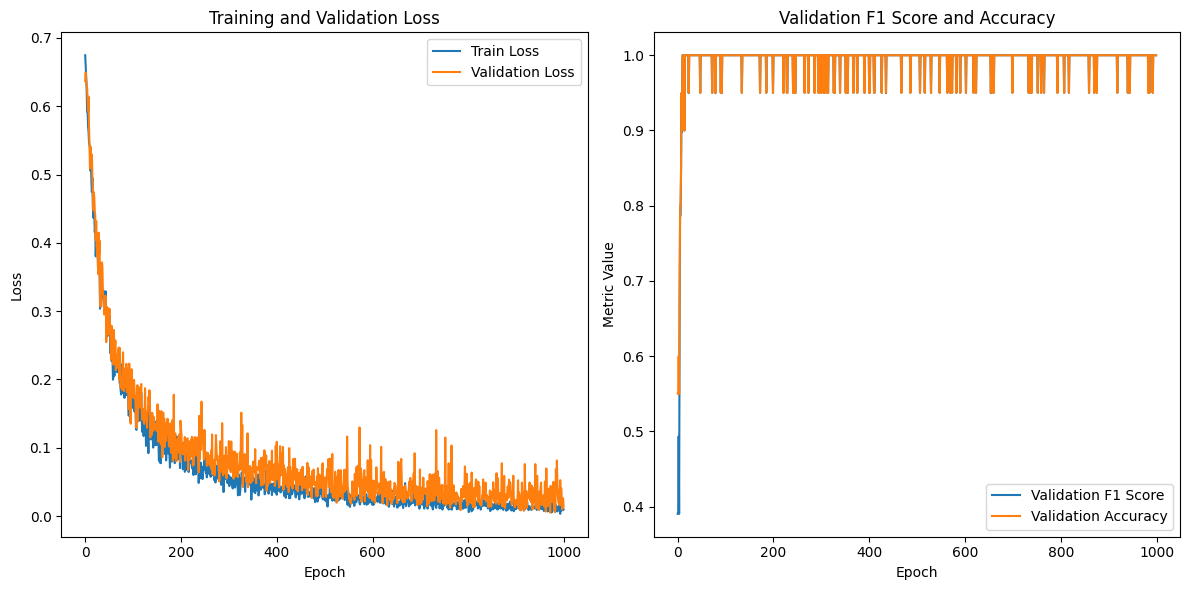


Epoch 1/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.663]

Epoch 1/1000, Train Loss: 0.6762, Validation Loss: 0.6861, F1 Score: 0.4341, Accuracy: 0.5000
Best model saved with F1 score: 0.6861




Epoch 1/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.663]


Epoch 2/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.657]

Epoch 2/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.653]

Epoch 2/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.656]

Epoch 2/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.67] 

Epoch 2/1000, Train Loss: 0.6589, Validation Loss: 0.6883, F1 Score: 0.3513, Accuracy: 0.4500



Epoch 2/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.67]

Epoch 3/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.66] 

Epoch 3/1000, Train Loss: 0.6504, Validation Loss: 0.6314, F1 Score: 0.6813, Accuracy: 0.7000
Best model saved with F1 score: 0.6314




Epoch 3/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.66]


Epoch 4/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.65]

Epoch 4/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.637]

Epoch 4/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.647]

Epoch 4/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.633]

Epoch 4/1000, Train Loss: 0.6418, Validation Loss: 0.6153, F1 Score: 0.8000, Accuracy: 0.8000
Best model saved with F1 score: 0.6153



Epoch 4/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.633]

Epoch 5/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.565]

Epoch 5/1000, Train Loss: 0.5964, Validation Loss: 0.5928, F1 Score: 0.8489, Accuracy: 0.8500
Best model saved with F1 score: 0.5928




Epoch 5/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.565]


Epoch 6/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.622]

Epoch 6/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.594]

Epoch 6/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.602]

Epoch 6/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.557]

Epoch 6/1000, Train Loss: 0.5938, Validation Loss: 0.6147, F1 Score: 0.7481, Accuracy: 0.7500



Epoch 6/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.557]

Epoch 7/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.596]

Epoch 7/1000, Train Loss: 0.5927, Validation Loss: 0.5732, F1 Score: 0.9501, Accuracy: 0.9500
Best model saved with F1 score: 0.5732




Epoch 7/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.596]


Epoch 8/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.56]

Epoch 8/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.579]

Epoch 8/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.568]

Epoch 8/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.579]

Epoch 8/1000, Train Loss: 0.5714, Validation Loss: 0.5737, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 8/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.579]

Epoch 9/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.57] 

Epoch 9/1000, Train Loss: 0.5565, Validation Loss: 0.5429, F1 Score: 0.9000, Accuracy: 0.9000
Best model saved with F1 score: 0.5429




Epoch 9/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.57]


Epoch 10/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.522]

Epoch 10/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.536]

Epoch 10/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.512]

Epoch 10/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.509]

Epoch 10/1000, Train Loss: 0.5199, Validation Loss: 0.5526, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 10/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.509]

Epoch 11/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.497]

Epoch 11/1000, Train Loss: 0.5068, Validation Loss: 0.4998, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4998




Epoch 11/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.497]


Epoch 12/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.54]

Epoch 12/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.462]

Epoch 12/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.506]

Epoch 12/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.523]

Epoch 12/1000, Train Loss: 0.5079, Validation Loss: 0.5471, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 12/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.523]

Epoch 13/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.469]

Epoch 13/1000, Train Loss: 0.4999, Validation Loss: 0.5144, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 13/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.469]


Epoch 14/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.513]

Epoch 14/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.489]

Epoch 14/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.505]

Epoch 14/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.434]

Epoch 14/1000, Train Loss: 0.4853, Validation Loss: 0.4739, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4739



Epoch 14/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.434]

Epoch 15/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.47]

Epoch 15/1000, Train Loss: 0.4647, Validation Loss: 0.4821, F1 Score: 0.9501, Accuracy: 0.9500




Epoch 15/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.47]


Epoch 16/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.484]

Epoch 16/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.48] 

Epoch 16/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.493]

Epoch 16/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.474]

Epoch 16/1000, Train Loss: 0.4827, Validation Loss: 0.4629, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4629



Epoch 16/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.474]

Epoch 17/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.44] 

Epoch 17/1000, Train Loss: 0.4545, Validation Loss: 0.4579, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4579




Epoch 17/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.44]


Epoch 18/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.461]

Epoch 18/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.377]

Epoch 18/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.439]

Epoch 18/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.414]

Epoch 18/1000, Train Loss: 0.4227, Validation Loss: 0.4663, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 18/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.414]

Epoch 19/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.443]

Epoch 19/1000, Train Loss: 0.4379, Validation Loss: 0.4327, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4327




Epoch 19/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.443]


Epoch 20/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.48]

Epoch 20/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.446]

Epoch 20/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.441]

Epoch 20/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.419]

Epoch 20/1000, Train Loss: 0.4465, Validation Loss: 0.4437, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 20/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.419]

Epoch 21/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.39] 

Epoch 21/1000, Train Loss: 0.4112, Validation Loss: 0.4387, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 21/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.39]


Epoch 22/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.382]

Epoch 22/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.403]

Epoch 22/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.39] 

Epoch 22/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.347]

Epoch 22/1000, Train Loss: 0.3805, Validation Loss: 0.4055, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.4055



Epoch 22/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.347]

Epoch 23/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.39] 

Epoch 23/1000, Train Loss: 0.4044, Validation Loss: 0.4050, F1 Score: 0.9496, Accuracy: 0.9500
Best model saved with F1 score: 0.4050




Epoch 23/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.39]


Epoch 24/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.402]

Epoch 24/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.434]

Epoch 24/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.411]

Epoch 24/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.403]

Epoch 24/1000, Train Loss: 0.4124, Validation Loss: 0.4255, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 24/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.403]

Epoch 25/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.423]

Epoch 25/1000, Train Loss: 0.4090, Validation Loss: 0.4076, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 25/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.423]


Epoch 26/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.414]

Epoch 26/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.348]

Epoch 26/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.417]

Epoch 26/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.289]

Epoch 26/1000, Train Loss: 0.3669, Validation Loss: 0.3719, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3719



Epoch 26/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.289]

Epoch 27/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.391]

Epoch 27/1000, Train Loss: 0.3630, Validation Loss: 0.3723, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 27/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.391]


Epoch 28/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.396]

Epoch 28/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.34] 

Epoch 28/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.321]

Epoch 28/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.391]

Epoch 28/1000, Train Loss: 0.3620, Validation Loss: 0.3764, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 28/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.391]

Epoch 29/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.276]

Epoch 29/1000, Train Loss: 0.3026, Validation Loss: 0.3329, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.3329




Epoch 29/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.276]


Epoch 30/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.4]

Epoch 30/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.369]

Epoch 30/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.374]

Epoch 30/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.369]

Epoch 30/1000, Train Loss: 0.3781, Validation Loss: 0.3812, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 30/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.369]

Epoch 31/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.284]

Epoch 31/1000, Train Loss: 0.3456, Validation Loss: 0.3837, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 31/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.284]


Epoch 32/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.385]

Epoch 32/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.345]

Epoch 32/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.286]

Epoch 32/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.337]

Epoch 32/1000, Train Loss: 0.3381, Validation Loss: 0.3766, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 32/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.337]

Epoch 33/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.315]

Epoch 33/1000, Train Loss: 0.3400, Validation Loss: 0.3446, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 33/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.315]


Epoch 34/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.322]

Epoch 34/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.337]

Epoch 34/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.332]

Epoch 34/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.359]

Epoch 34/1000, Train Loss: 0.3374, Validation Loss: 0.3483, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 34/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.359]

Epoch 35/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.299]

Epoch 35/1000, Train Loss: 0.3067, Validation Loss: 0.3500, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 35/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.299]


Epoch 36/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.333]

Epoch 36/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.225]

Epoch 36/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.258]

Epoch 36/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.23] 

Epoch 36/1000, Train Loss: 0.2617, Validation Loss: 0.2836, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2836



Epoch 36/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.23]

Epoch 37/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.315]

Epoch 37/1000, Train Loss: 0.2761, Validation Loss: 0.3173, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 37/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.315]


Epoch 38/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.381]

Epoch 38/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.308]

Epoch 38/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.322]

Epoch 38/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.338]

Epoch 38/1000, Train Loss: 0.3373, Validation Loss: 0.3122, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 38/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.338]

Epoch 39/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.234]

Epoch 39/1000, Train Loss: 0.2706, Validation Loss: 0.2964, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 39/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.234]


Epoch 40/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.276]

Epoch 40/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.307]

Epoch 40/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.313]

Epoch 40/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.299]

Epoch 40/1000, Train Loss: 0.2987, Validation Loss: 0.3078, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 40/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.299]

Epoch 41/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.33] 

Epoch 41/1000, Train Loss: 0.3049, Validation Loss: 0.2917, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 41/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.33]


Epoch 42/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.324]

Epoch 42/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.325]

Epoch 42/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.318]

Epoch 42/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.266]

Epoch 42/1000, Train Loss: 0.3084, Validation Loss: 0.3375, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 42/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.266]

Epoch 43/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.2]  

Epoch 43/1000, Train Loss: 0.2742, Validation Loss: 0.2841, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 43/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.2]


Epoch 44/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.316]

Epoch 44/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.224]

Epoch 44/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.297]

Epoch 44/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.287]

Epoch 44/1000, Train Loss: 0.2808, Validation Loss: 0.3134, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 44/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.287]

Epoch 45/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.193]

Epoch 45/1000, Train Loss: 0.2274, Validation Loss: 0.2772, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2772




Epoch 45/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.193]


Epoch 46/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.211]

Epoch 46/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.212]

Epoch 46/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.185]

Epoch 46/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.269]

Epoch 46/1000, Train Loss: 0.2194, Validation Loss: 0.2871, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 46/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.269]

Epoch 47/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.269]

Epoch 47/1000, Train Loss: 0.2646, Validation Loss: 0.2834, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 47/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.269]


Epoch 48/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.267]

Epoch 48/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.16] 

Epoch 48/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.226]

Epoch 48/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.315]

Epoch 48/1000, Train Loss: 0.2418, Validation Loss: 0.2797, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 48/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.315]

Epoch 49/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.297]

Epoch 49/1000, Train Loss: 0.2776, Validation Loss: 0.2348, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2348




Epoch 49/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.297]


Epoch 50/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.258]

Epoch 50/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.287]

Epoch 50/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.237]

Epoch 50/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.244]

Epoch 50/1000, Train Loss: 0.2565, Validation Loss: 0.2620, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 50/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.244]

Epoch 51/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.278]

Epoch 51/1000, Train Loss: 0.2692, Validation Loss: 0.2692, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 51/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.278]


Epoch 52/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.312]

Epoch 52/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.199]

Epoch 52/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.267]

Epoch 52/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.268]

Epoch 52/1000, Train Loss: 0.2617, Validation Loss: 0.2690, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 52/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.268]

Epoch 53/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.263]

Epoch 53/1000, Train Loss: 0.2460, Validation Loss: 0.2706, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 53/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.263]


Epoch 54/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.259]

Epoch 54/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.228]

Epoch 54/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.299]

Epoch 54/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.265]

Epoch 54/1000, Train Loss: 0.2629, Validation Loss: 0.2888, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 54/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.265]

Epoch 55/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.255]

Epoch 55/1000, Train Loss: 0.2515, Validation Loss: 0.2391, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 55/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.255]


Epoch 56/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.259]

Epoch 56/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.151]

Epoch 56/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.246]

Epoch 56/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.199]

Epoch 56/1000, Train Loss: 0.2136, Validation Loss: 0.2140, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2140



Epoch 56/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.199]

Epoch 57/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.264]

Epoch 57/1000, Train Loss: 0.2258, Validation Loss: 0.2332, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 57/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.264]


Epoch 58/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.218]

Epoch 58/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.225]

Epoch 58/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.264]

Epoch 58/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.228]

Epoch 58/1000, Train Loss: 0.2337, Validation Loss: 0.2453, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 58/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.228]

Epoch 59/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.148]

Epoch 59/1000, Train Loss: 0.1986, Validation Loss: 0.2469, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 59/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.148]


Epoch 60/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.291]

Epoch 60/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.224]

Epoch 60/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.205]

Epoch 60/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.185]

Epoch 60/1000, Train Loss: 0.2261, Validation Loss: 0.2297, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 60/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.185]

Epoch 61/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.205]

Epoch 61/1000, Train Loss: 0.2102, Validation Loss: 0.2138, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.2138




Epoch 61/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.205]


Epoch 62/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.239]

Epoch 62/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.209]

Epoch 62/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.216]

Epoch 62/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.22] 

Epoch 62/1000, Train Loss: 0.2209, Validation Loss: 0.2297, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 62/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.22]

Epoch 63/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.203]

Epoch 63/1000, Train Loss: 0.2376, Validation Loss: 0.2349, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 63/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.203]


Epoch 64/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.264]

Epoch 64/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.153]

Epoch 64/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.157]

Epoch 64/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.205]

Epoch 64/1000, Train Loss: 0.1948, Validation Loss: 0.1980, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1980



Epoch 64/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.205]

Epoch 65/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.192]

Epoch 65/1000, Train Loss: 0.2216, Validation Loss: 0.2302, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 65/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.192]


Epoch 66/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.273]

Epoch 66/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.17] 

Epoch 66/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.169]

Epoch 66/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.142]

Epoch 66/1000, Train Loss: 0.1883, Validation Loss: 0.2278, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 66/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.142]

Epoch 67/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.236]

Epoch 67/1000, Train Loss: 0.2165, Validation Loss: 0.2483, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 67/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.236]


Epoch 68/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.262]

Epoch 68/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.198]

Epoch 68/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.259]

Epoch 68/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.156]

Epoch 68/1000, Train Loss: 0.2189, Validation Loss: 0.2232, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 68/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.156]

Epoch 69/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.224]

Epoch 69/1000, Train Loss: 0.2102, Validation Loss: 0.2452, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 69/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.224]


Epoch 70/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.22]

Epoch 70/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.254]

Epoch 70/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.205]

Epoch 70/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.125]

Epoch 70/1000, Train Loss: 0.2010, Validation Loss: 0.2213, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 70/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.125]

Epoch 71/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.168]

Epoch 71/1000, Train Loss: 0.1778, Validation Loss: 0.2114, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 71/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.168]


Epoch 72/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.269]

Epoch 72/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.208]

Epoch 72/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.161]

Epoch 72/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.184]

Epoch 72/1000, Train Loss: 0.2055, Validation Loss: 0.2012, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 72/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.184]

Epoch 73/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.189]

Epoch 73/1000, Train Loss: 0.2122, Validation Loss: 0.2312, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 73/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.189]


Epoch 74/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.202]

Epoch 74/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.165]

Epoch 74/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.176]

Epoch 74/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.155]

Epoch 74/1000, Train Loss: 0.1746, Validation Loss: 0.2079, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 74/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.155]

Epoch 75/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.159]

Epoch 75/1000, Train Loss: 0.1701, Validation Loss: 0.2109, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 75/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.159]


Epoch 76/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.183]

Epoch 76/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.154]

Epoch 76/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.161]

Epoch 76/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.193]

Epoch 76/1000, Train Loss: 0.1727, Validation Loss: 0.1637, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1637



Epoch 76/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.193]

Epoch 77/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.143]

Epoch 77/1000, Train Loss: 0.1670, Validation Loss: 0.1938, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 77/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.143]


Epoch 78/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.17]

Epoch 78/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.148]

Epoch 78/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.174]

Epoch 78/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.214]

Epoch 78/1000, Train Loss: 0.1764, Validation Loss: 0.1923, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 78/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.214]

Epoch 79/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.187]

Epoch 79/1000, Train Loss: 0.1737, Validation Loss: 0.2087, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 79/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.187]


Epoch 80/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.107]

Epoch 80/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.134]

Epoch 80/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.144]

Epoch 80/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.117]

Epoch 80/1000, Train Loss: 0.1254, Validation Loss: 0.1630, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1630



Epoch 80/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.117]

Epoch 81/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.175]

Epoch 81/1000, Train Loss: 0.1788, Validation Loss: 0.1817, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 81/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.175]


Epoch 82/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.238]

Epoch 82/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0728]

Epoch 82/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.145] 

Epoch 82/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.173]

Epoch 82/1000, Train Loss: 0.1572, Validation Loss: 0.1805, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 82/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.173]

Epoch 83/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.168]

Epoch 83/1000, Train Loss: 0.1710, Validation Loss: 0.1501, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1501




Epoch 83/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.168]


Epoch 84/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.165]

Epoch 84/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.189]

Epoch 84/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.154]

Epoch 84/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.169]

Epoch 84/1000, Train Loss: 0.1694, Validation Loss: 0.1543, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 84/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.169]

Epoch 85/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.139]

Epoch 85/1000, Train Loss: 0.1498, Validation Loss: 0.1668, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 85/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.139]


Epoch 86/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.14]

Epoch 86/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.213]

Epoch 86/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.168]

Epoch 86/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0932]

Epoch 86/1000, Train Loss: 0.1537, Validation Loss: 0.1866, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 86/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0932]

Epoch 87/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.166]

Epoch 87/1000, Train Loss: 0.1912, Validation Loss: 0.1768, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 87/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.166]


Epoch 88/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.158]

Epoch 88/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.183]

Epoch 88/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.109]

Epoch 88/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.175]

Epoch 88/1000, Train Loss: 0.1563, Validation Loss: 0.1669, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 88/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.175]

Epoch 89/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.192]

Epoch 89/1000, Train Loss: 0.1692, Validation Loss: 0.2036, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 89/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.192]


Epoch 90/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.193]

Epoch 90/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.156]

Epoch 90/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.179]

Epoch 90/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.211]

Epoch 90/1000, Train Loss: 0.1846, Validation Loss: 0.1847, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 90/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.211]

Epoch 91/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.17] 

Epoch 91/1000, Train Loss: 0.1653, Validation Loss: 0.1605, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 91/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.17]


Epoch 92/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.187]

Epoch 92/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.199]

Epoch 92/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.112]

Epoch 92/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.152]

Epoch 92/1000, Train Loss: 0.1625, Validation Loss: 0.1732, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 92/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.152]

Epoch 93/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.108]

Epoch 93/1000, Train Loss: 0.1307, Validation Loss: 0.1933, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 93/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.108]


Epoch 94/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.213]

Epoch 94/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.172]

Epoch 94/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.154]

Epoch 94/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.161]

Epoch 94/1000, Train Loss: 0.1751, Validation Loss: 0.1409, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1409



Epoch 94/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.161]

Epoch 95/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.149]

Epoch 95/1000, Train Loss: 0.1717, Validation Loss: 0.1770, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 95/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.149]


Epoch 96/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.183]

Epoch 96/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.191]

Epoch 96/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.14] 

Epoch 96/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0908]

Epoch 96/1000, Train Loss: 0.1513, Validation Loss: 0.1772, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 96/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0908]

Epoch 97/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.161]

Epoch 97/1000, Train Loss: 0.1705, Validation Loss: 0.1611, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 97/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.161]


Epoch 98/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.117]

Epoch 98/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.182]

Epoch 98/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.139]

Epoch 98/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.154]

Epoch 98/1000, Train Loss: 0.1479, Validation Loss: 0.1194, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1194



Epoch 98/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.154]

Epoch 99/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.168]

Epoch 99/1000, Train Loss: 0.1271, Validation Loss: 0.1198, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 99/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.168]


Epoch 100/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.172]

Epoch 100/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.15] 

Epoch 100/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.173]

Epoch 100/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.154]

Epoch 100/1000, Train Loss: 0.1621, Validation Loss: 0.1889, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 100/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.154]

Epoch 101/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.143]

Epoch 101/1000, Train Loss: 0.1525, Validation Loss: 0.1589, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 101/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.143]


Epoch 102/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.218]

Epoch 102/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.115]

Epoch 102/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.191]

Epoch 102/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.158]

Epoch 102/1000, Train Loss: 0.1706, Validation Loss: 0.1705, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 102/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.158]

Epoch 103/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0941]

Epoch 103/1000, Train Loss: 0.1511, Validation Loss: 0.1566, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 103/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0941]


Epoch 104/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.194]

Epoch 104/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.145]

Epoch 104/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.143]

Epoch 104/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.143]

Epoch 104/1000, Train Loss: 0.1563, Validation Loss: 0.1483, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 104/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.143]

Epoch 105/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.131]

Epoch 105/1000, Train Loss: 0.1344, Validation Loss: 0.1334, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 105/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.131]


Epoch 106/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.174]

Epoch 106/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.168]

Epoch 106/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0914]

Epoch 106/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111] 

Epoch 106/1000, Train Loss: 0.1362, Validation Loss: 0.1380, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 106/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.111]

Epoch 107/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0693]

Epoch 107/1000, Train Loss: 0.1294, Validation Loss: 0.1621, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 107/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0693]


Epoch 108/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.152]

Epoch 108/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.169]

Epoch 108/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0947]

Epoch 108/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.156] 

Epoch 108/1000, Train Loss: 0.1430, Validation Loss: 0.1258, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 108/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.156]

Epoch 109/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.109]

Epoch 109/1000, Train Loss: 0.1289, Validation Loss: 0.1562, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 109/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.109]


Epoch 110/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.188]

Epoch 110/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0955]

Epoch 110/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0774]

Epoch 110/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.084] 

Epoch 110/1000, Train Loss: 0.1111, Validation Loss: 0.1411, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 110/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.084]

Epoch 111/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.11] 

Epoch 111/1000, Train Loss: 0.1244, Validation Loss: 0.1436, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 111/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.11]


Epoch 112/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.123]

Epoch 112/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.125]

Epoch 112/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.143]

Epoch 112/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0952]

Epoch 112/1000, Train Loss: 0.1216, Validation Loss: 0.1476, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 112/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0952]

Epoch 113/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101]

Epoch 113/1000, Train Loss: 0.1440, Validation Loss: 0.1559, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 113/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101]


Epoch 114/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.15]

Epoch 114/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0482]

Epoch 114/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.132] 

Epoch 114/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0634]

Epoch 114/1000, Train Loss: 0.0983, Validation Loss: 0.1416, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 114/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0634]

Epoch 115/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.114]

Epoch 115/1000, Train Loss: 0.1265, Validation Loss: 0.1408, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 115/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.114]


Epoch 116/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.143]

Epoch 116/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.166]

Epoch 116/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0912]

Epoch 116/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0933]

Epoch 116/1000, Train Loss: 0.1233, Validation Loss: 0.1179, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1179



Epoch 116/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0933]

Epoch 117/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.172]

Epoch 117/1000, Train Loss: 0.1710, Validation Loss: 0.1434, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 117/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.172]


Epoch 118/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.182]

Epoch 118/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.122]

Epoch 118/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0715]

Epoch 118/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.11]  

Epoch 118/1000, Train Loss: 0.1214, Validation Loss: 0.1088, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1088



Epoch 118/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.11]

Epoch 119/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12]  

Epoch 119/1000, Train Loss: 0.1230, Validation Loss: 0.1524, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 119/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12]


Epoch 120/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.176]

Epoch 120/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.124]

Epoch 120/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0996]

Epoch 120/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.153] 

Epoch 120/1000, Train Loss: 0.1382, Validation Loss: 0.1520, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 120/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.153]

Epoch 121/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.167]

Epoch 121/1000, Train Loss: 0.1484, Validation Loss: 0.1493, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 121/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.167]


Epoch 122/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.159]

Epoch 122/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.152]

Epoch 122/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.12] 

Epoch 122/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0754]

Epoch 122/1000, Train Loss: 0.1264, Validation Loss: 0.1919, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 122/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0754]

Epoch 123/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.13] 

Epoch 123/1000, Train Loss: 0.1315, Validation Loss: 0.1962, F1 Score: 0.9496, Accuracy: 0.9500




Epoch 123/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.13]


Epoch 124/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.127]

Epoch 124/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.11] 

Epoch 124/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.09]

Epoch 124/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0818]

Epoch 124/1000, Train Loss: 0.1023, Validation Loss: 0.1386, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 124/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0818]

Epoch 125/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0526]

Epoch 125/1000, Train Loss: 0.1178, Validation Loss: 0.1424, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 125/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0526]


Epoch 126/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.128]

Epoch 126/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0651]

Epoch 126/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0632]

Epoch 126/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.14]  

Epoch 126/1000, Train Loss: 0.0990, Validation Loss: 0.1112, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 126/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.14]

Epoch 127/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.125] 

Epoch 127/1000, Train Loss: 0.1391, Validation Loss: 0.1231, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 127/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.125]


Epoch 128/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.104]

Epoch 128/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.135]

Epoch 128/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.126]

Epoch 128/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0892]

Epoch 128/1000, Train Loss: 0.1139, Validation Loss: 0.1441, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 128/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0892]

Epoch 129/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0985]

Epoch 129/1000, Train Loss: 0.1228, Validation Loss: 0.1456, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 129/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0985]


Epoch 130/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.234]

Epoch 130/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.121]

Epoch 130/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.045]

Epoch 130/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12] 

Epoch 130/1000, Train Loss: 0.1303, Validation Loss: 0.1290, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 130/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12]

Epoch 131/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.119] 

Epoch 131/1000, Train Loss: 0.1330, Validation Loss: 0.1323, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 131/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.119]


Epoch 132/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.101]

Epoch 132/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.179]

Epoch 132/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.124]

Epoch 132/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0844]

Epoch 132/1000, Train Loss: 0.1221, Validation Loss: 0.1112, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 132/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0844]

Epoch 133/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.113]

Epoch 133/1000, Train Loss: 0.1155, Validation Loss: 0.1088, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.1088




Epoch 133/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.113]


Epoch 134/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0987]

Epoch 134/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0689]

Epoch 134/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.143] 

Epoch 134/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.134]

Epoch 134/1000, Train Loss: 0.1113, Validation Loss: 0.0895, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0895



Epoch 134/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.134]

Epoch 135/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]

Epoch 135/1000, Train Loss: 0.1305, Validation Loss: 0.1116, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 135/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.129]


Epoch 136/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.13]

Epoch 136/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0763]

Epoch 136/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0906]

Epoch 136/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.074] 

Epoch 136/1000, Train Loss: 0.0926, Validation Loss: 0.1653, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 136/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.074]

Epoch 137/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101] 

Epoch 137/1000, Train Loss: 0.0826, Validation Loss: 0.1257, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 137/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101]


Epoch 138/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.124]

Epoch 138/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.123]

Epoch 138/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0488]

Epoch 138/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101] 

Epoch 138/1000, Train Loss: 0.0991, Validation Loss: 0.1180, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 138/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101]

Epoch 139/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0894]

Epoch 139/1000, Train Loss: 0.0964, Validation Loss: 0.0877, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0877




Epoch 139/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0894]


Epoch 140/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.107]

Epoch 140/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.135]

Epoch 140/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0526]

Epoch 140/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0841]

Epoch 140/1000, Train Loss: 0.0947, Validation Loss: 0.1008, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 140/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0841]

Epoch 141/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0947]

Epoch 141/1000, Train Loss: 0.1060, Validation Loss: 0.1352, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 141/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0947]


Epoch 142/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.129]

Epoch 142/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.125]

Epoch 142/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.122]

Epoch 142/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.113]

Epoch 142/1000, Train Loss: 0.1224, Validation Loss: 0.1108, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 142/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.113]

Epoch 143/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]

Epoch 143/1000, Train Loss: 0.1217, Validation Loss: 0.1324, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 143/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.138]


Epoch 144/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.148]

Epoch 144/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.116]

Epoch 144/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0583]

Epoch 144/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0418]

Epoch 144/1000, Train Loss: 0.0912, Validation Loss: 0.1284, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 144/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0418]

Epoch 145/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0689]

Epoch 145/1000, Train Loss: 0.1009, Validation Loss: 0.1151, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 145/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0689]


Epoch 146/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.11]

Epoch 146/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.103]

Epoch 146/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0362]

Epoch 146/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.14]  

Epoch 146/1000, Train Loss: 0.0973, Validation Loss: 0.1177, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 146/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.14]

Epoch 147/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.121]

Epoch 147/1000, Train Loss: 0.0954, Validation Loss: 0.1164, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 147/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.121]


Epoch 148/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.166]

Epoch 148/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0411]

Epoch 148/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.113] 

Epoch 148/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0865]

Epoch 148/1000, Train Loss: 0.1017, Validation Loss: 0.1168, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 148/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0865]

Epoch 149/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.139]

Epoch 149/1000, Train Loss: 0.1274, Validation Loss: 0.1010, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 149/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.139]


Epoch 150/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.169]

Epoch 150/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.141]

Epoch 150/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.105]

Epoch 150/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0999]

Epoch 150/1000, Train Loss: 0.1288, Validation Loss: 0.1058, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 150/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0999]

Epoch 151/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101] 

Epoch 151/1000, Train Loss: 0.1195, Validation Loss: 0.1025, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 151/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101]


Epoch 152/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.168]

Epoch 152/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.142]

Epoch 152/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.101]

Epoch 152/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0889]

Epoch 152/1000, Train Loss: 0.1251, Validation Loss: 0.1045, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 152/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0889]

Epoch 153/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0486]

Epoch 153/1000, Train Loss: 0.0762, Validation Loss: 0.1224, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 153/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0486]


Epoch 154/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.114]

Epoch 154/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0921]

Epoch 154/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0682]

Epoch 154/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.107] 

Epoch 154/1000, Train Loss: 0.0953, Validation Loss: 0.0952, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 154/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.107]

Epoch 155/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0548]

Epoch 155/1000, Train Loss: 0.0812, Validation Loss: 0.1040, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 155/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0548]


Epoch 156/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.115]

Epoch 156/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0783]

Epoch 156/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.105] 

Epoch 156/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0743]

Epoch 156/1000, Train Loss: 0.0933, Validation Loss: 0.1100, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 156/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0743]

Epoch 157/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0824]

Epoch 157/1000, Train Loss: 0.1084, Validation Loss: 0.0878, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 157/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0824]


Epoch 158/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.121]

Epoch 158/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0729]

Epoch 158/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0927]

Epoch 158/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0575]

Epoch 158/1000, Train Loss: 0.0859, Validation Loss: 0.1056, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 158/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0575]

Epoch 159/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0898]

Epoch 159/1000, Train Loss: 0.0802, Validation Loss: 0.0675, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0675




Epoch 159/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0898]


Epoch 160/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0902]

Epoch 160/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0843]

Epoch 160/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0493]

Epoch 160/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.105] 

Epoch 160/1000, Train Loss: 0.0821, Validation Loss: 0.0817, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 160/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.105]

Epoch 161/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0929]

Epoch 161/1000, Train Loss: 0.0918, Validation Loss: 0.0946, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 161/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0929]


Epoch 162/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.122]

Epoch 162/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0659]

Epoch 162/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0936]

Epoch 162/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0642]

Epoch 162/1000, Train Loss: 0.0864, Validation Loss: 0.0937, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 162/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0642]

Epoch 163/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0592]

Epoch 163/1000, Train Loss: 0.0842, Validation Loss: 0.0969, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 163/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0592]


Epoch 164/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.131]

Epoch 164/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0874]

Epoch 164/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0779]

Epoch 164/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.133] 

Epoch 164/1000, Train Loss: 0.1073, Validation Loss: 0.0978, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 164/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.133]

Epoch 165/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0757]

Epoch 165/1000, Train Loss: 0.0699, Validation Loss: 0.0978, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 165/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0757]


Epoch 166/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0756]

Epoch 166/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0362]

Epoch 166/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.109] 

Epoch 166/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103]

Epoch 166/1000, Train Loss: 0.0809, Validation Loss: 0.1004, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 166/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103]

Epoch 167/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.057] 

Epoch 167/1000, Train Loss: 0.0777, Validation Loss: 0.0816, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 167/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.057]


Epoch 168/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.101]

Epoch 168/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0458]

Epoch 168/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0934]

Epoch 168/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0804]

Epoch 168/1000, Train Loss: 0.0803, Validation Loss: 0.0628, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0628



Epoch 168/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0804]

Epoch 169/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0611]

Epoch 169/1000, Train Loss: 0.0621, Validation Loss: 0.1146, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 169/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0611]


Epoch 170/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0803]

Epoch 170/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0647]

Epoch 170/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0964]

Epoch 170/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.13]  

Epoch 170/1000, Train Loss: 0.0928, Validation Loss: 0.0837, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 170/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.13]

Epoch 171/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0854]

Epoch 171/1000, Train Loss: 0.0735, Validation Loss: 0.0894, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 171/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0854]


Epoch 172/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0966]

Epoch 172/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0698]

Epoch 172/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.101] 

Epoch 172/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0614]

Epoch 172/1000, Train Loss: 0.0822, Validation Loss: 0.1062, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 172/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0614]

Epoch 173/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0772]

Epoch 173/1000, Train Loss: 0.0875, Validation Loss: 0.0848, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 173/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0772]


Epoch 174/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.107]

Epoch 174/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0859]

Epoch 174/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0758]

Epoch 174/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.109] 

Epoch 174/1000, Train Loss: 0.0946, Validation Loss: 0.1080, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 174/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.109]

Epoch 175/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0947]

Epoch 175/1000, Train Loss: 0.0837, Validation Loss: 0.1025, F1 Score: 0.9496, Accuracy: 0.9500




Epoch 175/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0947]


Epoch 176/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.116]

Epoch 176/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.069]

Epoch 176/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0648]

Epoch 176/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0959]

Epoch 176/1000, Train Loss: 0.0864, Validation Loss: 0.1454, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 176/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0959]

Epoch 177/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.115] 

Epoch 177/1000, Train Loss: 0.1031, Validation Loss: 0.0896, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 177/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.115]


Epoch 178/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.102]

Epoch 178/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0729]

Epoch 178/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0877]

Epoch 178/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.091] 

Epoch 178/1000, Train Loss: 0.0883, Validation Loss: 0.0744, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 178/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.091]

Epoch 179/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0553]

Epoch 179/1000, Train Loss: 0.0818, Validation Loss: 0.0887, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 179/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0553]


Epoch 180/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.101]

Epoch 180/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0978]

Epoch 180/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0499]

Epoch 180/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0903]

Epoch 180/1000, Train Loss: 0.0848, Validation Loss: 0.1087, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 180/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0903]

Epoch 181/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.102] 

Epoch 181/1000, Train Loss: 0.0949, Validation Loss: 0.0855, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 181/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.102]


Epoch 182/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.119]

Epoch 182/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0576]

Epoch 182/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.042] 

Epoch 182/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.04] 

Epoch 182/1000, Train Loss: 0.0647, Validation Loss: 0.0813, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 182/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.04]

Epoch 183/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.098] 

Epoch 183/1000, Train Loss: 0.0771, Validation Loss: 0.0987, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 183/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.098]


Epoch 184/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.107]

Epoch 184/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0687]

Epoch 184/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0894]

Epoch 184/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0389]

Epoch 184/1000, Train Loss: 0.0761, Validation Loss: 0.0969, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 184/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0389]

Epoch 185/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12]  

Epoch 185/1000, Train Loss: 0.0846, Validation Loss: 0.0866, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 185/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.12]


Epoch 186/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0787]

Epoch 186/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0771]

Epoch 186/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0921]

Epoch 186/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.068] 

Epoch 186/1000, Train Loss: 0.0790, Validation Loss: 0.0995, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 186/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.068]

Epoch 187/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0797]

Epoch 187/1000, Train Loss: 0.0802, Validation Loss: 0.0822, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 187/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0797]


Epoch 188/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.113]

Epoch 188/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0874]

Epoch 188/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0829]

Epoch 188/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0614]

Epoch 188/1000, Train Loss: 0.0861, Validation Loss: 0.0996, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 188/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0614]

Epoch 189/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0776]

Epoch 189/1000, Train Loss: 0.0755, Validation Loss: 0.0963, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 189/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0776]


Epoch 190/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.11]

Epoch 190/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.08]

Epoch 190/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0637]

Epoch 190/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103] 

Epoch 190/1000, Train Loss: 0.0891, Validation Loss: 0.0729, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 190/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103]

Epoch 191/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.082] 

Epoch 191/1000, Train Loss: 0.0865, Validation Loss: 0.0698, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 191/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.082]


Epoch 192/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0835]

Epoch 192/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0428]

Epoch 192/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0563]

Epoch 192/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0603]

Epoch 192/1000, Train Loss: 0.0607, Validation Loss: 0.0845, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 192/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0603]

Epoch 193/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0625]

Epoch 193/1000, Train Loss: 0.0668, Validation Loss: 0.0580, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0580




Epoch 193/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0625]


Epoch 194/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0846]

Epoch 194/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.064] 

Epoch 194/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.061]

Epoch 194/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0849]

Epoch 194/1000, Train Loss: 0.0736, Validation Loss: 0.0590, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 194/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0849]

Epoch 195/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0753]

Epoch 195/1000, Train Loss: 0.0853, Validation Loss: 0.0721, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 195/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0753]


Epoch 196/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0758]

Epoch 196/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0236]

Epoch 196/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0968]

Epoch 196/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0969]

Epoch 196/1000, Train Loss: 0.0733, Validation Loss: 0.0947, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 196/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0969]

Epoch 197/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0759]

Epoch 197/1000, Train Loss: 0.0767, Validation Loss: 0.0765, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 197/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0759]


Epoch 198/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0775]

Epoch 198/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0577]

Epoch 198/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0382]

Epoch 198/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0857]

Epoch 198/1000, Train Loss: 0.0648, Validation Loss: 0.1142, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 198/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0857]

Epoch 199/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0768]

Epoch 199/1000, Train Loss: 0.0718, Validation Loss: 0.0646, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 199/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0768]


Epoch 200/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0844]

Epoch 200/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0543]

Epoch 200/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.132] 

Epoch 200/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0527]

Epoch 200/1000, Train Loss: 0.0808, Validation Loss: 0.1318, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 200/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0527]

Epoch 201/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0669]

Epoch 201/1000, Train Loss: 0.0753, Validation Loss: 0.0854, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 201/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0669]


Epoch 202/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0758]

Epoch 202/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0591]

Epoch 202/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0697]

Epoch 202/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.114] 

Epoch 202/1000, Train Loss: 0.0796, Validation Loss: 0.1153, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 202/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.114]

Epoch 203/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0816]

Epoch 203/1000, Train Loss: 0.0687, Validation Loss: 0.0828, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 203/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0816]


Epoch 204/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0957]

Epoch 204/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0536]

Epoch 204/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0815]

Epoch 204/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0462]

Epoch 204/1000, Train Loss: 0.0692, Validation Loss: 0.0954, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 204/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0462]

Epoch 205/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0567]

Epoch 205/1000, Train Loss: 0.0704, Validation Loss: 0.0674, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 205/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0567]


Epoch 206/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.126]

Epoch 206/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0645]

Epoch 206/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0427]

Epoch 206/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0219]

Epoch 206/1000, Train Loss: 0.0638, Validation Loss: 0.0638, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 206/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0219]

Epoch 207/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0507]

Epoch 207/1000, Train Loss: 0.0651, Validation Loss: 0.0714, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 207/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0507]


Epoch 208/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.103]

Epoch 208/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0447]

Epoch 208/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0448]

Epoch 208/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0944]

Epoch 208/1000, Train Loss: 0.0718, Validation Loss: 0.0506, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0506



Epoch 208/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0944]

Epoch 209/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0353]

Epoch 209/1000, Train Loss: 0.0524, Validation Loss: 0.0857, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 209/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0353]


Epoch 210/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.125]

Epoch 210/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0699]

Epoch 210/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0767]

Epoch 210/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0634]

Epoch 210/1000, Train Loss: 0.0837, Validation Loss: 0.0861, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 210/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0634]

Epoch 211/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0761]

Epoch 211/1000, Train Loss: 0.0669, Validation Loss: 0.0639, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 211/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0761]


Epoch 212/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.101]

Epoch 212/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0954]

Epoch 212/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0697]

Epoch 212/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0591]

Epoch 212/1000, Train Loss: 0.0812, Validation Loss: 0.0673, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 212/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0591]

Epoch 213/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103] 

Epoch 213/1000, Train Loss: 0.0777, Validation Loss: 0.0983, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 213/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103]


Epoch 214/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0555]

Epoch 214/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0762]

Epoch 214/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0249]

Epoch 214/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0747]

Epoch 214/1000, Train Loss: 0.0578, Validation Loss: 0.0784, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 214/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0747]

Epoch 215/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.077]

Epoch 215/1000, Train Loss: 0.0738, Validation Loss: 0.0715, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 215/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.077]


Epoch 216/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.129]

Epoch 216/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0649]

Epoch 216/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0581]

Epoch 216/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0291]

Epoch 216/1000, Train Loss: 0.0704, Validation Loss: 0.1020, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 216/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0291]

Epoch 217/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0802]

Epoch 217/1000, Train Loss: 0.0682, Validation Loss: 0.0907, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 217/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0802]


Epoch 218/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.084]

Epoch 218/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.1]  

Epoch 218/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.052]

Epoch 218/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0328]

Epoch 218/1000, Train Loss: 0.0673, Validation Loss: 0.0666, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 218/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0328]

Epoch 219/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0694]

Epoch 219/1000, Train Loss: 0.0596, Validation Loss: 0.0776, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 219/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0694]


Epoch 220/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0741]

Epoch 220/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0359]

Epoch 220/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0514]

Epoch 220/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0497]

Epoch 220/1000, Train Loss: 0.0528, Validation Loss: 0.0652, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 220/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0497]

Epoch 221/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0687]

Epoch 221/1000, Train Loss: 0.0671, Validation Loss: 0.0657, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 221/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0687]


Epoch 222/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0662]

Epoch 222/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0725]

Epoch 222/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.1]   

Epoch 222/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0654]

Epoch 222/1000, Train Loss: 0.0762, Validation Loss: 0.0736, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 222/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0654]

Epoch 223/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0672]

Epoch 223/1000, Train Loss: 0.0739, Validation Loss: 0.0614, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 223/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0672]


Epoch 224/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.116]

Epoch 224/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0909]

Epoch 224/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0794]

Epoch 224/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101] 

Epoch 224/1000, Train Loss: 0.0967, Validation Loss: 0.0545, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 224/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.101]

Epoch 225/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103] 

Epoch 225/1000, Train Loss: 0.0908, Validation Loss: 0.0709, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 225/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.103]


Epoch 226/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.107]

Epoch 226/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.081]

Epoch 226/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0204]

Epoch 226/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0215]

Epoch 226/1000, Train Loss: 0.0575, Validation Loss: 0.0785, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 226/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0215]

Epoch 227/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0417]

Epoch 227/1000, Train Loss: 0.0443, Validation Loss: 0.0485, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0485




Epoch 227/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0417]


Epoch 228/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0893]

Epoch 228/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0601]

Epoch 228/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0599]

Epoch 228/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0624]

Epoch 228/1000, Train Loss: 0.0679, Validation Loss: 0.0980, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 228/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0624]

Epoch 229/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0686]

Epoch 229/1000, Train Loss: 0.0812, Validation Loss: 0.0838, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 229/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0686]


Epoch 230/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0257]

Epoch 230/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0305]

Epoch 230/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0925]

Epoch 230/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0363]

Epoch 230/1000, Train Loss: 0.0462, Validation Loss: 0.0873, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 230/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0363]

Epoch 231/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.027] 

Epoch 231/1000, Train Loss: 0.0497, Validation Loss: 0.0547, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 231/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.027]


Epoch 232/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.11]

Epoch 232/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0368]

Epoch 232/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0687]

Epoch 232/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0498]

Epoch 232/1000, Train Loss: 0.0664, Validation Loss: 0.0609, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 232/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0498]

Epoch 233/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0619]

Epoch 233/1000, Train Loss: 0.0824, Validation Loss: 0.0882, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 233/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0619]


Epoch 234/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.088]

Epoch 234/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0818]

Epoch 234/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0525]

Epoch 234/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0476]

Epoch 234/1000, Train Loss: 0.0675, Validation Loss: 0.0665, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 234/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0476]

Epoch 235/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0528]

Epoch 235/1000, Train Loss: 0.0618, Validation Loss: 0.0763, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 235/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0528]


Epoch 236/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0671]

Epoch 236/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0772]

Epoch 236/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0409]

Epoch 236/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0812]

Epoch 236/1000, Train Loss: 0.0666, Validation Loss: 0.0659, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 236/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0812]

Epoch 237/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.044] 

Epoch 237/1000, Train Loss: 0.0545, Validation Loss: 0.0582, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 237/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.044]


Epoch 238/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0951]

Epoch 238/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0584]

Epoch 238/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0608]

Epoch 238/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0759]

Epoch 238/1000, Train Loss: 0.0725, Validation Loss: 0.0739, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 238/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0759]

Epoch 239/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0429]

Epoch 239/1000, Train Loss: 0.0563, Validation Loss: 0.0539, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 239/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0429]


Epoch 240/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0581]

Epoch 240/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0601]

Epoch 240/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0176]

Epoch 240/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0487]

Epoch 240/1000, Train Loss: 0.0461, Validation Loss: 0.0641, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 240/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0487]

Epoch 241/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.075] 

Epoch 241/1000, Train Loss: 0.0669, Validation Loss: 0.0650, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 241/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.075]


Epoch 242/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0687]

Epoch 242/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0686]

Epoch 242/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0615]

Epoch 242/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0748]

Epoch 242/1000, Train Loss: 0.0684, Validation Loss: 0.0579, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 242/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0748]

Epoch 243/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0605]

Epoch 243/1000, Train Loss: 0.0612, Validation Loss: 0.0664, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 243/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0605]


Epoch 244/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0603]

Epoch 244/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.035] 

Epoch 244/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0868]

Epoch 244/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0348]

Epoch 244/1000, Train Loss: 0.0542, Validation Loss: 0.0671, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 244/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0348]

Epoch 245/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.044] 

Epoch 245/1000, Train Loss: 0.0723, Validation Loss: 0.0628, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 245/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.044]


Epoch 246/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.059]

Epoch 246/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0224]

Epoch 246/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0417]

Epoch 246/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0484]

Epoch 246/1000, Train Loss: 0.0429, Validation Loss: 0.0922, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 246/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0484]

Epoch 247/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0735]

Epoch 247/1000, Train Loss: 0.0609, Validation Loss: 0.0557, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 247/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0735]


Epoch 248/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0534]

Epoch 248/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0464]

Epoch 248/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0659]

Epoch 248/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0563]

Epoch 248/1000, Train Loss: 0.0555, Validation Loss: 0.0852, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 248/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0563]

Epoch 249/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.109] 

Epoch 249/1000, Train Loss: 0.0652, Validation Loss: 0.0421, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0421




Epoch 249/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.109]


Epoch 250/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.108]

Epoch 250/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0193]

Epoch 250/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.075] 

Epoch 250/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0269]

Epoch 250/1000, Train Loss: 0.0572, Validation Loss: 0.0658, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 250/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0269]

Epoch 251/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0634]

Epoch 251/1000, Train Loss: 0.0498, Validation Loss: 0.0657, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 251/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0634]


Epoch 252/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0588]

Epoch 252/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0639]

Epoch 252/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0645]

Epoch 252/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0481]

Epoch 252/1000, Train Loss: 0.0588, Validation Loss: 0.0682, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 252/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0481]

Epoch 253/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0552]

Epoch 253/1000, Train Loss: 0.0565, Validation Loss: 0.0855, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 253/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0552]


Epoch 254/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0717]

Epoch 254/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.066] 

Epoch 254/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.104]

Epoch 254/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0509]

Epoch 254/1000, Train Loss: 0.0730, Validation Loss: 0.0868, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 254/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0509]

Epoch 255/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0232]

Epoch 255/1000, Train Loss: 0.0481, Validation Loss: 0.0553, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 255/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0232]


Epoch 256/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.1]

Epoch 256/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0354]

Epoch 256/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0468]

Epoch 256/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0839]

Epoch 256/1000, Train Loss: 0.0666, Validation Loss: 0.0741, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 256/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0839]

Epoch 257/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0421]

Epoch 257/1000, Train Loss: 0.0462, Validation Loss: 0.0632, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 257/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0421]


Epoch 258/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0414]

Epoch 258/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0455]

Epoch 258/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0649]

Epoch 258/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0636]

Epoch 258/1000, Train Loss: 0.0539, Validation Loss: 0.0577, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 258/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0636]

Epoch 259/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.071] 

Epoch 259/1000, Train Loss: 0.0483, Validation Loss: 0.0564, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 259/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.071]


Epoch 260/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0363]

Epoch 260/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0532]

Epoch 260/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.076] 

Epoch 260/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.064]

Epoch 260/1000, Train Loss: 0.0574, Validation Loss: 0.0533, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 260/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.064]

Epoch 261/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0371]

Epoch 261/1000, Train Loss: 0.0496, Validation Loss: 0.0432, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 261/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0371]


Epoch 262/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0434]

Epoch 262/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0355]

Epoch 262/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.039] 

Epoch 262/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0294]

Epoch 262/1000, Train Loss: 0.0368, Validation Loss: 0.0620, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 262/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0294]

Epoch 263/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0461]

Epoch 263/1000, Train Loss: 0.0580, Validation Loss: 0.0525, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 263/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0461]


Epoch 264/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.097]

Epoch 264/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0625]

Epoch 264/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0593]

Epoch 264/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0698]

Epoch 264/1000, Train Loss: 0.0721, Validation Loss: 0.0766, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 264/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0698]

Epoch 265/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0424]

Epoch 265/1000, Train Loss: 0.0620, Validation Loss: 0.0591, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 265/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0424]


Epoch 266/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0778]

Epoch 266/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0552]

Epoch 266/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0278]

Epoch 266/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0332]

Epoch 266/1000, Train Loss: 0.0485, Validation Loss: 0.0774, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 266/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0332]

Epoch 267/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0359]

Epoch 267/1000, Train Loss: 0.0495, Validation Loss: 0.0429, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 267/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0359]


Epoch 268/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.08]

Epoch 268/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0537]

Epoch 268/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0497]

Epoch 268/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0293]

Epoch 268/1000, Train Loss: 0.0532, Validation Loss: 0.0515, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 268/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0293]

Epoch 269/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]

Epoch 269/1000, Train Loss: 0.0517, Validation Loss: 0.0611, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 269/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]


Epoch 270/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0714]

Epoch 270/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0296]

Epoch 270/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0932]

Epoch 270/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0373]

Epoch 270/1000, Train Loss: 0.0579, Validation Loss: 0.0817, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 270/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0373]

Epoch 271/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0373]

Epoch 271/1000, Train Loss: 0.0378, Validation Loss: 0.0678, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 271/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0373]


Epoch 272/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0941]

Epoch 272/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0757]

Epoch 272/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0394]

Epoch 272/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0515]

Epoch 272/1000, Train Loss: 0.0652, Validation Loss: 0.0482, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 272/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0515]

Epoch 273/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0175]

Epoch 273/1000, Train Loss: 0.0408, Validation Loss: 0.0481, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 273/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0175]


Epoch 274/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0815]

Epoch 274/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0555]

Epoch 274/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0181]

Epoch 274/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0512]

Epoch 274/1000, Train Loss: 0.0516, Validation Loss: 0.0449, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 274/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0512]

Epoch 275/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0678]

Epoch 275/1000, Train Loss: 0.0514, Validation Loss: 0.0445, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 275/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0678]


Epoch 276/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0782]

Epoch 276/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0522]

Epoch 276/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0507]

Epoch 276/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0287]

Epoch 276/1000, Train Loss: 0.0524, Validation Loss: 0.0731, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 276/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0287]

Epoch 277/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354]

Epoch 277/1000, Train Loss: 0.0440, Validation Loss: 0.0530, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 277/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354]


Epoch 278/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0743]

Epoch 278/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0709]

Epoch 278/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0467]

Epoch 278/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0527]

Epoch 278/1000, Train Loss: 0.0612, Validation Loss: 0.0547, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 278/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0527]

Epoch 279/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0347]

Epoch 279/1000, Train Loss: 0.0442, Validation Loss: 0.0449, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 279/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0347]


Epoch 280/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0603]

Epoch 280/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0699]

Epoch 280/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0413]

Epoch 280/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0346]

Epoch 280/1000, Train Loss: 0.0515, Validation Loss: 0.0537, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 280/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0346]

Epoch 281/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0559]

Epoch 281/1000, Train Loss: 0.0416, Validation Loss: 0.0331, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0331




Epoch 281/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0559]


Epoch 282/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0969]

Epoch 282/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0467]

Epoch 282/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.051] 

Epoch 282/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]

Epoch 282/1000, Train Loss: 0.0551, Validation Loss: 0.0594, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 282/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]

Epoch 283/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]

Epoch 283/1000, Train Loss: 0.0453, Validation Loss: 0.0488, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 283/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]


Epoch 284/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.036]

Epoch 284/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.037]

Epoch 284/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0529]

Epoch 284/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0716]

Epoch 284/1000, Train Loss: 0.0494, Validation Loss: 0.0727, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 284/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0716]

Epoch 285/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.062] 

Epoch 285/1000, Train Loss: 0.0660, Validation Loss: 0.0668, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 285/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.062]


Epoch 286/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0418]

Epoch 286/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0472]

Epoch 286/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.037] 

Epoch 286/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.053]

Epoch 286/1000, Train Loss: 0.0448, Validation Loss: 0.0477, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 286/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.053]

Epoch 287/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0634]

Epoch 287/1000, Train Loss: 0.0477, Validation Loss: 0.0646, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 287/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0634]


Epoch 288/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0542]

Epoch 288/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0435]

Epoch 288/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0616]

Epoch 288/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0356]

Epoch 288/1000, Train Loss: 0.0487, Validation Loss: 0.0320, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0320



Epoch 288/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0356]

Epoch 289/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0352]

Epoch 289/1000, Train Loss: 0.0534, Validation Loss: 0.0660, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 289/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0352]


Epoch 290/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0534]

Epoch 290/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0193]

Epoch 290/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0704]

Epoch 290/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0537]

Epoch 290/1000, Train Loss: 0.0492, Validation Loss: 0.0560, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 290/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0537]

Epoch 291/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0238]

Epoch 291/1000, Train Loss: 0.0433, Validation Loss: 0.0568, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 291/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0238]


Epoch 292/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0362]

Epoch 292/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0452]

Epoch 292/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.033] 

Epoch 292/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0595]

Epoch 292/1000, Train Loss: 0.0435, Validation Loss: 0.0453, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 292/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0595]

Epoch 293/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0325]

Epoch 293/1000, Train Loss: 0.0374, Validation Loss: 0.0410, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 293/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0325]


Epoch 294/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0654]

Epoch 294/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.117] 

Epoch 294/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0316]

Epoch 294/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0245]

Epoch 294/1000, Train Loss: 0.0597, Validation Loss: 0.0600, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 294/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0245]

Epoch 295/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0438]

Epoch 295/1000, Train Loss: 0.0509, Validation Loss: 0.0633, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 295/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0438]


Epoch 296/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0918]

Epoch 296/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0431]

Epoch 296/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0667]

Epoch 296/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0358]

Epoch 296/1000, Train Loss: 0.0593, Validation Loss: 0.0697, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 296/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0358]

Epoch 297/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0582]

Epoch 297/1000, Train Loss: 0.0446, Validation Loss: 0.0800, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 297/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0582]


Epoch 298/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0603]

Epoch 298/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198]

Epoch 298/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0623]

Epoch 298/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0526]

Epoch 298/1000, Train Loss: 0.0488, Validation Loss: 0.0448, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 298/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0526]

Epoch 299/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0347]

Epoch 299/1000, Train Loss: 0.0419, Validation Loss: 0.0555, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 299/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0347]


Epoch 300/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0641]

Epoch 300/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0192]

Epoch 300/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0613]

Epoch 300/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0708]

Epoch 300/1000, Train Loss: 0.0538, Validation Loss: 0.0668, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 300/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0708]

Epoch 301/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0501]

Epoch 301/1000, Train Loss: 0.0440, Validation Loss: 0.0427, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 301/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0501]


Epoch 302/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0462]

Epoch 302/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0329]

Epoch 302/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0756]

Epoch 302/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277]

Epoch 302/1000, Train Loss: 0.0456, Validation Loss: 0.0930, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 302/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277]

Epoch 303/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0483]

Epoch 303/1000, Train Loss: 0.0506, Validation Loss: 0.0518, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 303/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0483]


Epoch 304/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0569]

Epoch 304/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0575]

Epoch 304/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0504]

Epoch 304/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0517]

Epoch 304/1000, Train Loss: 0.0541, Validation Loss: 0.0413, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 304/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0517]

Epoch 305/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0545]

Epoch 305/1000, Train Loss: 0.0521, Validation Loss: 0.0469, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 305/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0545]


Epoch 306/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0706]

Epoch 306/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0298]

Epoch 306/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0471]

Epoch 306/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0361]

Epoch 306/1000, Train Loss: 0.0459, Validation Loss: 0.0774, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 306/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0361]

Epoch 307/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.034] 

Epoch 307/1000, Train Loss: 0.0449, Validation Loss: 0.0567, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 307/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.034]


Epoch 308/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0538]

Epoch 308/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0475]

Epoch 308/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0338]

Epoch 308/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0174]

Epoch 308/1000, Train Loss: 0.0381, Validation Loss: 0.0584, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 308/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0174]

Epoch 309/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0513]

Epoch 309/1000, Train Loss: 0.0431, Validation Loss: 0.0675, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 309/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0513]


Epoch 310/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0679]

Epoch 310/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0521]

Epoch 310/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.049] 

Epoch 310/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0368]

Epoch 310/1000, Train Loss: 0.0514, Validation Loss: 0.0507, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 310/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0368]

Epoch 311/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0655]

Epoch 311/1000, Train Loss: 0.0463, Validation Loss: 0.0445, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 311/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0655]


Epoch 312/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0717]

Epoch 312/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.043] 

Epoch 312/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0397]

Epoch 312/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0387]

Epoch 312/1000, Train Loss: 0.0483, Validation Loss: 0.0634, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 312/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0387]

Epoch 313/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0533]

Epoch 313/1000, Train Loss: 0.0413, Validation Loss: 0.0573, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 313/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0533]


Epoch 314/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.085]

Epoch 314/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.044]

Epoch 314/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0581]

Epoch 314/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0322]

Epoch 314/1000, Train Loss: 0.0548, Validation Loss: 0.0555, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 314/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0322]

Epoch 315/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0618]

Epoch 315/1000, Train Loss: 0.0486, Validation Loss: 0.0529, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 315/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0618]


Epoch 316/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0532]

Epoch 316/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.028] 

Epoch 316/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0326]

Epoch 316/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.043] 

Epoch 316/1000, Train Loss: 0.0392, Validation Loss: 0.0522, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 316/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.043]

Epoch 317/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0237]

Epoch 317/1000, Train Loss: 0.0248, Validation Loss: 0.0425, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 317/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0237]


Epoch 318/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0757]

Epoch 318/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0435]

Epoch 318/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0545]

Epoch 318/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.035] 

Epoch 318/1000, Train Loss: 0.0522, Validation Loss: 0.0359, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 318/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.035]

Epoch 319/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0439]

Epoch 319/1000, Train Loss: 0.0336, Validation Loss: 0.0502, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 319/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0439]


Epoch 320/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0459]

Epoch 320/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0486]

Epoch 320/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0348]

Epoch 320/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0516]

Epoch 320/1000, Train Loss: 0.0452, Validation Loss: 0.0470, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 320/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0516]

Epoch 321/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0189]

Epoch 321/1000, Train Loss: 0.0416, Validation Loss: 0.0324, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 321/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0189]


Epoch 322/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0844]

Epoch 322/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0391]

Epoch 322/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.036] 

Epoch 322/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0303]

Epoch 322/1000, Train Loss: 0.0474, Validation Loss: 0.0472, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 322/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0303]

Epoch 323/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0327]

Epoch 323/1000, Train Loss: 0.0349, Validation Loss: 0.0317, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0317




Epoch 323/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0327]


Epoch 324/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0682]

Epoch 324/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0376]

Epoch 324/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0617]

Epoch 324/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0565]

Epoch 324/1000, Train Loss: 0.0560, Validation Loss: 0.0470, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 324/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0565]

Epoch 325/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0924]

Epoch 325/1000, Train Loss: 0.0625, Validation Loss: 0.0391, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 325/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0924]


Epoch 326/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0516]

Epoch 326/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0464]

Epoch 326/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0537]

Epoch 326/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0356]

Epoch 326/1000, Train Loss: 0.0468, Validation Loss: 0.0339, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 326/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0356]

Epoch 327/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]

Epoch 327/1000, Train Loss: 0.0336, Validation Loss: 0.0685, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 327/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]


Epoch 328/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0353]

Epoch 328/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00568]

Epoch 328/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0552] 

Epoch 328/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00667]

Epoch 328/1000, Train Loss: 0.0257, Validation Loss: 0.0484, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 328/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00667]

Epoch 329/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0246]

Epoch 329/1000, Train Loss: 0.0428, Validation Loss: 0.0468, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 329/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0246]


Epoch 330/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0385]

Epoch 330/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0433]

Epoch 330/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 330/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0298]

Epoch 330/1000, Train Loss: 0.0309, Validation Loss: 0.0449, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 330/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0298]

Epoch 331/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0356]

Epoch 331/1000, Train Loss: 0.0433, Validation Loss: 0.0296, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0296




Epoch 331/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0356]


Epoch 332/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0547]

Epoch 332/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0639]

Epoch 332/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.029] 

Epoch 332/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0468]

Epoch 332/1000, Train Loss: 0.0486, Validation Loss: 0.0425, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 332/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0468]

Epoch 333/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0361]

Epoch 333/1000, Train Loss: 0.0339, Validation Loss: 0.0433, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 333/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0361]


Epoch 334/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0967]

Epoch 334/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0299]

Epoch 334/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0685]

Epoch 334/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0286]

Epoch 334/1000, Train Loss: 0.0559, Validation Loss: 0.0667, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 334/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0286]

Epoch 335/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0669]

Epoch 335/1000, Train Loss: 0.0588, Validation Loss: 0.0435, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 335/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0669]


Epoch 336/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0216]

Epoch 336/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 336/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0274]

Epoch 336/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0406]

Epoch 336/1000, Train Loss: 0.0253, Validation Loss: 0.0424, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 336/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0406]

Epoch 337/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0233]

Epoch 337/1000, Train Loss: 0.0442, Validation Loss: 0.0382, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 337/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0233]


Epoch 338/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0581]

Epoch 338/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0226]

Epoch 338/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0458]

Epoch 338/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0255]

Epoch 338/1000, Train Loss: 0.0380, Validation Loss: 0.0414, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 338/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0255]

Epoch 339/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0231]

Epoch 339/1000, Train Loss: 0.0481, Validation Loss: 0.0766, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 339/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0231]


Epoch 340/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0652]

Epoch 340/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252]

Epoch 340/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0397]

Epoch 340/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 340/1000, Train Loss: 0.0388, Validation Loss: 0.0831, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 340/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 341/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0189]

Epoch 341/1000, Train Loss: 0.0354, Validation Loss: 0.0534, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 341/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0189]


Epoch 342/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.078]

Epoch 342/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0328]

Epoch 342/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.032] 

Epoch 342/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0408]

Epoch 342/1000, Train Loss: 0.0459, Validation Loss: 0.0720, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 342/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0408]

Epoch 343/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0298]

Epoch 343/1000, Train Loss: 0.0388, Validation Loss: 0.0456, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 343/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0298]


Epoch 344/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0625]

Epoch 344/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0424]

Epoch 344/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.031] 

Epoch 344/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0388]

Epoch 344/1000, Train Loss: 0.0437, Validation Loss: 0.0394, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 344/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0388]

Epoch 345/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]

Epoch 345/1000, Train Loss: 0.0432, Validation Loss: 0.0411, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 345/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]


Epoch 346/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0667]

Epoch 346/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0317]

Epoch 346/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0345]

Epoch 346/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0331]

Epoch 346/1000, Train Loss: 0.0415, Validation Loss: 0.0393, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 346/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0331]

Epoch 347/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0519]

Epoch 347/1000, Train Loss: 0.0421, Validation Loss: 0.0402, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 347/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0519]


Epoch 348/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0418]

Epoch 348/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0479]

Epoch 348/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0499]

Epoch 348/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0209]

Epoch 348/1000, Train Loss: 0.0401, Validation Loss: 0.0403, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 348/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0209]

Epoch 349/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0584]

Epoch 349/1000, Train Loss: 0.0332, Validation Loss: 0.0423, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 349/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0584]


Epoch 350/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.053]

Epoch 350/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0322]

Epoch 350/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0357]

Epoch 350/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.03]  

Epoch 350/1000, Train Loss: 0.0377, Validation Loss: 0.0380, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 350/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.03]

Epoch 351/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0273]

Epoch 351/1000, Train Loss: 0.0384, Validation Loss: 0.0461, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 351/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0273]


Epoch 352/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0438]

Epoch 352/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0286]

Epoch 352/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0475]

Epoch 352/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0393]

Epoch 352/1000, Train Loss: 0.0398, Validation Loss: 0.0424, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 352/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0393]

Epoch 353/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0379]

Epoch 353/1000, Train Loss: 0.0461, Validation Loss: 0.0430, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 353/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0379]


Epoch 354/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0568]

Epoch 354/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0756]

Epoch 354/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0439]

Epoch 354/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0707]

Epoch 354/1000, Train Loss: 0.0618, Validation Loss: 0.0491, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 354/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0707]

Epoch 355/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0135]

Epoch 355/1000, Train Loss: 0.0264, Validation Loss: 0.0474, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 355/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0135]


Epoch 356/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0604]

Epoch 356/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0532]

Epoch 356/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0628]

Epoch 356/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]

Epoch 356/1000, Train Loss: 0.0501, Validation Loss: 0.0521, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 356/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]

Epoch 357/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0592]

Epoch 357/1000, Train Loss: 0.0365, Validation Loss: 0.0591, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 357/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0592]


Epoch 358/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0734]

Epoch 358/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.029] 

Epoch 358/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0443]

Epoch 358/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0175]

Epoch 358/1000, Train Loss: 0.0411, Validation Loss: 0.0770, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 358/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0175]

Epoch 359/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0223]

Epoch 359/1000, Train Loss: 0.0335, Validation Loss: 0.0566, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 359/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0223]


Epoch 360/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.036]

Epoch 360/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0473]

Epoch 360/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0318]

Epoch 360/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00799]

Epoch 360/1000, Train Loss: 0.0308, Validation Loss: 0.0397, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 360/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00799]

Epoch 361/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0347]

Epoch 361/1000, Train Loss: 0.0366, Validation Loss: 0.0408, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 361/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0347]


Epoch 362/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0551]

Epoch 362/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0353]

Epoch 362/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0345]

Epoch 362/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.028] 

Epoch 362/1000, Train Loss: 0.0382, Validation Loss: 0.0356, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 362/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.028]

Epoch 363/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0323]

Epoch 363/1000, Train Loss: 0.0416, Validation Loss: 0.0344, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 363/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0323]


Epoch 364/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0604]

Epoch 364/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00778]

Epoch 364/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0221] 

Epoch 364/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0355]

Epoch 364/1000, Train Loss: 0.0315, Validation Loss: 0.0819, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 364/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0355]

Epoch 365/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0283]

Epoch 365/1000, Train Loss: 0.0323, Validation Loss: 0.0523, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 365/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0283]


Epoch 366/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0257]

Epoch 366/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0207]

Epoch 366/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0477]

Epoch 366/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0238]

Epoch 366/1000, Train Loss: 0.0295, Validation Loss: 0.0353, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 366/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0238]

Epoch 367/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0335]

Epoch 367/1000, Train Loss: 0.0452, Validation Loss: 0.0371, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 367/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0335]


Epoch 368/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.047]

Epoch 368/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0266]

Epoch 368/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0175]

Epoch 368/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0391]

Epoch 368/1000, Train Loss: 0.0325, Validation Loss: 0.0330, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 368/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0391]

Epoch 369/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0518]

Epoch 369/1000, Train Loss: 0.0352, Validation Loss: 0.0358, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 369/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0518]


Epoch 370/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.031]

Epoch 370/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0463]

Epoch 370/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155]

Epoch 370/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0284]

Epoch 370/1000, Train Loss: 0.0303, Validation Loss: 0.0353, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 370/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0284]

Epoch 371/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.011] 

Epoch 371/1000, Train Loss: 0.0294, Validation Loss: 0.0631, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 371/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.011]


Epoch 372/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0268]

Epoch 372/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0376]

Epoch 372/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0417]

Epoch 372/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0283]

Epoch 372/1000, Train Loss: 0.0336, Validation Loss: 0.0462, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 372/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0283]

Epoch 373/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 373/1000, Train Loss: 0.0378, Validation Loss: 0.0505, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 373/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]


Epoch 374/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.044]

Epoch 374/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0467]

Epoch 374/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0347]

Epoch 374/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0197]

Epoch 374/1000, Train Loss: 0.0363, Validation Loss: 0.0349, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 374/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0197]

Epoch 375/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013] 

Epoch 375/1000, Train Loss: 0.0174, Validation Loss: 0.0577, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 375/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013]


Epoch 376/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0484]

Epoch 376/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0312]

Epoch 376/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0334]

Epoch 376/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0353]

Epoch 376/1000, Train Loss: 0.0371, Validation Loss: 0.0521, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 376/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0353]

Epoch 377/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0271]

Epoch 377/1000, Train Loss: 0.0356, Validation Loss: 0.0561, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 377/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0271]


Epoch 378/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0231]

Epoch 378/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0496]

Epoch 378/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0402]

Epoch 378/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0344]

Epoch 378/1000, Train Loss: 0.0368, Validation Loss: 0.0520, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 378/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0344]

Epoch 379/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]

Epoch 379/1000, Train Loss: 0.0286, Validation Loss: 0.0481, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 379/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]


Epoch 380/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0554]

Epoch 380/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0477]

Epoch 380/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0421]

Epoch 380/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0554]

Epoch 380/1000, Train Loss: 0.0502, Validation Loss: 0.0360, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 380/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0554]

Epoch 381/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.042] 

Epoch 381/1000, Train Loss: 0.0377, Validation Loss: 0.0416, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 381/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.042]


Epoch 382/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0172]

Epoch 382/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0126]

Epoch 382/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00973]

Epoch 382/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144] 

Epoch 382/1000, Train Loss: 0.0135, Validation Loss: 0.0187, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0187



Epoch 382/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144]

Epoch 383/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.027] 

Epoch 383/1000, Train Loss: 0.0288, Validation Loss: 0.0221, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 383/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.027]


Epoch 384/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0412]

Epoch 384/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0398]

Epoch 384/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00847]

Epoch 384/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0321] 

Epoch 384/1000, Train Loss: 0.0304, Validation Loss: 0.0311, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 384/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0321]

Epoch 385/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0304]

Epoch 385/1000, Train Loss: 0.0315, Validation Loss: 0.0300, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 385/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0304]


Epoch 386/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108]

Epoch 386/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198]

Epoch 386/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0287]

Epoch 386/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0278]

Epoch 386/1000, Train Loss: 0.0218, Validation Loss: 0.0380, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 386/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0278]

Epoch 387/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0699]

Epoch 387/1000, Train Loss: 0.0499, Validation Loss: 0.0240, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 387/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0699]


Epoch 388/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0802]

Epoch 388/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0325]

Epoch 388/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0384]

Epoch 388/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00843]

Epoch 388/1000, Train Loss: 0.0399, Validation Loss: 0.0473, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 388/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00843]

Epoch 389/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00833]

Epoch 389/1000, Train Loss: 0.0356, Validation Loss: 0.0194, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 389/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00833]


Epoch 390/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0362]

Epoch 390/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0375]

Epoch 390/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0419]

Epoch 390/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0219]

Epoch 390/1000, Train Loss: 0.0344, Validation Loss: 0.0395, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 390/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0219]

Epoch 391/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0335]

Epoch 391/1000, Train Loss: 0.0442, Validation Loss: 0.0233, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 391/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0335]


Epoch 392/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0441]

Epoch 392/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0517]

Epoch 392/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0418]

Epoch 392/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0261]

Epoch 392/1000, Train Loss: 0.0409, Validation Loss: 0.0433, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 392/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0261]

Epoch 393/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0137]

Epoch 393/1000, Train Loss: 0.0290, Validation Loss: 0.0750, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 393/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0137]


Epoch 394/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0504]

Epoch 394/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0574]

Epoch 394/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0174]

Epoch 394/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0318]

Epoch 394/1000, Train Loss: 0.0392, Validation Loss: 0.0335, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 394/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0318]

Epoch 395/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.019] 

Epoch 395/1000, Train Loss: 0.0344, Validation Loss: 0.0509, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 395/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.019]


Epoch 396/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.059]

Epoch 396/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0267]

Epoch 396/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0376]

Epoch 396/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0188]

Epoch 396/1000, Train Loss: 0.0355, Validation Loss: 0.0366, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 396/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0188]

Epoch 397/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0366]

Epoch 397/1000, Train Loss: 0.0367, Validation Loss: 0.0255, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 397/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0366]


Epoch 398/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 398/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0193]

Epoch 398/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252]

Epoch 398/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0247]

Epoch 398/1000, Train Loss: 0.0224, Validation Loss: 0.0349, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 398/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0247]

Epoch 399/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0436]

Epoch 399/1000, Train Loss: 0.0441, Validation Loss: 0.0390, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 399/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0436]


Epoch 400/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0351]

Epoch 400/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0264]

Epoch 400/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0252]

Epoch 400/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.041] 

Epoch 400/1000, Train Loss: 0.0319, Validation Loss: 0.0355, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 400/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.041]

Epoch 401/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0347]

Epoch 401/1000, Train Loss: 0.0333, Validation Loss: 0.0286, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 401/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0347]


Epoch 402/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0358]

Epoch 402/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00913]

Epoch 402/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.019]  

Epoch 402/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00621]

Epoch 402/1000, Train Loss: 0.0175, Validation Loss: 0.0357, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 402/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00621]

Epoch 403/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00893]

Epoch 403/1000, Train Loss: 0.0302, Validation Loss: 0.0194, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 403/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00893]


Epoch 404/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0736]

Epoch 404/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0298]

Epoch 404/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0542]

Epoch 404/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0178]

Epoch 404/1000, Train Loss: 0.0438, Validation Loss: 0.0393, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 404/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0178]

Epoch 405/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]

Epoch 405/1000, Train Loss: 0.0473, Validation Loss: 0.0442, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 405/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]


Epoch 406/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0327]

Epoch 406/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0534]

Epoch 406/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0572]

Epoch 406/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0319]

Epoch 406/1000, Train Loss: 0.0438, Validation Loss: 0.0739, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 406/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0319]

Epoch 407/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354] 

Epoch 407/1000, Train Loss: 0.0300, Validation Loss: 0.0486, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 407/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0354]


Epoch 408/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0509]

Epoch 408/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0239]

Epoch 408/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0214]

Epoch 408/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0225]

Epoch 408/1000, Train Loss: 0.0296, Validation Loss: 0.0641, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 408/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0225]

Epoch 409/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0307] 

Epoch 409/1000, Train Loss: 0.0355, Validation Loss: 0.0500, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 409/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0307]


Epoch 410/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0297]

Epoch 410/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0183]

Epoch 410/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0411]

Epoch 410/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0155]

Epoch 410/1000, Train Loss: 0.0262, Validation Loss: 0.0190, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 410/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0155]

Epoch 411/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]

Epoch 411/1000, Train Loss: 0.0232, Validation Loss: 0.0499, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 411/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]


Epoch 412/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0417]

Epoch 412/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.04]  

Epoch 412/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0256]

Epoch 412/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0161]

Epoch 412/1000, Train Loss: 0.0308, Validation Loss: 0.0597, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 412/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0161]

Epoch 413/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0165]

Epoch 413/1000, Train Loss: 0.0290, Validation Loss: 0.0412, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 413/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0165]


Epoch 414/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0319]

Epoch 414/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0105]

Epoch 414/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0268]

Epoch 414/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0314]

Epoch 414/1000, Train Loss: 0.0252, Validation Loss: 0.0231, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 414/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0314]

Epoch 415/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0485]

Epoch 415/1000, Train Loss: 0.0311, Validation Loss: 0.0408, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 415/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0485]


Epoch 416/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0336]

Epoch 416/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.038] 

Epoch 416/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0385]

Epoch 416/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]

Epoch 416/1000, Train Loss: 0.0319, Validation Loss: 0.0395, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 416/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]

Epoch 417/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0168]

Epoch 417/1000, Train Loss: 0.0173, Validation Loss: 0.0255, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 417/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0168]


Epoch 418/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0512]

Epoch 418/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323]

Epoch 418/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0182]

Epoch 418/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0312]

Epoch 418/1000, Train Loss: 0.0332, Validation Loss: 0.0326, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 418/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0312]

Epoch 419/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]

Epoch 419/1000, Train Loss: 0.0219, Validation Loss: 0.0192, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 419/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]


Epoch 420/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0544]

Epoch 420/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0567]

Epoch 420/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0248]

Epoch 420/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0203]

Epoch 420/1000, Train Loss: 0.0391, Validation Loss: 0.0242, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 420/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0203]

Epoch 421/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]

Epoch 421/1000, Train Loss: 0.0251, Validation Loss: 0.0316, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 421/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]


Epoch 422/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0661]

Epoch 422/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0232]

Epoch 422/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0345]

Epoch 422/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0411]

Epoch 422/1000, Train Loss: 0.0412, Validation Loss: 0.0288, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 422/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0411]

Epoch 423/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.02]  

Epoch 423/1000, Train Loss: 0.0380, Validation Loss: 0.0321, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 423/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.02]


Epoch 424/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0507]

Epoch 424/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0113]

Epoch 424/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0404]

Epoch 424/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0485]

Epoch 424/1000, Train Loss: 0.0377, Validation Loss: 0.0268, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 424/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0485]

Epoch 425/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0346]

Epoch 425/1000, Train Loss: 0.0341, Validation Loss: 0.0321, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 425/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0346]


Epoch 426/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0474]

Epoch 426/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0297]

Epoch 426/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0343]

Epoch 426/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.026] 

Epoch 426/1000, Train Loss: 0.0343, Validation Loss: 0.0356, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 426/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.026]

Epoch 427/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0204]

Epoch 427/1000, Train Loss: 0.0261, Validation Loss: 0.0209, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 427/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0204]


Epoch 428/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0419]

Epoch 428/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0313]

Epoch 428/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0226]

Epoch 428/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.035] 

Epoch 428/1000, Train Loss: 0.0327, Validation Loss: 0.0207, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 428/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.035]

Epoch 429/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]

Epoch 429/1000, Train Loss: 0.0324, Validation Loss: 0.0352, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 429/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]


Epoch 430/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0504]

Epoch 430/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0179]

Epoch 430/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0328]

Epoch 430/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.048] 

Epoch 430/1000, Train Loss: 0.0373, Validation Loss: 0.0161, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0161



Epoch 430/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.048]

Epoch 431/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0538]

Epoch 431/1000, Train Loss: 0.0353, Validation Loss: 0.0250, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 431/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0538]


Epoch 432/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0451]

Epoch 432/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0185]

Epoch 432/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0285]

Epoch 432/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0179]

Epoch 432/1000, Train Loss: 0.0275, Validation Loss: 0.0532, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 432/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0179]

Epoch 433/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0325]

Epoch 433/1000, Train Loss: 0.0242, Validation Loss: 0.0482, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 433/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0325]


Epoch 434/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0207]

Epoch 434/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0373]

Epoch 434/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0337]

Epoch 434/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00341]

Epoch 434/1000, Train Loss: 0.0238, Validation Loss: 0.0390, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 434/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00341]

Epoch 435/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0165]

Epoch 435/1000, Train Loss: 0.0257, Validation Loss: 0.0316, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 435/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0165]


Epoch 436/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0927]

Epoch 436/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0287]

Epoch 436/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0279]

Epoch 436/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.02]  

Epoch 436/1000, Train Loss: 0.0423, Validation Loss: 0.0351, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 436/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.02]

Epoch 437/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]

Epoch 437/1000, Train Loss: 0.0224, Validation Loss: 0.0188, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 437/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]


Epoch 438/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0313]

Epoch 438/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0214]

Epoch 438/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00961]

Epoch 438/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0203] 

Epoch 438/1000, Train Loss: 0.0206, Validation Loss: 0.0278, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 438/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0203]

Epoch 439/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0166]

Epoch 439/1000, Train Loss: 0.0251, Validation Loss: 0.0163, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 439/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0166]


Epoch 440/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0282]

Epoch 440/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 440/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00381]

Epoch 440/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0324] 

Epoch 440/1000, Train Loss: 0.0198, Validation Loss: 0.0261, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 440/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0324]

Epoch 441/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0178]

Epoch 441/1000, Train Loss: 0.0230, Validation Loss: 0.0244, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 441/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0178]


Epoch 442/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0269]

Epoch 442/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0334]

Epoch 442/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0355]

Epoch 442/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0328]

Epoch 442/1000, Train Loss: 0.0321, Validation Loss: 0.0234, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 442/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0328]

Epoch 443/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0278] 

Epoch 443/1000, Train Loss: 0.0210, Validation Loss: 0.0340, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 443/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0278]


Epoch 444/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229]

Epoch 444/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.019] 

Epoch 444/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0134]

Epoch 444/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0508]

Epoch 444/1000, Train Loss: 0.0265, Validation Loss: 0.0238, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 444/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0508]

Epoch 445/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0387]

Epoch 445/1000, Train Loss: 0.0393, Validation Loss: 0.0240, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 445/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0387]


Epoch 446/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0376]

Epoch 446/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0343]

Epoch 446/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0291]

Epoch 446/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 446/1000, Train Loss: 0.0302, Validation Loss: 0.0209, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 446/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 447/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0292]

Epoch 447/1000, Train Loss: 0.0232, Validation Loss: 0.0313, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 447/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0292]


Epoch 448/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0518]

Epoch 448/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0284]

Epoch 448/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0285]

Epoch 448/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0382]

Epoch 448/1000, Train Loss: 0.0367, Validation Loss: 0.0389, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 448/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0382]

Epoch 449/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0205]

Epoch 449/1000, Train Loss: 0.0362, Validation Loss: 0.0363, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 449/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0205]


Epoch 450/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0174]

Epoch 450/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 450/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0368]

Epoch 450/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0235]

Epoch 450/1000, Train Loss: 0.0233, Validation Loss: 0.0128, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0128



Epoch 450/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0235]

Epoch 451/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0413]

Epoch 451/1000, Train Loss: 0.0368, Validation Loss: 0.0366, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 451/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0413]


Epoch 452/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012]

Epoch 452/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0257]

Epoch 452/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0202]

Epoch 452/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0259]

Epoch 452/1000, Train Loss: 0.0209, Validation Loss: 0.0313, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 452/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0259]

Epoch 453/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0274]

Epoch 453/1000, Train Loss: 0.0358, Validation Loss: 0.0586, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 453/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0274]


Epoch 454/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 454/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0177]

Epoch 454/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.018] 

Epoch 454/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]

Epoch 454/1000, Train Loss: 0.0164, Validation Loss: 0.0206, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 454/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]

Epoch 455/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]

Epoch 455/1000, Train Loss: 0.0241, Validation Loss: 0.0342, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 455/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0334]


Epoch 456/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0487]

Epoch 456/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0344]

Epoch 456/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00911]

Epoch 456/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0241] 

Epoch 456/1000, Train Loss: 0.0291, Validation Loss: 0.0364, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 456/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0241]

Epoch 457/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0433]

Epoch 457/1000, Train Loss: 0.0264, Validation Loss: 0.0158, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 457/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0433]


Epoch 458/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0303]

Epoch 458/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.019] 

Epoch 458/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0191]

Epoch 458/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0179]

Epoch 458/1000, Train Loss: 0.0216, Validation Loss: 0.0342, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 458/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0179]

Epoch 459/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0213]

Epoch 459/1000, Train Loss: 0.0221, Validation Loss: 0.0601, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 459/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0213]


Epoch 460/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0454]

Epoch 460/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0324]

Epoch 460/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0106]

Epoch 460/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.046] 

Epoch 460/1000, Train Loss: 0.0336, Validation Loss: 0.0337, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 460/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.046]

Epoch 461/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]

Epoch 461/1000, Train Loss: 0.0273, Validation Loss: 0.0233, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 461/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]


Epoch 462/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0391]

Epoch 462/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0236]

Epoch 462/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0189]

Epoch 462/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0222]

Epoch 462/1000, Train Loss: 0.0260, Validation Loss: 0.0370, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 462/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0222]

Epoch 463/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00906]

Epoch 463/1000, Train Loss: 0.0201, Validation Loss: 0.0332, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 463/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00906]


Epoch 464/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0402]

Epoch 464/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.023] 

Epoch 464/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0282]

Epoch 464/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]

Epoch 464/1000, Train Loss: 0.0293, Validation Loss: 0.0626, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 464/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]

Epoch 465/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00854]

Epoch 465/1000, Train Loss: 0.0230, Validation Loss: 0.0231, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 465/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00854]


Epoch 466/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0426]

Epoch 466/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.024] 

Epoch 466/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0289]

Epoch 466/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 466/1000, Train Loss: 0.0277, Validation Loss: 0.0222, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 466/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 467/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0119]

Epoch 467/1000, Train Loss: 0.0328, Validation Loss: 0.0285, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 467/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0119]


Epoch 468/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0368]

Epoch 468/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0189]

Epoch 468/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0301]

Epoch 468/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0147]

Epoch 468/1000, Train Loss: 0.0251, Validation Loss: 0.0153, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 468/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0147]

Epoch 469/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0307]

Epoch 469/1000, Train Loss: 0.0213, Validation Loss: 0.0368, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 469/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0307]


Epoch 470/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0468]

Epoch 470/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0438]

Epoch 470/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0263]

Epoch 470/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00854]

Epoch 470/1000, Train Loss: 0.0314, Validation Loss: 0.0200, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 470/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00854]

Epoch 471/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0145]

Epoch 471/1000, Train Loss: 0.0301, Validation Loss: 0.0339, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 471/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0145]


Epoch 472/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0636]

Epoch 472/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0321]

Epoch 472/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227]

Epoch 472/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018] 

Epoch 472/1000, Train Loss: 0.0341, Validation Loss: 0.0291, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 472/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.018]

Epoch 473/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0573]

Epoch 473/1000, Train Loss: 0.0432, Validation Loss: 0.0547, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 473/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0573]


Epoch 474/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0429]

Epoch 474/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00477]

Epoch 474/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0187] 

Epoch 474/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00909]

Epoch 474/1000, Train Loss: 0.0189, Validation Loss: 0.0406, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 474/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00909]

Epoch 475/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00719]

Epoch 475/1000, Train Loss: 0.0270, Validation Loss: 0.0212, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 475/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00719]


Epoch 476/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0556]

Epoch 476/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155]

Epoch 476/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0268]

Epoch 476/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0329]

Epoch 476/1000, Train Loss: 0.0327, Validation Loss: 0.0245, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 476/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0329]

Epoch 477/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.025] 

Epoch 477/1000, Train Loss: 0.0408, Validation Loss: 0.0440, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 477/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.025]


Epoch 478/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0347]

Epoch 478/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0168]

Epoch 478/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0173]

Epoch 478/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0046]

Epoch 478/1000, Train Loss: 0.0184, Validation Loss: 0.0844, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 478/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0046]

Epoch 479/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.016] 

Epoch 479/1000, Train Loss: 0.0284, Validation Loss: 0.0332, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 479/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.016]


Epoch 480/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0277]

Epoch 480/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163]

Epoch 480/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0215]

Epoch 480/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0279]

Epoch 480/1000, Train Loss: 0.0233, Validation Loss: 0.0196, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 480/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0279]

Epoch 481/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0174]

Epoch 481/1000, Train Loss: 0.0295, Validation Loss: 0.0366, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 481/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0174]


Epoch 482/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0467]

Epoch 482/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0083]

Epoch 482/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0197]

Epoch 482/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0224]

Epoch 482/1000, Train Loss: 0.0243, Validation Loss: 0.0267, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 482/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0224]

Epoch 483/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0366]

Epoch 483/1000, Train Loss: 0.0283, Validation Loss: 0.0351, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 483/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0366]


Epoch 484/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.049]

Epoch 484/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 484/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0289]

Epoch 484/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0205]

Epoch 484/1000, Train Loss: 0.0279, Validation Loss: 0.0149, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 484/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0205]

Epoch 485/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0266]

Epoch 485/1000, Train Loss: 0.0197, Validation Loss: 0.0307, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 485/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0266]


Epoch 486/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0412]

Epoch 486/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00708]

Epoch 486/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0351] 

Epoch 486/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.017] 

Epoch 486/1000, Train Loss: 0.0251, Validation Loss: 0.0454, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 486/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.017]

Epoch 487/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0233]

Epoch 487/1000, Train Loss: 0.0394, Validation Loss: 0.0498, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 487/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0233]


Epoch 488/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0592]

Epoch 488/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0277]

Epoch 488/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0233]

Epoch 488/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00339]

Epoch 488/1000, Train Loss: 0.0284, Validation Loss: 0.0246, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 488/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00339]

Epoch 489/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00761]

Epoch 489/1000, Train Loss: 0.0271, Validation Loss: 0.0306, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 489/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00761]


Epoch 490/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0328]

Epoch 490/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0264]

Epoch 490/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0146]

Epoch 490/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.019] 

Epoch 490/1000, Train Loss: 0.0232, Validation Loss: 0.0202, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 490/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.019]

Epoch 491/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013] 

Epoch 491/1000, Train Loss: 0.0246, Validation Loss: 0.0388, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 491/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013]


Epoch 492/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.035]

Epoch 492/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00953]

Epoch 492/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0205] 

Epoch 492/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0135]

Epoch 492/1000, Train Loss: 0.0196, Validation Loss: 0.0213, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 492/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0135]

Epoch 493/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]

Epoch 493/1000, Train Loss: 0.0176, Validation Loss: 0.0327, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 493/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0242]


Epoch 494/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0403]

Epoch 494/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011] 

Epoch 494/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0149]

Epoch 494/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]

Epoch 494/1000, Train Loss: 0.0230, Validation Loss: 0.0329, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 494/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0258]

Epoch 495/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]

Epoch 495/1000, Train Loss: 0.0188, Validation Loss: 0.0207, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 495/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]


Epoch 496/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0283]

Epoch 496/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0217]

Epoch 496/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0164]

Epoch 496/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00795]

Epoch 496/1000, Train Loss: 0.0186, Validation Loss: 0.0188, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 496/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00795]

Epoch 497/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0117] 

Epoch 497/1000, Train Loss: 0.0242, Validation Loss: 0.0209, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 497/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0117]


Epoch 498/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011]

Epoch 498/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0237]

Epoch 498/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0244]

Epoch 498/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0227]

Epoch 498/1000, Train Loss: 0.0204, Validation Loss: 0.0186, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 498/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0227]

Epoch 499/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0221]

Epoch 499/1000, Train Loss: 0.0282, Validation Loss: 0.0366, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 499/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0221]


Epoch 500/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0292]

Epoch 500/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0263]

Epoch 500/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 500/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0356]

Epoch 500/1000, Train Loss: 0.0264, Validation Loss: 0.0727, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 500/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0356]

Epoch 501/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0355]

Epoch 501/1000, Train Loss: 0.0280, Validation Loss: 0.0158, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 501/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0355]


Epoch 502/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0345]

Epoch 502/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00616]

Epoch 502/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0327] 

Epoch 502/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0227]

Epoch 502/1000, Train Loss: 0.0240, Validation Loss: 0.0137, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 502/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0227]

Epoch 503/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0241]

Epoch 503/1000, Train Loss: 0.0242, Validation Loss: 0.0281, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 503/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0241]


Epoch 504/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0374]

Epoch 504/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0154]

Epoch 504/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0301]

Epoch 504/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0203]

Epoch 504/1000, Train Loss: 0.0258, Validation Loss: 0.0141, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 504/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0203]

Epoch 505/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0234]

Epoch 505/1000, Train Loss: 0.0245, Validation Loss: 0.0261, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 505/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0234]


Epoch 506/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0301]

Epoch 506/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0342]

Epoch 506/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101]

Epoch 506/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0184]

Epoch 506/1000, Train Loss: 0.0232, Validation Loss: 0.0244, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 506/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0184]

Epoch 507/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0455]

Epoch 507/1000, Train Loss: 0.0288, Validation Loss: 0.0304, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 507/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0455]


Epoch 508/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0246]

Epoch 508/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0195]

Epoch 508/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0165]

Epoch 508/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0274]

Epoch 508/1000, Train Loss: 0.0220, Validation Loss: 0.0256, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 508/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0274]

Epoch 509/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00612]

Epoch 509/1000, Train Loss: 0.0177, Validation Loss: 0.0218, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 509/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00612]


Epoch 510/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0215]

Epoch 510/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0461]

Epoch 510/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155]

Epoch 510/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0265]

Epoch 510/1000, Train Loss: 0.0274, Validation Loss: 0.0677, F1 Score: 0.9501, Accuracy: 0.9500



Epoch 510/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0265]

Epoch 511/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.031] 

Epoch 511/1000, Train Loss: 0.0299, Validation Loss: 0.0223, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 511/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.031]


Epoch 512/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0235]

Epoch 512/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00304]

Epoch 512/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014]  

Epoch 512/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0249]

Epoch 512/1000, Train Loss: 0.0163, Validation Loss: 0.0543, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 512/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0249]

Epoch 513/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00574]

Epoch 513/1000, Train Loss: 0.0194, Validation Loss: 0.0288, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 513/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00574]


Epoch 514/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0173]

Epoch 514/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00406]

Epoch 514/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00989]

Epoch 514/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.036]  

Epoch 514/1000, Train Loss: 0.0168, Validation Loss: 0.0211, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 514/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.036]

Epoch 515/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]

Epoch 515/1000, Train Loss: 0.0272, Validation Loss: 0.0273, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 515/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0296]


Epoch 516/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0765]

Epoch 516/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 516/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229]

Epoch 516/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0171]

Epoch 516/1000, Train Loss: 0.0326, Validation Loss: 0.0256, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 516/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0171]

Epoch 517/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0175]

Epoch 517/1000, Train Loss: 0.0310, Validation Loss: 0.0400, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 517/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0175]


Epoch 518/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 518/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0349]

Epoch 518/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0276]

Epoch 518/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00606]

Epoch 518/1000, Train Loss: 0.0208, Validation Loss: 0.0357, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 518/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00606]

Epoch 519/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0282]

Epoch 519/1000, Train Loss: 0.0215, Validation Loss: 0.0268, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 519/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0282]


Epoch 520/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0294]

Epoch 520/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0401]

Epoch 520/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0153]

Epoch 520/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00159]

Epoch 520/1000, Train Loss: 0.0216, Validation Loss: 0.0202, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 520/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00159]

Epoch 521/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0131]

Epoch 521/1000, Train Loss: 0.0278, Validation Loss: 0.0163, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 521/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0131]


Epoch 522/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0202]

Epoch 522/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.029] 

Epoch 522/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00735]

Epoch 522/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00983]

Epoch 522/1000, Train Loss: 0.0166, Validation Loss: 0.0417, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 522/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00983]

Epoch 523/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00779]

Epoch 523/1000, Train Loss: 0.0175, Validation Loss: 0.0315, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 523/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00779]


Epoch 524/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0338]

Epoch 524/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.017] 

Epoch 524/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 524/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0271]

Epoch 524/1000, Train Loss: 0.0231, Validation Loss: 0.0253, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 524/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0271]

Epoch 525/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0235]

Epoch 525/1000, Train Loss: 0.0228, Validation Loss: 0.0584, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 525/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0235]


Epoch 526/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00792]

Epoch 526/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0325] 

Epoch 526/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00628]

Epoch 526/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0257] 

Epoch 526/1000, Train Loss: 0.0181, Validation Loss: 0.0579, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 526/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0257]

Epoch 527/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0185]

Epoch 527/1000, Train Loss: 0.0276, Validation Loss: 0.0189, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 527/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0185]


Epoch 528/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0371]

Epoch 528/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00745]

Epoch 528/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0253] 

Epoch 528/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00177]

Epoch 528/1000, Train Loss: 0.0179, Validation Loss: 0.0239, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 528/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00177]

Epoch 529/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0345]

Epoch 529/1000, Train Loss: 0.0224, Validation Loss: 0.0240, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 529/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0345]


Epoch 530/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0471]

Epoch 530/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0309]

Epoch 530/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.031] 

Epoch 530/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0251]

Epoch 530/1000, Train Loss: 0.0335, Validation Loss: 0.0209, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 530/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0251]

Epoch 531/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0194] 

Epoch 531/1000, Train Loss: 0.0146, Validation Loss: 0.0565, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 531/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0194]


Epoch 532/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0181]

Epoch 532/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0171]

Epoch 532/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00799]

Epoch 532/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0228] 

Epoch 532/1000, Train Loss: 0.0165, Validation Loss: 0.0147, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 532/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0228]

Epoch 533/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]

Epoch 533/1000, Train Loss: 0.0163, Validation Loss: 0.0327, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 533/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]


Epoch 534/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0265]

Epoch 534/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.02]  

Epoch 534/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0396]

Epoch 534/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00511]

Epoch 534/1000, Train Loss: 0.0228, Validation Loss: 0.0186, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 534/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00511]

Epoch 535/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288]

Epoch 535/1000, Train Loss: 0.0268, Validation Loss: 0.0135, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 535/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288]


Epoch 536/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0209]

Epoch 536/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00943]

Epoch 536/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0462] 

Epoch 536/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0187]

Epoch 536/1000, Train Loss: 0.0238, Validation Loss: 0.0339, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 536/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0187]

Epoch 537/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0168]

Epoch 537/1000, Train Loss: 0.0305, Validation Loss: 0.0210, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 537/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0168]


Epoch 538/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203]

Epoch 538/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0148]

Epoch 538/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00685]

Epoch 538/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146] 

Epoch 538/1000, Train Loss: 0.0141, Validation Loss: 0.0269, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 538/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]

Epoch 539/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0201]

Epoch 539/1000, Train Loss: 0.0180, Validation Loss: 0.0287, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 539/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0201]


Epoch 540/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0404]

Epoch 540/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 540/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0321]

Epoch 540/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00807]

Epoch 540/1000, Train Loss: 0.0239, Validation Loss: 0.0408, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 540/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00807]

Epoch 541/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]

Epoch 541/1000, Train Loss: 0.0270, Validation Loss: 0.0201, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 541/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]


Epoch 542/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00945]

Epoch 542/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0185] 

Epoch 542/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0218]

Epoch 542/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.021] 

Epoch 542/1000, Train Loss: 0.0177, Validation Loss: 0.0268, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 542/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.021]

Epoch 543/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0201]

Epoch 543/1000, Train Loss: 0.0225, Validation Loss: 0.0296, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 543/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0201]


Epoch 544/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 544/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00337]

Epoch 544/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0311] 

Epoch 544/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0094]

Epoch 544/1000, Train Loss: 0.0140, Validation Loss: 0.0219, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 544/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0094]

Epoch 545/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.011]  

Epoch 545/1000, Train Loss: 0.0138, Validation Loss: 0.0396, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 545/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.011]


Epoch 546/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0195]

Epoch 546/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.016] 

Epoch 546/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00875]

Epoch 546/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112] 

Epoch 546/1000, Train Loss: 0.0139, Validation Loss: 0.0195, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 546/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]

Epoch 547/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]

Epoch 547/1000, Train Loss: 0.0276, Validation Loss: 0.0303, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 547/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]


Epoch 548/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0185]

Epoch 548/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.015] 

Epoch 548/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00707]

Epoch 548/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169] 

Epoch 548/1000, Train Loss: 0.0144, Validation Loss: 0.0123, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0123



Epoch 548/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]

Epoch 549/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288]

Epoch 549/1000, Train Loss: 0.0236, Validation Loss: 0.0262, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 549/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0288]


Epoch 550/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.031]

Epoch 550/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00651]

Epoch 550/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0067] 

Epoch 550/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00728]

Epoch 550/1000, Train Loss: 0.0129, Validation Loss: 0.0167, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 550/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00728]

Epoch 551/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0166]

Epoch 551/1000, Train Loss: 0.0233, Validation Loss: 0.0337, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 551/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0166]


Epoch 552/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0225]

Epoch 552/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00437]

Epoch 552/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0195] 

Epoch 552/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00656]

Epoch 552/1000, Train Loss: 0.0132, Validation Loss: 0.0426, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 552/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00656]

Epoch 553/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0208] 

Epoch 553/1000, Train Loss: 0.0202, Validation Loss: 0.0336, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 553/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0208]


Epoch 554/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00674]

Epoch 554/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00569]

Epoch 554/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.023]  

Epoch 554/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0085]

Epoch 554/1000, Train Loss: 0.0110, Validation Loss: 0.0386, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 554/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0085]

Epoch 555/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109] 

Epoch 555/1000, Train Loss: 0.0089, Validation Loss: 0.0305, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 555/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109]


Epoch 556/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0238]

Epoch 556/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00869]

Epoch 556/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135] 

Epoch 556/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0173]

Epoch 556/1000, Train Loss: 0.0158, Validation Loss: 0.0188, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 556/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0173]

Epoch 557/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0374]

Epoch 557/1000, Train Loss: 0.0207, Validation Loss: 0.0253, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 557/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0374]


Epoch 558/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0283]

Epoch 558/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0181]

Epoch 558/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0145]

Epoch 558/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0476]

Epoch 558/1000, Train Loss: 0.0271, Validation Loss: 0.0378, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 558/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0476]

Epoch 559/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00461]

Epoch 559/1000, Train Loss: 0.0175, Validation Loss: 0.0326, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 559/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00461]


Epoch 560/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00925]

Epoch 560/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00955]

Epoch 560/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0134] 

Epoch 560/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0279]

Epoch 560/1000, Train Loss: 0.0150, Validation Loss: 0.0419, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 560/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0279]

Epoch 561/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]

Epoch 561/1000, Train Loss: 0.0458, Validation Loss: 0.0335, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 561/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]


Epoch 562/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0267]

Epoch 562/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.013] 

Epoch 562/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0248]

Epoch 562/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0395]

Epoch 562/1000, Train Loss: 0.0260, Validation Loss: 0.0228, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 562/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0395]

Epoch 563/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00582]

Epoch 563/1000, Train Loss: 0.0183, Validation Loss: 0.0233, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 563/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00582]


Epoch 564/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0185]

Epoch 564/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.013] 

Epoch 564/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0161]

Epoch 564/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0106]

Epoch 564/1000, Train Loss: 0.0146, Validation Loss: 0.0299, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 564/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0106]

Epoch 565/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00714]

Epoch 565/1000, Train Loss: 0.0279, Validation Loss: 0.0146, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 565/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00714]


Epoch 566/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0306]

Epoch 566/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0297]

Epoch 566/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00643]

Epoch 566/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0248] 

Epoch 566/1000, Train Loss: 0.0229, Validation Loss: 0.0214, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 566/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0248]

Epoch 567/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0157]

Epoch 567/1000, Train Loss: 0.0203, Validation Loss: 0.0344, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 567/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0157]


Epoch 568/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0165]

Epoch 568/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0159]

Epoch 568/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 568/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.015] 

Epoch 568/1000, Train Loss: 0.0153, Validation Loss: 0.0210, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 568/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.015]

Epoch 569/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00921]

Epoch 569/1000, Train Loss: 0.0226, Validation Loss: 0.0255, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 569/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00921]


Epoch 570/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0253]

Epoch 570/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0111]

Epoch 570/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0059]

Epoch 570/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0298]

Epoch 570/1000, Train Loss: 0.0180, Validation Loss: 0.0170, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 570/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0298]

Epoch 571/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176] 

Epoch 571/1000, Train Loss: 0.0094, Validation Loss: 0.0139, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 571/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]


Epoch 572/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 572/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0222]

Epoch 572/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0244]

Epoch 572/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00451]

Epoch 572/1000, Train Loss: 0.0167, Validation Loss: 0.0389, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 572/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00451]

Epoch 573/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00491]

Epoch 573/1000, Train Loss: 0.0172, Validation Loss: 0.0315, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 573/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00491]


Epoch 574/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0248]

Epoch 574/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0149]

Epoch 574/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.025] 

Epoch 574/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0229]

Epoch 574/1000, Train Loss: 0.0219, Validation Loss: 0.0180, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 574/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0229]

Epoch 575/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0121]

Epoch 575/1000, Train Loss: 0.0158, Validation Loss: 0.0193, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 575/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0121]


Epoch 576/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00344]

Epoch 576/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00762]

Epoch 576/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0244] 

Epoch 576/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]

Epoch 576/1000, Train Loss: 0.0114, Validation Loss: 0.0117, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0117



Epoch 576/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]

Epoch 577/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00954]

Epoch 577/1000, Train Loss: 0.0222, Validation Loss: 0.0286, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 577/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00954]


Epoch 578/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0113]

Epoch 578/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0336]

Epoch 578/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0167]

Epoch 578/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0294]

Epoch 578/1000, Train Loss: 0.0227, Validation Loss: 0.0165, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 578/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0294]

Epoch 579/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0205]

Epoch 579/1000, Train Loss: 0.0209, Validation Loss: 0.0281, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 579/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0205]


Epoch 580/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108]

Epoch 580/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00879]

Epoch 580/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0229] 

Epoch 580/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00915]

Epoch 580/1000, Train Loss: 0.0129, Validation Loss: 0.0152, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 580/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00915]

Epoch 581/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0127]

Epoch 581/1000, Train Loss: 0.0171, Validation Loss: 0.0295, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 581/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0127]


Epoch 582/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0357]

Epoch 582/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0226]

Epoch 582/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114]

Epoch 582/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.022] 

Epoch 582/1000, Train Loss: 0.0229, Validation Loss: 0.0130, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 582/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.022]

Epoch 583/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.014]  

Epoch 583/1000, Train Loss: 0.0095, Validation Loss: 0.0266, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 583/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.014]


Epoch 584/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00721]

Epoch 584/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0145] 

Epoch 584/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0181]

Epoch 584/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0235]

Epoch 584/1000, Train Loss: 0.0158, Validation Loss: 0.0150, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 584/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0235]

Epoch 585/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 585/1000, Train Loss: 0.0189, Validation Loss: 0.0148, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 585/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]


Epoch 586/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0449]

Epoch 586/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0311]

Epoch 586/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.013] 

Epoch 586/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 586/1000, Train Loss: 0.0261, Validation Loss: 0.0319, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 586/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 587/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00338]

Epoch 587/1000, Train Loss: 0.0170, Validation Loss: 0.0171, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 587/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00338]


Epoch 588/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0278]

Epoch 588/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00469]

Epoch 588/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0126] 

Epoch 588/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109]

Epoch 588/1000, Train Loss: 0.0140, Validation Loss: 0.0456, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 588/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109]

Epoch 589/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0245]

Epoch 589/1000, Train Loss: 0.0268, Validation Loss: 0.0163, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 589/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0245]


Epoch 590/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 590/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0201]

Epoch 590/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155]

Epoch 590/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.126] 

Epoch 590/1000, Train Loss: 0.0437, Validation Loss: 0.0189, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 590/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.126]

Epoch 591/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0129]

Epoch 591/1000, Train Loss: 0.0288, Validation Loss: 0.0163, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 591/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0129]


Epoch 592/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0182]

Epoch 592/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00546]

Epoch 592/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0215] 

Epoch 592/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0214]

Epoch 592/1000, Train Loss: 0.0166, Validation Loss: 0.0306, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 592/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0214]

Epoch 593/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00844]

Epoch 593/1000, Train Loss: 0.0244, Validation Loss: 0.0233, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 593/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00844]


Epoch 594/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0122]

Epoch 594/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0294]

Epoch 594/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0159]

Epoch 594/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00625]

Epoch 594/1000, Train Loss: 0.0159, Validation Loss: 0.0425, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 594/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00625]

Epoch 595/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0131]

Epoch 595/1000, Train Loss: 0.0153, Validation Loss: 0.0166, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 595/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0131]


Epoch 596/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0335]

Epoch 596/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.003] 

Epoch 596/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014]

Epoch 596/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]

Epoch 596/1000, Train Loss: 0.0168, Validation Loss: 0.0247, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 596/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]

Epoch 597/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0232]

Epoch 597/1000, Train Loss: 0.0205, Validation Loss: 0.0291, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 597/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0232]


Epoch 598/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0213]

Epoch 598/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0261]

Epoch 598/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 598/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]

Epoch 598/1000, Train Loss: 0.0194, Validation Loss: 0.0151, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 598/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]

Epoch 599/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]

Epoch 599/1000, Train Loss: 0.0277, Validation Loss: 0.0373, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 599/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0252]


Epoch 600/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.018]

Epoch 600/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114]

Epoch 600/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 600/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0142]

Epoch 600/1000, Train Loss: 0.0145, Validation Loss: 0.0164, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 600/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0142]

Epoch 601/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0107] 

Epoch 601/1000, Train Loss: 0.0145, Validation Loss: 0.0203, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 601/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0107]


Epoch 602/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0214]

Epoch 602/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0103]

Epoch 602/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.015] 

Epoch 602/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0248]

Epoch 602/1000, Train Loss: 0.0179, Validation Loss: 0.0609, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 602/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0248]

Epoch 603/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0225]

Epoch 603/1000, Train Loss: 0.0165, Validation Loss: 0.0259, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 603/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0225]


Epoch 604/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0342]

Epoch 604/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0115]

Epoch 604/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 604/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0126]

Epoch 604/1000, Train Loss: 0.0175, Validation Loss: 0.0297, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 604/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0126]

Epoch 605/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151]

Epoch 605/1000, Train Loss: 0.0239, Validation Loss: 0.0158, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 605/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151]


Epoch 606/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0249]

Epoch 606/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155]

Epoch 606/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.016] 

Epoch 606/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]

Epoch 606/1000, Train Loss: 0.0169, Validation Loss: 0.0465, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 606/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]

Epoch 607/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00744]

Epoch 607/1000, Train Loss: 0.0177, Validation Loss: 0.0225, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 607/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00744]


Epoch 608/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.016]

Epoch 608/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00502]

Epoch 608/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0326] 

Epoch 608/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0186]

Epoch 608/1000, Train Loss: 0.0181, Validation Loss: 0.0182, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 608/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0186]

Epoch 609/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0147]

Epoch 609/1000, Train Loss: 0.0191, Validation Loss: 0.0269, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 609/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0147]


Epoch 610/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0314]

Epoch 610/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00174]

Epoch 610/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0105] 

Epoch 610/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 610/1000, Train Loss: 0.0159, Validation Loss: 0.0188, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 610/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 611/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]

Epoch 611/1000, Train Loss: 0.0103, Validation Loss: 0.0164, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 611/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]


Epoch 612/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 612/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0102]

Epoch 612/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0192]

Epoch 612/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]

Epoch 612/1000, Train Loss: 0.0150, Validation Loss: 0.0184, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 612/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]

Epoch 613/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]

Epoch 613/1000, Train Loss: 0.0251, Validation Loss: 0.0214, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 613/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]


Epoch 614/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0077]

Epoch 614/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00949]

Epoch 614/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0192] 

Epoch 614/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0139]

Epoch 614/1000, Train Loss: 0.0126, Validation Loss: 0.0195, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 614/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0139]

Epoch 615/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00789]

Epoch 615/1000, Train Loss: 0.0196, Validation Loss: 0.0193, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 615/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00789]


Epoch 616/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0419]

Epoch 616/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0209]

Epoch 616/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0211]

Epoch 616/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0132]

Epoch 616/1000, Train Loss: 0.0243, Validation Loss: 0.0175, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 616/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0132]

Epoch 617/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.021] 

Epoch 617/1000, Train Loss: 0.0244, Validation Loss: 0.0230, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 617/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.021]


Epoch 618/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0164]

Epoch 618/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114]

Epoch 618/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0109]

Epoch 618/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]

Epoch 618/1000, Train Loss: 0.0126, Validation Loss: 0.0186, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 618/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]

Epoch 619/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]

Epoch 619/1000, Train Loss: 0.0241, Validation Loss: 0.0190, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 619/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]


Epoch 620/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0154]

Epoch 620/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00579]

Epoch 620/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00912]

Epoch 620/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0291] 

Epoch 620/1000, Train Loss: 0.0148, Validation Loss: 0.0094, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0094



Epoch 620/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0291]

Epoch 621/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]

Epoch 621/1000, Train Loss: 0.0198, Validation Loss: 0.0193, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 621/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0146]


Epoch 622/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0272]

Epoch 622/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00794]

Epoch 622/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.021]  

Epoch 622/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 622/1000, Train Loss: 0.0190, Validation Loss: 0.0304, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 622/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 623/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00145]

Epoch 623/1000, Train Loss: 0.0157, Validation Loss: 0.0104, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 623/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00145]


Epoch 624/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00858]

Epoch 624/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00626]

Epoch 624/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0158] 

Epoch 624/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0166]

Epoch 624/1000, Train Loss: 0.0118, Validation Loss: 0.0147, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 624/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0166]

Epoch 625/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00522]

Epoch 625/1000, Train Loss: 0.0177, Validation Loss: 0.0172, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 625/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00522]


Epoch 626/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 626/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0148]

Epoch 626/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.04]  

Epoch 626/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]

Epoch 626/1000, Train Loss: 0.0220, Validation Loss: 0.0362, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 626/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]

Epoch 627/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0158]

Epoch 627/1000, Train Loss: 0.0166, Validation Loss: 0.0618, F1 Score: 0.9496, Accuracy: 0.9500




Epoch 627/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0158]


Epoch 628/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0365]

Epoch 628/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00527]

Epoch 628/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0125] 

Epoch 628/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0342]

Epoch 628/1000, Train Loss: 0.0221, Validation Loss: 0.0229, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 628/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0342]

Epoch 629/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0178] 

Epoch 629/1000, Train Loss: 0.0162, Validation Loss: 0.0195, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 629/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0178]


Epoch 630/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0148]

Epoch 630/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00181]

Epoch 630/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0122] 

Epoch 630/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277]

Epoch 630/1000, Train Loss: 0.0141, Validation Loss: 0.0220, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 630/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277]

Epoch 631/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00598]

Epoch 631/1000, Train Loss: 0.0158, Validation Loss: 0.0172, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 631/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00598]


Epoch 632/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0286]

Epoch 632/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0023]

Epoch 632/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00745]

Epoch 632/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0311] 

Epoch 632/1000, Train Loss: 0.0174, Validation Loss: 0.0142, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 632/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0311]

Epoch 633/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0123]

Epoch 633/1000, Train Loss: 0.0211, Validation Loss: 0.0134, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 633/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0123]


Epoch 634/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0145]

Epoch 634/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00318]

Epoch 634/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00354]

Epoch 634/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00339]

Epoch 634/1000, Train Loss: 0.0062, Validation Loss: 0.0313, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 634/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00339]

Epoch 635/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00649]

Epoch 635/1000, Train Loss: 0.0125, Validation Loss: 0.0240, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 635/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00649]


Epoch 636/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0184]

Epoch 636/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00245]

Epoch 636/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0158] 

Epoch 636/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]

Epoch 636/1000, Train Loss: 0.0132, Validation Loss: 0.0231, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 636/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]

Epoch 637/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.024] 

Epoch 637/1000, Train Loss: 0.0195, Validation Loss: 0.0165, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 637/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.024]


Epoch 638/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0257]

Epoch 638/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198]

Epoch 638/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0282]

Epoch 638/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 638/1000, Train Loss: 0.0209, Validation Loss: 0.0242, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 638/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 639/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00987]

Epoch 639/1000, Train Loss: 0.0100, Validation Loss: 0.0179, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 639/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00987]


Epoch 640/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00732]

Epoch 640/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227] 

Epoch 640/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0069]

Epoch 640/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00982]

Epoch 640/1000, Train Loss: 0.0117, Validation Loss: 0.0158, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 640/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00982]

Epoch 641/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00326]

Epoch 641/1000, Train Loss: 0.0167, Validation Loss: 0.0306, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 641/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00326]


Epoch 642/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0207]

Epoch 642/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00311]

Epoch 642/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0213] 

Epoch 642/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00665]

Epoch 642/1000, Train Loss: 0.0129, Validation Loss: 0.0117, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 642/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00665]

Epoch 643/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00354]

Epoch 643/1000, Train Loss: 0.0122, Validation Loss: 0.0334, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 643/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00354]


Epoch 644/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0166]

Epoch 644/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00517]

Epoch 644/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011]  

Epoch 644/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0371]

Epoch 644/1000, Train Loss: 0.0175, Validation Loss: 0.0259, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 644/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0371]

Epoch 645/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]

Epoch 645/1000, Train Loss: 0.0185, Validation Loss: 0.0159, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 645/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]


Epoch 646/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0064]

Epoch 646/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00818]

Epoch 646/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0118] 

Epoch 646/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0175]

Epoch 646/1000, Train Loss: 0.0110, Validation Loss: 0.0227, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 646/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0175]

Epoch 647/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]

Epoch 647/1000, Train Loss: 0.0159, Validation Loss: 0.0328, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 647/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]


Epoch 648/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0335]

Epoch 648/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00416]

Epoch 648/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0177] 

Epoch 648/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0134]

Epoch 648/1000, Train Loss: 0.0172, Validation Loss: 0.0128, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 648/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0134]

Epoch 649/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0139]

Epoch 649/1000, Train Loss: 0.0249, Validation Loss: 0.0127, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 649/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0139]


Epoch 650/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0265]

Epoch 650/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00866]

Epoch 650/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0203] 

Epoch 650/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00978]

Epoch 650/1000, Train Loss: 0.0163, Validation Loss: 0.0159, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 650/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00978]

Epoch 651/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0171]

Epoch 651/1000, Train Loss: 0.0144, Validation Loss: 0.0203, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 651/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0171]


Epoch 652/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0281]

Epoch 652/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0273]

Epoch 652/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.024] 

Epoch 652/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0178]

Epoch 652/1000, Train Loss: 0.0243, Validation Loss: 0.0244, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 652/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0178]

Epoch 653/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0113] 

Epoch 653/1000, Train Loss: 0.0138, Validation Loss: 0.0067, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0067




Epoch 653/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0113]


Epoch 654/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0192]

Epoch 654/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00732]

Epoch 654/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119] 

Epoch 654/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0251]

Epoch 654/1000, Train Loss: 0.0159, Validation Loss: 0.0217, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 654/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0251]

Epoch 655/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0091]

Epoch 655/1000, Train Loss: 0.0118, Validation Loss: 0.0163, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 655/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0091]


Epoch 656/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 656/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0153]

Epoch 656/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 656/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0047]

Epoch 656/1000, Train Loss: 0.0123, Validation Loss: 0.0206, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 656/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0047]

Epoch 657/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]

Epoch 657/1000, Train Loss: 0.0150, Validation Loss: 0.0077, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 657/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]


Epoch 658/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00632]

Epoch 658/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00814]

Epoch 658/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0278] 

Epoch 658/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0198]

Epoch 658/1000, Train Loss: 0.0155, Validation Loss: 0.0289, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 658/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0198]

Epoch 659/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]

Epoch 659/1000, Train Loss: 0.0177, Validation Loss: 0.0239, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 659/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]


Epoch 660/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0122]

Epoch 660/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0185]

Epoch 660/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198]

Epoch 660/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0238]

Epoch 660/1000, Train Loss: 0.0185, Validation Loss: 0.0277, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 660/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0238]

Epoch 661/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0171] 

Epoch 661/1000, Train Loss: 0.0145, Validation Loss: 0.0368, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 661/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0171]


Epoch 662/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0165]

Epoch 662/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0162]

Epoch 662/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00493]

Epoch 662/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00755]

Epoch 662/1000, Train Loss: 0.0113, Validation Loss: 0.0126, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 662/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00755]

Epoch 663/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00458]

Epoch 663/1000, Train Loss: 0.0126, Validation Loss: 0.0110, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 663/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00458]


Epoch 664/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00762]

Epoch 664/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00688]

Epoch 664/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0139] 

Epoch 664/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0274]

Epoch 664/1000, Train Loss: 0.0139, Validation Loss: 0.0285, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 664/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0274]

Epoch 665/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0132]

Epoch 665/1000, Train Loss: 0.0139, Validation Loss: 0.0171, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 665/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0132]


Epoch 666/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0237]

Epoch 666/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0244]

Epoch 666/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00748]

Epoch 666/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00559]

Epoch 666/1000, Train Loss: 0.0153, Validation Loss: 0.0251, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 666/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00559]

Epoch 667/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00939]

Epoch 667/1000, Train Loss: 0.0177, Validation Loss: 0.0131, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 667/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00939]


Epoch 668/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0414]

Epoch 668/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00913]

Epoch 668/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0155] 

Epoch 668/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]

Epoch 668/1000, Train Loss: 0.0239, Validation Loss: 0.0318, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 668/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0295]

Epoch 669/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]

Epoch 669/1000, Train Loss: 0.0148, Validation Loss: 0.0095, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 669/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]


Epoch 670/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0178]

Epoch 670/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00272]

Epoch 670/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0246] 

Epoch 670/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00517]

Epoch 670/1000, Train Loss: 0.0126, Validation Loss: 0.0143, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 670/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00517]

Epoch 671/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00925]

Epoch 671/1000, Train Loss: 0.0213, Validation Loss: 0.0148, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 671/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00925]


Epoch 672/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0348]

Epoch 672/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0128]

Epoch 672/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114]

Epoch 672/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0202]

Epoch 672/1000, Train Loss: 0.0198, Validation Loss: 0.0279, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 672/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0202]

Epoch 673/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00851]

Epoch 673/1000, Train Loss: 0.0129, Validation Loss: 0.0144, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 673/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00851]


Epoch 674/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0238]

Epoch 674/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 674/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0143]

Epoch 674/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0124]

Epoch 674/1000, Train Loss: 0.0156, Validation Loss: 0.0153, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 674/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0124]

Epoch 675/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0209] 

Epoch 675/1000, Train Loss: 0.0136, Validation Loss: 0.0347, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 675/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0209]


Epoch 676/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0296]

Epoch 676/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0162]

Epoch 676/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0124]

Epoch 676/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00615]

Epoch 676/1000, Train Loss: 0.0161, Validation Loss: 0.0604, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 676/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00615]

Epoch 677/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0234]

Epoch 677/1000, Train Loss: 0.0198, Validation Loss: 0.0220, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 677/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0234]


Epoch 678/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0302]

Epoch 678/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 678/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0279]

Epoch 678/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00774]

Epoch 678/1000, Train Loss: 0.0202, Validation Loss: 0.0161, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 678/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00774]

Epoch 679/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00421]

Epoch 679/1000, Train Loss: 0.0126, Validation Loss: 0.0133, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 679/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00421]


Epoch 680/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0426]

Epoch 680/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0174]

Epoch 680/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0243]

Epoch 680/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0097]

Epoch 680/1000, Train Loss: 0.0235, Validation Loss: 0.0190, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 680/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0097]

Epoch 681/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]

Epoch 681/1000, Train Loss: 0.0174, Validation Loss: 0.0240, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 681/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]


Epoch 682/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0259]

Epoch 682/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0157]

Epoch 682/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 682/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00377]

Epoch 682/1000, Train Loss: 0.0150, Validation Loss: 0.0304, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 682/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00377]

Epoch 683/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152] 

Epoch 683/1000, Train Loss: 0.0185, Validation Loss: 0.0417, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 683/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0152]


Epoch 684/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0222]

Epoch 684/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0047]

Epoch 684/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0158]

Epoch 684/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]

Epoch 684/1000, Train Loss: 0.0139, Validation Loss: 0.0114, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 684/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]

Epoch 685/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00282]

Epoch 685/1000, Train Loss: 0.0110, Validation Loss: 0.0114, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 685/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00282]


Epoch 686/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0199]

Epoch 686/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.028] 

Epoch 686/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00651]

Epoch 686/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183] 

Epoch 686/1000, Train Loss: 0.0182, Validation Loss: 0.0139, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 686/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]

Epoch 687/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]

Epoch 687/1000, Train Loss: 0.0237, Validation Loss: 0.0290, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 687/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0206]


Epoch 688/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.016]

Epoch 688/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0195]

Epoch 688/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0183]

Epoch 688/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0142]

Epoch 688/1000, Train Loss: 0.0170, Validation Loss: 0.0214, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 688/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0142]

Epoch 689/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0208]

Epoch 689/1000, Train Loss: 0.0123, Validation Loss: 0.0810, F1 Score: 0.9496, Accuracy: 0.9500




Epoch 689/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0208]


Epoch 690/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00954]

Epoch 690/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00964]

Epoch 690/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0149] 

Epoch 690/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00552]

Epoch 690/1000, Train Loss: 0.0099, Validation Loss: 0.0664, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 690/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00552]

Epoch 691/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116] 

Epoch 691/1000, Train Loss: 0.0190, Validation Loss: 0.0102, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 691/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116]


Epoch 692/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00811]

Epoch 692/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00374]

Epoch 692/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227] 

Epoch 692/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116]

Epoch 692/1000, Train Loss: 0.0115, Validation Loss: 0.0135, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 692/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116]

Epoch 693/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0177]

Epoch 693/1000, Train Loss: 0.0217, Validation Loss: 0.0141, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 693/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0177]


Epoch 694/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0125]

Epoch 694/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.022] 

Epoch 694/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00395]

Epoch 694/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0124] 

Epoch 694/1000, Train Loss: 0.0127, Validation Loss: 0.0264, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 694/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0124]

Epoch 695/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0142]

Epoch 695/1000, Train Loss: 0.0158, Validation Loss: 0.0094, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 695/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0142]


Epoch 696/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104]

Epoch 696/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0105]

Epoch 696/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0129]

Epoch 696/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013] 

Epoch 696/1000, Train Loss: 0.0117, Validation Loss: 0.0160, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 696/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013]

Epoch 697/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0237]

Epoch 697/1000, Train Loss: 0.0154, Validation Loss: 0.0176, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 697/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0237]


Epoch 698/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00847]

Epoch 698/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00714]

Epoch 698/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135] 

Epoch 698/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]

Epoch 698/1000, Train Loss: 0.0117, Validation Loss: 0.0152, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 698/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0176]

Epoch 699/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116] 

Epoch 699/1000, Train Loss: 0.0135, Validation Loss: 0.0375, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 699/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116]


Epoch 700/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0348]

Epoch 700/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 700/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00824]

Epoch 700/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00813]

Epoch 700/1000, Train Loss: 0.0159, Validation Loss: 0.0259, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 700/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00813]

Epoch 701/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.019] 

Epoch 701/1000, Train Loss: 0.0106, Validation Loss: 0.0261, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 701/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.019]


Epoch 702/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.024]

Epoch 702/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0107]

Epoch 702/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0151]

Epoch 702/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00813]

Epoch 702/1000, Train Loss: 0.0145, Validation Loss: 0.0333, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 702/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00813]

Epoch 703/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0099]

Epoch 703/1000, Train Loss: 0.0115, Validation Loss: 0.0154, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 703/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0099]


Epoch 704/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0214]

Epoch 704/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00579]

Epoch 704/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00726]

Epoch 704/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115] 

Epoch 704/1000, Train Loss: 0.0115, Validation Loss: 0.0444, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 704/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]

Epoch 705/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0108]

Epoch 705/1000, Train Loss: 0.0122, Validation Loss: 0.0149, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 705/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0108]


Epoch 706/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 706/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0129]

Epoch 706/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0109]

Epoch 706/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00775]

Epoch 706/1000, Train Loss: 0.0118, Validation Loss: 0.0081, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 706/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00775]

Epoch 707/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0188]

Epoch 707/1000, Train Loss: 0.0137, Validation Loss: 0.0251, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 707/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0188]


Epoch 708/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0217]

Epoch 708/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0109]

Epoch 708/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0127]

Epoch 708/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0201]

Epoch 708/1000, Train Loss: 0.0164, Validation Loss: 0.0135, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 708/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0201]

Epoch 709/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00339]

Epoch 709/1000, Train Loss: 0.0122, Validation Loss: 0.0158, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 709/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00339]


Epoch 710/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.021]

Epoch 710/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0027]

Epoch 710/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0022]

Epoch 710/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0196]

Epoch 710/1000, Train Loss: 0.0114, Validation Loss: 0.0130, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 710/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0196]

Epoch 711/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00195]

Epoch 711/1000, Train Loss: 0.0144, Validation Loss: 0.0150, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 711/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00195]


Epoch 712/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00993]

Epoch 712/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0192] 

Epoch 712/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.033] 

Epoch 712/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013]

Epoch 712/1000, Train Loss: 0.0188, Validation Loss: 0.0508, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 712/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013]

Epoch 713/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0145]

Epoch 713/1000, Train Loss: 0.0134, Validation Loss: 0.0156, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 713/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0145]


Epoch 714/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108]

Epoch 714/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 714/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.013] 

Epoch 714/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122]

Epoch 714/1000, Train Loss: 0.0121, Validation Loss: 0.0168, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 714/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122]

Epoch 715/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118]

Epoch 715/1000, Train Loss: 0.0147, Validation Loss: 0.0338, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 715/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118]


Epoch 716/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00735]

Epoch 716/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00319]

Epoch 716/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00775]

Epoch 716/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162] 

Epoch 716/1000, Train Loss: 0.0086, Validation Loss: 0.0122, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 716/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]

Epoch 717/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00957]

Epoch 717/1000, Train Loss: 0.0172, Validation Loss: 0.0233, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 717/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00957]


Epoch 718/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0199]

Epoch 718/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0141]

Epoch 718/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.021] 

Epoch 718/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]

Epoch 718/1000, Train Loss: 0.0163, Validation Loss: 0.0405, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 718/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]

Epoch 719/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0353]

Epoch 719/1000, Train Loss: 0.0203, Validation Loss: 0.0123, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 719/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0353]


Epoch 720/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0105]

Epoch 720/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0134]

Epoch 720/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 720/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00382]

Epoch 720/1000, Train Loss: 0.0106, Validation Loss: 0.0135, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 720/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00382]

Epoch 721/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00991]

Epoch 721/1000, Train Loss: 0.0113, Validation Loss: 0.0136, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 721/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00991]


Epoch 722/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0277]

Epoch 722/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011] 

Epoch 722/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0053]

Epoch 722/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00572]

Epoch 722/1000, Train Loss: 0.0124, Validation Loss: 0.0122, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 722/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00572]

Epoch 723/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.014]  

Epoch 723/1000, Train Loss: 0.0130, Validation Loss: 0.0187, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 723/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.014]


Epoch 724/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0177]

Epoch 724/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 724/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0244]

Epoch 724/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00752]

Epoch 724/1000, Train Loss: 0.0159, Validation Loss: 0.0063, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0063



Epoch 724/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00752]

Epoch 725/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00854]

Epoch 725/1000, Train Loss: 0.0136, Validation Loss: 0.0427, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 725/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00854]


Epoch 726/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0181]

Epoch 726/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227]

Epoch 726/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0157]

Epoch 726/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00473]

Epoch 726/1000, Train Loss: 0.0153, Validation Loss: 0.0153, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 726/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00473]

Epoch 727/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00415]

Epoch 727/1000, Train Loss: 0.0199, Validation Loss: 0.0168, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 727/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00415]


Epoch 728/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0198]

Epoch 728/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011] 

Epoch 728/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 728/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0124]

Epoch 728/1000, Train Loss: 0.0144, Validation Loss: 0.0173, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 728/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0124]

Epoch 729/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00558]

Epoch 729/1000, Train Loss: 0.0111, Validation Loss: 0.0235, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 729/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00558]


Epoch 730/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 730/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0324]

Epoch 730/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0113]

Epoch 730/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0185]

Epoch 730/1000, Train Loss: 0.0193, Validation Loss: 0.0130, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 730/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0185]

Epoch 731/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00564]

Epoch 731/1000, Train Loss: 0.0173, Validation Loss: 0.0207, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 731/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00564]


Epoch 732/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0169]

Epoch 732/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00352]

Epoch 732/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0124] 

Epoch 732/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0157]

Epoch 732/1000, Train Loss: 0.0121, Validation Loss: 0.0179, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 732/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0157]

Epoch 733/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0191] 

Epoch 733/1000, Train Loss: 0.0137, Validation Loss: 0.0287, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 733/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0191]


Epoch 734/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0204]

Epoch 734/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0266]

Epoch 734/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.013] 

Epoch 734/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0132]

Epoch 734/1000, Train Loss: 0.0183, Validation Loss: 0.0144, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 734/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0132]

Epoch 735/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]

Epoch 735/1000, Train Loss: 0.0196, Validation Loss: 0.0279, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 735/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0199]


Epoch 736/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0148]

Epoch 736/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104]

Epoch 736/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00725]

Epoch 736/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112] 

Epoch 736/1000, Train Loss: 0.0109, Validation Loss: 0.0195, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 736/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]

Epoch 737/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00954]

Epoch 737/1000, Train Loss: 0.0126, Validation Loss: 0.0184, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 737/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00954]


Epoch 738/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135]

Epoch 738/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 738/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00824]

Epoch 738/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00995]

Epoch 738/1000, Train Loss: 0.0118, Validation Loss: 0.0198, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 738/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00995]

Epoch 739/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]

Epoch 739/1000, Train Loss: 0.0158, Validation Loss: 0.0153, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 739/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0115]


Epoch 740/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0238]

Epoch 740/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0141]

Epoch 740/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104]

Epoch 740/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00935]

Epoch 740/1000, Train Loss: 0.0144, Validation Loss: 0.0214, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 740/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00935]

Epoch 741/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0276]

Epoch 741/1000, Train Loss: 0.0150, Validation Loss: 0.0100, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 741/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0276]


Epoch 742/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0111]

Epoch 742/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0201]

Epoch 742/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0105]

Epoch 742/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 742/1000, Train Loss: 0.0129, Validation Loss: 0.0210, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 742/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0101]

Epoch 743/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0181]

Epoch 743/1000, Train Loss: 0.0145, Validation Loss: 0.0201, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 743/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0181]


Epoch 744/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0123]

Epoch 744/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00496]

Epoch 744/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00306]

Epoch 744/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00933]

Epoch 744/1000, Train Loss: 0.0074, Validation Loss: 0.0187, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 744/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00933]

Epoch 745/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0131] 

Epoch 745/1000, Train Loss: 0.0118, Validation Loss: 0.0207, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 745/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0131]


Epoch 746/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0174]

Epoch 746/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0122]

Epoch 746/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00325]

Epoch 746/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0219] 

Epoch 746/1000, Train Loss: 0.0137, Validation Loss: 0.0275, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 746/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0219]

Epoch 747/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0165]

Epoch 747/1000, Train Loss: 0.0140, Validation Loss: 0.0146, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 747/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0165]


Epoch 748/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0084]

Epoch 748/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0142]

Epoch 748/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0123]

Epoch 748/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00632]

Epoch 748/1000, Train Loss: 0.0103, Validation Loss: 0.0151, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 748/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00632]

Epoch 749/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00447]

Epoch 749/1000, Train Loss: 0.0077, Validation Loss: 0.0316, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 749/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00447]


Epoch 750/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0162]

Epoch 750/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0165]

Epoch 750/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0103]

Epoch 750/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.000865]

Epoch 750/1000, Train Loss: 0.0109, Validation Loss: 0.0118, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 750/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.000865]

Epoch 751/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00451]

Epoch 751/1000, Train Loss: 0.0084, Validation Loss: 0.0457, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 751/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00451]


Epoch 752/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0111]

Epoch 752/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 752/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00657]

Epoch 752/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00988]

Epoch 752/1000, Train Loss: 0.0102, Validation Loss: 0.0194, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 752/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00988]

Epoch 753/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00485]

Epoch 753/1000, Train Loss: 0.0124, Validation Loss: 0.0088, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 753/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00485]


Epoch 754/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0115]

Epoch 754/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00909]

Epoch 754/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00202]

Epoch 754/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0286] 

Epoch 754/1000, Train Loss: 0.0128, Validation Loss: 0.0134, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 754/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0286]

Epoch 755/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0125] 

Epoch 755/1000, Train Loss: 0.0107, Validation Loss: 0.0180, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 755/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0125]


Epoch 756/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0215]

Epoch 756/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00346]

Epoch 756/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00971]

Epoch 756/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.014]  

Epoch 756/1000, Train Loss: 0.0122, Validation Loss: 0.0107, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 756/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.014]

Epoch 757/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00312]

Epoch 757/1000, Train Loss: 0.0130, Validation Loss: 0.0192, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 757/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00312]


Epoch 758/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0154]

Epoch 758/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00518]

Epoch 758/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0149] 

Epoch 758/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]

Epoch 758/1000, Train Loss: 0.0130, Validation Loss: 0.0304, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 758/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]

Epoch 759/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00463]

Epoch 759/1000, Train Loss: 0.0100, Validation Loss: 0.0090, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 759/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00463]


Epoch 760/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0279]

Epoch 760/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014] 

Epoch 760/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 760/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00459]

Epoch 760/1000, Train Loss: 0.0146, Validation Loss: 0.0162, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 760/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00459]

Epoch 761/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00704]

Epoch 761/1000, Train Loss: 0.0103, Validation Loss: 0.0092, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 761/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00704]


Epoch 762/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.026]

Epoch 762/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0132]

Epoch 762/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00197]

Epoch 762/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00548]

Epoch 762/1000, Train Loss: 0.0117, Validation Loss: 0.0327, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 762/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00548]

Epoch 763/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0214]

Epoch 763/1000, Train Loss: 0.0187, Validation Loss: 0.0202, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 763/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0214]


Epoch 764/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0275]

Epoch 764/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00675]

Epoch 764/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00391]

Epoch 764/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277] 

Epoch 764/1000, Train Loss: 0.0165, Validation Loss: 0.0251, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 764/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0277]

Epoch 765/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00923]

Epoch 765/1000, Train Loss: 0.0128, Validation Loss: 0.0179, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 765/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00923]


Epoch 766/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0217]

Epoch 766/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0016]

Epoch 766/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0215]

Epoch 766/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0117]

Epoch 766/1000, Train Loss: 0.0141, Validation Loss: 0.0327, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 766/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0117]

Epoch 767/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122] 

Epoch 767/1000, Train Loss: 0.0161, Validation Loss: 0.0126, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 767/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122]


Epoch 768/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0146]

Epoch 768/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.015] 

Epoch 768/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00741]

Epoch 768/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109] 

Epoch 768/1000, Train Loss: 0.0120, Validation Loss: 0.0159, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 768/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109]

Epoch 769/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00804]

Epoch 769/1000, Train Loss: 0.0126, Validation Loss: 0.0095, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 769/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00804]


Epoch 770/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00381]

Epoch 770/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0168] 

Epoch 770/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0162]

Epoch 770/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00394]

Epoch 770/1000, Train Loss: 0.0102, Validation Loss: 0.0146, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 770/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00394]

Epoch 771/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0119]

Epoch 771/1000, Train Loss: 0.0189, Validation Loss: 0.0122, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 771/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0119]


Epoch 772/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0144]

Epoch 772/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0112]

Epoch 772/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0141]

Epoch 772/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0263]

Epoch 772/1000, Train Loss: 0.0165, Validation Loss: 0.0105, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 772/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0263]

Epoch 773/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0106]

Epoch 773/1000, Train Loss: 0.0142, Validation Loss: 0.0271, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 773/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0106]


Epoch 774/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0128]

Epoch 774/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00275]

Epoch 774/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0164] 

Epoch 774/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 774/1000, Train Loss: 0.0118, Validation Loss: 0.0091, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 774/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0153]

Epoch 775/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0177]

Epoch 775/1000, Train Loss: 0.0109, Validation Loss: 0.0300, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 775/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0177]


Epoch 776/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0101]

Epoch 776/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00651]

Epoch 776/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0213] 

Epoch 776/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116]

Epoch 776/1000, Train Loss: 0.0124, Validation Loss: 0.0258, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 776/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116]

Epoch 777/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.007] 

Epoch 777/1000, Train Loss: 0.0091, Validation Loss: 0.0350, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 777/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.007]


Epoch 778/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0126]

Epoch 778/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 778/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0122]

Epoch 778/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00845]

Epoch 778/1000, Train Loss: 0.0118, Validation Loss: 0.0105, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 778/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00845]

Epoch 779/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00849]

Epoch 779/1000, Train Loss: 0.0085, Validation Loss: 0.0098, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 779/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00849]


Epoch 780/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00415]

Epoch 780/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00231]

Epoch 780/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00681]

Epoch 780/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0204] 

Epoch 780/1000, Train Loss: 0.0084, Validation Loss: 0.0101, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 780/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0204]

Epoch 781/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0223]

Epoch 781/1000, Train Loss: 0.0149, Validation Loss: 0.0161, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 781/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0223]


Epoch 782/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00799]

Epoch 782/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0153] 

Epoch 782/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0043]

Epoch 782/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122]

Epoch 782/1000, Train Loss: 0.0099, Validation Loss: 0.0107, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 782/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122]

Epoch 783/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128] 

Epoch 783/1000, Train Loss: 0.0148, Validation Loss: 0.0214, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 783/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]


Epoch 784/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147]

Epoch 784/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0166]

Epoch 784/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00966]

Epoch 784/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00305]

Epoch 784/1000, Train Loss: 0.0110, Validation Loss: 0.0107, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 784/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00305]

Epoch 785/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0325]

Epoch 785/1000, Train Loss: 0.0195, Validation Loss: 0.0105, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 785/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0325]


Epoch 786/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.012]

Epoch 786/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00597]

Epoch 786/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0185] 

Epoch 786/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0113]

Epoch 786/1000, Train Loss: 0.0120, Validation Loss: 0.0137, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 786/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0113]

Epoch 787/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0286]

Epoch 787/1000, Train Loss: 0.0259, Validation Loss: 0.0229, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 787/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0286]


Epoch 788/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014]

Epoch 788/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0366]

Epoch 788/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 788/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122]

Epoch 788/1000, Train Loss: 0.0188, Validation Loss: 0.0072, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 788/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122]

Epoch 789/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.01]  

Epoch 789/1000, Train Loss: 0.0165, Validation Loss: 0.0121, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 789/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.01]


Epoch 790/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0123]

Epoch 790/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0016]

Epoch 790/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00957]

Epoch 790/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00574]

Epoch 790/1000, Train Loss: 0.0073, Validation Loss: 0.0117, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 790/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00574]

Epoch 791/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00758]

Epoch 791/1000, Train Loss: 0.0106, Validation Loss: 0.0195, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 791/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00758]


Epoch 792/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0373]

Epoch 792/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00383]

Epoch 792/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0087] 

Epoch 792/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00931]

Epoch 792/1000, Train Loss: 0.0148, Validation Loss: 0.0255, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 792/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00931]

Epoch 793/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00895]

Epoch 793/1000, Train Loss: 0.0172, Validation Loss: 0.0125, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 793/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00895]


Epoch 794/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00236]

Epoch 794/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00849]

Epoch 794/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00451]

Epoch 794/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0173] 

Epoch 794/1000, Train Loss: 0.0082, Validation Loss: 0.0221, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 794/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0173]

Epoch 795/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195] 

Epoch 795/1000, Train Loss: 0.0157, Validation Loss: 0.0460, F1 Score: 0.9496, Accuracy: 0.9500




Epoch 795/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0195]


Epoch 796/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0158]

Epoch 796/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0073]

Epoch 796/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0323]

Epoch 796/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00278]

Epoch 796/1000, Train Loss: 0.0146, Validation Loss: 0.0106, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 796/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00278]

Epoch 797/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0156]

Epoch 797/1000, Train Loss: 0.0178, Validation Loss: 0.0229, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 797/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0156]


Epoch 798/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00937]

Epoch 798/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00723]

Epoch 798/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0149] 

Epoch 798/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00752]

Epoch 798/1000, Train Loss: 0.0098, Validation Loss: 0.0316, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 798/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00752]

Epoch 799/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.022] 

Epoch 799/1000, Train Loss: 0.0104, Validation Loss: 0.0227, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 799/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.022]


Epoch 800/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0176]

Epoch 800/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0164]

Epoch 800/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00909]

Epoch 800/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00924]

Epoch 800/1000, Train Loss: 0.0131, Validation Loss: 0.0212, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 800/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00924]

Epoch 801/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00927]

Epoch 801/1000, Train Loss: 0.0230, Validation Loss: 0.0134, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 801/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00927]


Epoch 802/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.018]

Epoch 802/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 802/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0149]

Epoch 802/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0137]

Epoch 802/1000, Train Loss: 0.0145, Validation Loss: 0.0250, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 802/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0137]

Epoch 803/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0244]

Epoch 803/1000, Train Loss: 0.0156, Validation Loss: 0.0188, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 803/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0244]


Epoch 804/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0368]

Epoch 804/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00574]

Epoch 804/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00366]

Epoch 804/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00286]

Epoch 804/1000, Train Loss: 0.0123, Validation Loss: 0.0345, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 804/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00286]

Epoch 805/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0179]

Epoch 805/1000, Train Loss: 0.0132, Validation Loss: 0.0189, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 805/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0179]


Epoch 806/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00645]

Epoch 806/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0112] 

Epoch 806/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00815]

Epoch 806/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0215] 

Epoch 806/1000, Train Loss: 0.0118, Validation Loss: 0.0362, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 806/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0215]

Epoch 807/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00435]

Epoch 807/1000, Train Loss: 0.0100, Validation Loss: 0.0090, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 807/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00435]


Epoch 808/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0113]

Epoch 808/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00574]

Epoch 808/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00617]

Epoch 808/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0438] 

Epoch 808/1000, Train Loss: 0.0168, Validation Loss: 0.0171, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 808/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0438]

Epoch 809/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0135]

Epoch 809/1000, Train Loss: 0.0141, Validation Loss: 0.0171, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 809/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0135]


Epoch 810/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0139]

Epoch 810/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0162]

Epoch 810/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 810/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]

Epoch 810/1000, Train Loss: 0.0146, Validation Loss: 0.0071, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 810/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0162]

Epoch 811/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00578]

Epoch 811/1000, Train Loss: 0.0100, Validation Loss: 0.0101, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 811/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00578]


Epoch 812/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 812/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0154]

Epoch 812/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011] 

Epoch 812/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]

Epoch 812/1000, Train Loss: 0.0137, Validation Loss: 0.0097, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 812/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]

Epoch 813/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00116]

Epoch 813/1000, Train Loss: 0.0170, Validation Loss: 0.0090, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 813/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00116]


Epoch 814/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0381]

Epoch 814/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00592]

Epoch 814/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00318]

Epoch 814/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00433]

Epoch 814/1000, Train Loss: 0.0129, Validation Loss: 0.0069, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 814/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00433]

Epoch 815/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00936]

Epoch 815/1000, Train Loss: 0.0129, Validation Loss: 0.0078, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 815/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00936]


Epoch 816/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0182]

Epoch 816/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0102]

Epoch 816/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00473]

Epoch 816/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0231] 

Epoch 816/1000, Train Loss: 0.0141, Validation Loss: 0.0157, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 816/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0231]

Epoch 817/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00247]

Epoch 817/1000, Train Loss: 0.0148, Validation Loss: 0.0234, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 817/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00247]


Epoch 818/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.000713]

Epoch 818/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0025]  

Epoch 818/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0082]

Epoch 818/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00337]

Epoch 818/1000, Train Loss: 0.0037, Validation Loss: 0.0051, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0051



Epoch 818/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00337]

Epoch 819/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00894]

Epoch 819/1000, Train Loss: 0.0087, Validation Loss: 0.0208, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 819/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00894]


Epoch 820/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00949]

Epoch 820/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0093] 

Epoch 820/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00867]

Epoch 820/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00577]

Epoch 820/1000, Train Loss: 0.0083, Validation Loss: 0.0088, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 820/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00577]

Epoch 821/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00998]

Epoch 821/1000, Train Loss: 0.0100, Validation Loss: 0.0218, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 821/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00998]


Epoch 822/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00568]

Epoch 822/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0146] 

Epoch 822/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0224]

Epoch 822/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]

Epoch 822/1000, Train Loss: 0.0132, Validation Loss: 0.0103, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 822/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]

Epoch 823/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00147]

Epoch 823/1000, Train Loss: 0.0146, Validation Loss: 0.0211, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 823/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00147]


Epoch 824/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.021]

Epoch 824/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0365]

Epoch 824/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0136]

Epoch 824/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00519]

Epoch 824/1000, Train Loss: 0.0191, Validation Loss: 0.0178, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 824/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00519]

Epoch 825/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0158] 

Epoch 825/1000, Train Loss: 0.0150, Validation Loss: 0.0212, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 825/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0158]


Epoch 826/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00561]

Epoch 826/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102] 

Epoch 826/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.00635]

Epoch 826/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.00408]

Epoch 826/1000, Train Loss: 0.0066, Validation Loss: 0.0090, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 826/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.00408]

Epoch 827/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00281]

Epoch 827/1000, Train Loss: 0.0072, Validation Loss: 0.0090, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 827/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00281]


Epoch 828/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0102]

Epoch 828/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00446]

Epoch 828/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00665]

Epoch 828/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0196] 

Epoch 828/1000, Train Loss: 0.0102, Validation Loss: 0.0065, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 828/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0196]

Epoch 829/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.003] 

Epoch 829/1000, Train Loss: 0.0163, Validation Loss: 0.0192, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 829/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.003]


Epoch 830/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00612]

Epoch 830/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00691]

Epoch 830/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0055] 

Epoch 830/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00577]

Epoch 830/1000, Train Loss: 0.0061, Validation Loss: 0.0129, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 830/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00577]

Epoch 831/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00703]

Epoch 831/1000, Train Loss: 0.0061, Validation Loss: 0.0066, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 831/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00703]


Epoch 832/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152]

Epoch 832/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00476]

Epoch 832/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00482]

Epoch 832/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0261] 

Epoch 832/1000, Train Loss: 0.0127, Validation Loss: 0.0254, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 832/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0261]

Epoch 833/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112] 

Epoch 833/1000, Train Loss: 0.0094, Validation Loss: 0.0108, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 833/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]


Epoch 834/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0074]

Epoch 834/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00892]

Epoch 834/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0236] 

Epoch 834/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0182]

Epoch 834/1000, Train Loss: 0.0145, Validation Loss: 0.0147, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 834/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0182]

Epoch 835/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00881]

Epoch 835/1000, Train Loss: 0.0063, Validation Loss: 0.0131, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 835/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00881]


Epoch 836/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0131]

Epoch 836/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00629]

Epoch 836/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.01]   

Epoch 836/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00976]

Epoch 836/1000, Train Loss: 0.0098, Validation Loss: 0.0095, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 836/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00976]

Epoch 837/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00156]

Epoch 837/1000, Train Loss: 0.0082, Validation Loss: 0.0117, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 837/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00156]


Epoch 838/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 838/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0038]

Epoch 838/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00942]

Epoch 838/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0264] 

Epoch 838/1000, Train Loss: 0.0129, Validation Loss: 0.0431, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 838/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0264]

Epoch 839/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0155] 

Epoch 839/1000, Train Loss: 0.0141, Validation Loss: 0.0159, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 839/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0155]


Epoch 840/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0184]

Epoch 840/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0113]

Epoch 840/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0177]

Epoch 840/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0039]

Epoch 840/1000, Train Loss: 0.0128, Validation Loss: 0.0452, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 840/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0039]

Epoch 841/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00485]

Epoch 841/1000, Train Loss: 0.0092, Validation Loss: 0.0228, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 841/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00485]


Epoch 842/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0233]

Epoch 842/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0126]

Epoch 842/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00649]

Epoch 842/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144] 

Epoch 842/1000, Train Loss: 0.0142, Validation Loss: 0.0320, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 842/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144]

Epoch 843/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0062]

Epoch 843/1000, Train Loss: 0.0100, Validation Loss: 0.0186, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 843/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0062]


Epoch 844/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0192]

Epoch 844/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0102]

Epoch 844/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0142]

Epoch 844/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]

Epoch 844/1000, Train Loss: 0.0135, Validation Loss: 0.0097, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 844/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]

Epoch 845/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00989]

Epoch 845/1000, Train Loss: 0.0109, Validation Loss: 0.0111, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 845/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00989]


Epoch 846/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00949]

Epoch 846/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00695]

Epoch 846/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0114] 

Epoch 846/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00798]

Epoch 846/1000, Train Loss: 0.0090, Validation Loss: 0.0184, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 846/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00798]

Epoch 847/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00437]

Epoch 847/1000, Train Loss: 0.0064, Validation Loss: 0.0112, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 847/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00437]


Epoch 848/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00881]

Epoch 848/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0067] 

Epoch 848/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0118]

Epoch 848/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0182]

Epoch 848/1000, Train Loss: 0.0114, Validation Loss: 0.0089, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 848/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0182]

Epoch 849/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0166]

Epoch 849/1000, Train Loss: 0.0121, Validation Loss: 0.0148, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 849/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0166]


Epoch 850/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0148]

Epoch 850/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0115]

Epoch 850/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0128]

Epoch 850/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00397]

Epoch 850/1000, Train Loss: 0.0108, Validation Loss: 0.0148, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 850/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00397]

Epoch 851/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00481]

Epoch 851/1000, Train Loss: 0.0134, Validation Loss: 0.0242, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 851/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00481]


Epoch 852/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00956]

Epoch 852/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0139] 

Epoch 852/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00487]

Epoch 852/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0021] 

Epoch 852/1000, Train Loss: 0.0076, Validation Loss: 0.0204, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 852/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0021]

Epoch 853/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116] 

Epoch 853/1000, Train Loss: 0.0079, Validation Loss: 0.0054, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 853/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0116]


Epoch 854/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0182]

Epoch 854/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00414]

Epoch 854/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0073] 

Epoch 854/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00269]

Epoch 854/1000, Train Loss: 0.0081, Validation Loss: 0.0108, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 854/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00269]

Epoch 855/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00991]

Epoch 855/1000, Train Loss: 0.0079, Validation Loss: 0.0130, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 855/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00991]


Epoch 856/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0164]

Epoch 856/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00684]

Epoch 856/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112] 

Epoch 856/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00819]

Epoch 856/1000, Train Loss: 0.0107, Validation Loss: 0.0209, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 856/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00819]

Epoch 857/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00455]

Epoch 857/1000, Train Loss: 0.0044, Validation Loss: 0.0170, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 857/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00455]


Epoch 858/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00223]

Epoch 858/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0153] 

Epoch 858/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00985]

Epoch 858/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00943]

Epoch 858/1000, Train Loss: 0.0092, Validation Loss: 0.0115, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 858/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00943]

Epoch 859/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]

Epoch 859/1000, Train Loss: 0.0115, Validation Loss: 0.0219, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 859/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]


Epoch 860/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00969]

Epoch 860/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00383]

Epoch 860/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00533]

Epoch 860/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00739]

Epoch 860/1000, Train Loss: 0.0066, Validation Loss: 0.0113, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 860/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00739]

Epoch 861/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104] 

Epoch 861/1000, Train Loss: 0.0096, Validation Loss: 0.0382, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 861/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0104]


Epoch 862/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0108]

Epoch 862/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00951]

Epoch 862/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0102] 

Epoch 862/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00828]

Epoch 862/1000, Train Loss: 0.0097, Validation Loss: 0.0152, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 862/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00828]

Epoch 863/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00525]

Epoch 863/1000, Train Loss: 0.0041, Validation Loss: 0.0248, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 863/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00525]


Epoch 864/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00434]

Epoch 864/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138] 

Epoch 864/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00707]

Epoch 864/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00427]

Epoch 864/1000, Train Loss: 0.0074, Validation Loss: 0.0137, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 864/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00427]

Epoch 865/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00747]

Epoch 865/1000, Train Loss: 0.0099, Validation Loss: 0.0097, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 865/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00747]


Epoch 866/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00622]

Epoch 866/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.01]   

Epoch 866/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00257]

Epoch 866/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00263]

Epoch 866/1000, Train Loss: 0.0054, Validation Loss: 0.0073, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 866/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00263]

Epoch 867/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0114]

Epoch 867/1000, Train Loss: 0.0096, Validation Loss: 0.0163, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 867/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0114]


Epoch 868/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00992]

Epoch 868/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0172] 

Epoch 868/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00784]

Epoch 868/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00315]

Epoch 868/1000, Train Loss: 0.0095, Validation Loss: 0.0095, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 868/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00315]

Epoch 869/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00788]

Epoch 869/1000, Train Loss: 0.0160, Validation Loss: 0.0145, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 869/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00788]


Epoch 870/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00648]

Epoch 870/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00408]

Epoch 870/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00367]

Epoch 870/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118] 

Epoch 870/1000, Train Loss: 0.0065, Validation Loss: 0.0089, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 870/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118]

Epoch 871/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0087] 

Epoch 871/1000, Train Loss: 0.0094, Validation Loss: 0.0448, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 871/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0087]


Epoch 872/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0178]

Epoch 872/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00499]

Epoch 872/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00986]

Epoch 872/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00452]

Epoch 872/1000, Train Loss: 0.0093, Validation Loss: 0.0097, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 872/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00452]

Epoch 873/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118] 

Epoch 873/1000, Train Loss: 0.0102, Validation Loss: 0.0109, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 873/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118]


Epoch 874/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104]

Epoch 874/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 874/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00954]

Epoch 874/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144] 

Epoch 874/1000, Train Loss: 0.0120, Validation Loss: 0.0153, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 874/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144]

Epoch 875/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144]

Epoch 875/1000, Train Loss: 0.0113, Validation Loss: 0.0363, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 875/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0144]


Epoch 876/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00217]

Epoch 876/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.015]  

Epoch 876/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00375]

Epoch 876/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00345]

Epoch 876/1000, Train Loss: 0.0061, Validation Loss: 0.0192, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 876/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00345]

Epoch 877/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00365]

Epoch 877/1000, Train Loss: 0.0084, Validation Loss: 0.0054, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 877/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00365]


Epoch 878/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00552]

Epoch 878/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0163] 

Epoch 878/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00929]

Epoch 878/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00164]

Epoch 878/1000, Train Loss: 0.0082, Validation Loss: 0.0174, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 878/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00164]

Epoch 879/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00762]

Epoch 879/1000, Train Loss: 0.0086, Validation Loss: 0.0191, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 879/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00762]


Epoch 880/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 880/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00558]

Epoch 880/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00795]

Epoch 880/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00314]

Epoch 880/1000, Train Loss: 0.0076, Validation Loss: 0.0127, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 880/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00314]

Epoch 881/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0184] 

Epoch 881/1000, Train Loss: 0.0105, Validation Loss: 0.0068, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 881/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0184]


Epoch 882/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0107]

Epoch 882/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0216]

Epoch 882/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00585]

Epoch 882/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00636]

Epoch 882/1000, Train Loss: 0.0111, Validation Loss: 0.0164, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 882/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00636]

Epoch 883/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00755]

Epoch 883/1000, Train Loss: 0.0140, Validation Loss: 0.0175, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 883/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00755]


Epoch 884/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00638]

Epoch 884/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00757]

Epoch 884/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00465]

Epoch 884/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00624]

Epoch 884/1000, Train Loss: 0.0062, Validation Loss: 0.0184, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 884/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00624]

Epoch 885/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0121] 

Epoch 885/1000, Train Loss: 0.0087, Validation Loss: 0.0179, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 885/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0121]


Epoch 886/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00516]

Epoch 886/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00451]

Epoch 886/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0192] 

Epoch 886/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]

Epoch 886/1000, Train Loss: 0.0113, Validation Loss: 0.0228, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 886/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]

Epoch 887/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0358]

Epoch 887/1000, Train Loss: 0.0187, Validation Loss: 0.0395, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 887/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0358]


Epoch 888/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0277]

Epoch 888/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00304]

Epoch 888/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0197] 

Epoch 888/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00282]

Epoch 888/1000, Train Loss: 0.0133, Validation Loss: 0.0142, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 888/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.00282]

Epoch 889/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0135]

Epoch 889/1000, Train Loss: 0.0113, Validation Loss: 0.0171, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 889/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0135]


Epoch 890/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0363]

Epoch 890/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0026]

Epoch 890/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0105]

Epoch 890/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00901]

Epoch 890/1000, Train Loss: 0.0146, Validation Loss: 0.0293, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 890/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00901]

Epoch 891/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]

Epoch 891/1000, Train Loss: 0.0177, Validation Loss: 0.0050, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0050




Epoch 891/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0169]


Epoch 892/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00662]

Epoch 892/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0152] 

Epoch 892/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00694]

Epoch 892/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00376]

Epoch 892/1000, Train Loss: 0.0081, Validation Loss: 0.0091, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 892/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00376]

Epoch 893/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00798]

Epoch 893/1000, Train Loss: 0.0098, Validation Loss: 0.0114, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 893/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00798]


Epoch 894/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0271]

Epoch 894/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00152]

Epoch 894/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0052] 

Epoch 894/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0139]

Epoch 894/1000, Train Loss: 0.0119, Validation Loss: 0.0177, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 894/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0139]

Epoch 895/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0119] 

Epoch 895/1000, Train Loss: 0.0100, Validation Loss: 0.0177, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 895/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0119]


Epoch 896/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00574]

Epoch 896/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00388]

Epoch 896/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.011]  

Epoch 896/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00473]

Epoch 896/1000, Train Loss: 0.0063, Validation Loss: 0.0088, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 896/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00473]

Epoch 897/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00451]

Epoch 897/1000, Train Loss: 0.0070, Validation Loss: 0.0058, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 897/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00451]


Epoch 898/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00508]

Epoch 898/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.01]   

Epoch 898/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0094]

Epoch 898/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]

Epoch 898/1000, Train Loss: 0.0089, Validation Loss: 0.0157, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 898/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0112]

Epoch 899/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00175]

Epoch 899/1000, Train Loss: 0.0062, Validation Loss: 0.0232, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 899/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00175]


Epoch 900/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0227]

Epoch 900/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00527]

Epoch 900/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00634]

Epoch 900/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00516]

Epoch 900/1000, Train Loss: 0.0099, Validation Loss: 0.0156, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 900/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00516]

Epoch 901/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0171] 

Epoch 901/1000, Train Loss: 0.0102, Validation Loss: 0.0351, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 901/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0171]


Epoch 902/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0185]

Epoch 902/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00576]

Epoch 902/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00238]

Epoch 902/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00926]

Epoch 902/1000, Train Loss: 0.0090, Validation Loss: 0.0140, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 902/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00926]

Epoch 903/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00878]

Epoch 903/1000, Train Loss: 0.0097, Validation Loss: 0.0085, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 903/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00878]


Epoch 904/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0126]

Epoch 904/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00583]

Epoch 904/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00899]

Epoch 904/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00811]

Epoch 904/1000, Train Loss: 0.0089, Validation Loss: 0.0162, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 904/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00811]

Epoch 905/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00402]

Epoch 905/1000, Train Loss: 0.0078, Validation Loss: 0.0132, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 905/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00402]


Epoch 906/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00542]

Epoch 906/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00303]

Epoch 906/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00763]

Epoch 906/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.000873]

Epoch 906/1000, Train Loss: 0.0042, Validation Loss: 0.0140, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 906/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.000873]

Epoch 907/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109]

Epoch 907/1000, Train Loss: 0.0087, Validation Loss: 0.0142, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 907/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0109]


Epoch 908/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00862]

Epoch 908/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00568]

Epoch 908/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0246] 

Epoch 908/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0103]

Epoch 908/1000, Train Loss: 0.0123, Validation Loss: 0.0102, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 908/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0103]

Epoch 909/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00807]

Epoch 909/1000, Train Loss: 0.0086, Validation Loss: 0.0225, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 909/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00807]


Epoch 910/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00459]

Epoch 910/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00667]

Epoch 910/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00599]

Epoch 910/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00272]

Epoch 910/1000, Train Loss: 0.0050, Validation Loss: 0.0310, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 910/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00272]

Epoch 911/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00738]

Epoch 911/1000, Train Loss: 0.0088, Validation Loss: 0.0147, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 911/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00738]


Epoch 912/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0156]

Epoch 912/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00346]

Epoch 912/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104] 

Epoch 912/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]

Epoch 912/1000, Train Loss: 0.0115, Validation Loss: 0.0158, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 912/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0167]

Epoch 913/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00754]

Epoch 913/1000, Train Loss: 0.0072, Validation Loss: 0.0104, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 913/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00754]


Epoch 914/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00665]

Epoch 914/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00592]

Epoch 914/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00249]

Epoch 914/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118] 

Epoch 914/1000, Train Loss: 0.0067, Validation Loss: 0.0110, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 914/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118]

Epoch 915/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00568]

Epoch 915/1000, Train Loss: 0.0054, Validation Loss: 0.0057, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 915/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00568]


Epoch 916/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0133]

Epoch 916/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.013] 

Epoch 916/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0173]

Epoch 916/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00443]

Epoch 916/1000, Train Loss: 0.0120, Validation Loss: 0.0085, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 916/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00443]

Epoch 917/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00802]

Epoch 917/1000, Train Loss: 0.0082, Validation Loss: 0.0146, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 917/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00802]


Epoch 918/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0135]

Epoch 918/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0013]

Epoch 918/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00673]

Epoch 918/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00766]

Epoch 918/1000, Train Loss: 0.0073, Validation Loss: 0.0071, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 918/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00766]

Epoch 919/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0117]  

Epoch 919/1000, Train Loss: 0.0083, Validation Loss: 0.0164, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 919/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0117]


Epoch 920/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0178]

Epoch 920/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00198]

Epoch 920/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00401]

Epoch 920/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00582]

Epoch 920/1000, Train Loss: 0.0074, Validation Loss: 0.0151, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 920/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00582]

Epoch 921/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00871]

Epoch 921/1000, Train Loss: 0.0085, Validation Loss: 0.0150, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 921/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00871]


Epoch 922/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00581]

Epoch 922/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0104] 

Epoch 922/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0039]

Epoch 922/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00543]

Epoch 922/1000, Train Loss: 0.0064, Validation Loss: 0.0057, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 922/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00543]

Epoch 923/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00108]

Epoch 923/1000, Train Loss: 0.0078, Validation Loss: 0.0158, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 923/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00108]


Epoch 924/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0143]

Epoch 924/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00468]

Epoch 924/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00652]

Epoch 924/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00153]

Epoch 924/1000, Train Loss: 0.0068, Validation Loss: 0.0104, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 924/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00153]

Epoch 925/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0179] 

Epoch 925/1000, Train Loss: 0.0110, Validation Loss: 0.0183, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 925/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0179]


Epoch 926/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00463]

Epoch 926/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00131]

Epoch 926/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00711]

Epoch 926/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00635]

Epoch 926/1000, Train Loss: 0.0049, Validation Loss: 0.0192, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 926/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00635]

Epoch 927/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00544]

Epoch 927/1000, Train Loss: 0.0120, Validation Loss: 0.0184, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 927/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00544]


Epoch 928/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00944]

Epoch 928/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00647]

Epoch 928/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00549]

Epoch 928/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00428]

Epoch 928/1000, Train Loss: 0.0064, Validation Loss: 0.0136, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 928/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.00428]

Epoch 929/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00813] 

Epoch 929/1000, Train Loss: 0.0070, Validation Loss: 0.0109, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 929/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00813]


Epoch 930/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.01]

Epoch 930/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 930/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0119]

Epoch 930/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00207]

Epoch 930/1000, Train Loss: 0.0095, Validation Loss: 0.0095, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 930/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00207]

Epoch 931/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151] 

Epoch 931/1000, Train Loss: 0.0133, Validation Loss: 0.0248, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 931/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0151]


Epoch 932/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00516]

Epoch 932/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0139] 

Epoch 932/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0129]

Epoch 932/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00241]

Epoch 932/1000, Train Loss: 0.0086, Validation Loss: 0.0226, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 932/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00241]

Epoch 933/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00548]

Epoch 933/1000, Train Loss: 0.0072, Validation Loss: 0.0060, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 933/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00548]


Epoch 934/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00551]

Epoch 934/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00668]

Epoch 934/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00132]

Epoch 934/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00757]

Epoch 934/1000, Train Loss: 0.0053, Validation Loss: 0.0065, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 934/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00757]

Epoch 935/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00748]

Epoch 935/1000, Train Loss: 0.0104, Validation Loss: 0.0148, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 935/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00748]


Epoch 936/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0036]

Epoch 936/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00676]

Epoch 936/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00779]

Epoch 936/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163] 

Epoch 936/1000, Train Loss: 0.0086, Validation Loss: 0.0081, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 936/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0163]

Epoch 937/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00429]

Epoch 937/1000, Train Loss: 0.0059, Validation Loss: 0.0101, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 937/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00429]


Epoch 938/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0102]

Epoch 938/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00651]

Epoch 938/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00356]

Epoch 938/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0127] 

Epoch 938/1000, Train Loss: 0.0083, Validation Loss: 0.0115, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 938/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0127]

Epoch 939/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00103]

Epoch 939/1000, Train Loss: 0.0050, Validation Loss: 0.0087, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 939/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00103]


Epoch 940/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0175]

Epoch 940/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00289]

Epoch 940/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00875]

Epoch 940/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.000785]

Epoch 940/1000, Train Loss: 0.0075, Validation Loss: 0.0176, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 940/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.000785]

Epoch 941/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00829]

Epoch 941/1000, Train Loss: 0.0070, Validation Loss: 0.0072, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 941/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00829]


Epoch 942/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.042]

Epoch 942/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0188]

Epoch 942/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00356]

Epoch 942/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0301] 

Epoch 942/1000, Train Loss: 0.0236, Validation Loss: 0.0372, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 942/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0301]

Epoch 943/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00364]

Epoch 943/1000, Train Loss: 0.0095, Validation Loss: 0.0161, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 943/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00364]


Epoch 944/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0112]

Epoch 944/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00628]

Epoch 944/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00178]

Epoch 944/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00254]

Epoch 944/1000, Train Loss: 0.0055, Validation Loss: 0.0090, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 944/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00254]

Epoch 945/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00959]

Epoch 945/1000, Train Loss: 0.0135, Validation Loss: 0.0132, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 945/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00959]


Epoch 946/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0122]

Epoch 946/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0184]

Epoch 946/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00722]

Epoch 946/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00252]

Epoch 946/1000, Train Loss: 0.0101, Validation Loss: 0.0055, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 946/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00252]

Epoch 947/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122] 

Epoch 947/1000, Train Loss: 0.0123, Validation Loss: 0.0079, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 947/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0122]


Epoch 948/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00385]

Epoch 948/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00799]

Epoch 948/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00631]

Epoch 948/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00855]

Epoch 948/1000, Train Loss: 0.0067, Validation Loss: 0.0272, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 948/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00855]

Epoch 949/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00522]

Epoch 949/1000, Train Loss: 0.0089, Validation Loss: 0.0224, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 949/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00522]


Epoch 950/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00729]

Epoch 950/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0169] 

Epoch 950/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0169]

Epoch 950/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00441]

Epoch 950/1000, Train Loss: 0.0114, Validation Loss: 0.0042, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0042



Epoch 950/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00441]

Epoch 951/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00473]

Epoch 951/1000, Train Loss: 0.0047, Validation Loss: 0.0189, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 951/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00473]


Epoch 952/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0167]

Epoch 952/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.000777]

Epoch 952/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00595] 

Epoch 952/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00672]

Epoch 952/1000, Train Loss: 0.0075, Validation Loss: 0.0081, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 952/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00672]

Epoch 953/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00417]

Epoch 953/1000, Train Loss: 0.0090, Validation Loss: 0.0212, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 953/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00417]


Epoch 954/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0128]

Epoch 954/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0212]

Epoch 954/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0124]

Epoch 954/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0054]

Epoch 954/1000, Train Loss: 0.0129, Validation Loss: 0.0135, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 954/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0054]

Epoch 955/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00281]

Epoch 955/1000, Train Loss: 0.0059, Validation Loss: 0.0154, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 955/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00281]


Epoch 956/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0178]

Epoch 956/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00576]

Epoch 956/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0112] 

Epoch 956/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0084]

Epoch 956/1000, Train Loss: 0.0108, Validation Loss: 0.0146, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 956/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0084]

Epoch 957/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00736]

Epoch 957/1000, Train Loss: 0.0105, Validation Loss: 0.0105, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 957/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00736]


Epoch 958/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0121]

Epoch 958/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0164]

Epoch 958/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0017]

Epoch 958/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00467]

Epoch 958/1000, Train Loss: 0.0087, Validation Loss: 0.0056, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 958/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00467]

Epoch 959/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118]

Epoch 959/1000, Train Loss: 0.0102, Validation Loss: 0.0063, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 959/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0118]


Epoch 960/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0137]

Epoch 960/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00619]

Epoch 960/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00605]

Epoch 960/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00737]

Epoch 960/1000, Train Loss: 0.0083, Validation Loss: 0.0176, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 960/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00737]

Epoch 961/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00367]

Epoch 961/1000, Train Loss: 0.0081, Validation Loss: 0.0068, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 961/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00367]


Epoch 962/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0117]

Epoch 962/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00487]

Epoch 962/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00551]

Epoch 962/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00203]

Epoch 962/1000, Train Loss: 0.0060, Validation Loss: 0.0085, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 962/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00203]

Epoch 963/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00447]

Epoch 963/1000, Train Loss: 0.0047, Validation Loss: 0.0085, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 963/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00447]


Epoch 964/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00699]

Epoch 964/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00625]

Epoch 964/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00295]

Epoch 964/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0037] 

Epoch 964/1000, Train Loss: 0.0050, Validation Loss: 0.0307, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 964/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0037]

Epoch 965/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00831] 

Epoch 965/1000, Train Loss: 0.0073, Validation Loss: 0.0526, F1 Score: 0.9496, Accuracy: 0.9500




Epoch 965/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00831]


Epoch 966/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0231]

Epoch 966/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00895]

Epoch 966/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00991]

Epoch 966/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0134] 

Epoch 966/1000, Train Loss: 0.0138, Validation Loss: 0.0105, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 966/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0134]

Epoch 967/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00433]

Epoch 967/1000, Train Loss: 0.0092, Validation Loss: 0.0095, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 967/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00433]


Epoch 968/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.011]

Epoch 968/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00602]

Epoch 968/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00364]

Epoch 968/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.000973]

Epoch 968/1000, Train Loss: 0.0054, Validation Loss: 0.0108, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 968/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.000973]

Epoch 969/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00572]

Epoch 969/1000, Train Loss: 0.0087, Validation Loss: 0.0091, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 969/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00572]


Epoch 970/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0102]

Epoch 970/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0138]

Epoch 970/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00343]

Epoch 970/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183] 

Epoch 970/1000, Train Loss: 0.0114, Validation Loss: 0.0194, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 970/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0183]

Epoch 971/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00683]

Epoch 971/1000, Train Loss: 0.0095, Validation Loss: 0.0067, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 971/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00683]


Epoch 972/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0145]

Epoch 972/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00635]

Epoch 972/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00765]

Epoch 972/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0131] 

Epoch 972/1000, Train Loss: 0.0104, Validation Loss: 0.0038, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0038



Epoch 972/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0131]

Epoch 973/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00312]

Epoch 973/1000, Train Loss: 0.0070, Validation Loss: 0.0123, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 973/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00312]


Epoch 974/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0148]

Epoch 974/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0123]

Epoch 974/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00807]

Epoch 974/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00821]

Epoch 974/1000, Train Loss: 0.0108, Validation Loss: 0.0114, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 974/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00821]

Epoch 975/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0285]

Epoch 975/1000, Train Loss: 0.0204, Validation Loss: 0.0078, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 975/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0285]


Epoch 976/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0193]

Epoch 976/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00536]

Epoch 976/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00868]

Epoch 976/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00696]

Epoch 976/1000, Train Loss: 0.0101, Validation Loss: 0.0050, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 976/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00696]

Epoch 977/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00406]

Epoch 977/1000, Train Loss: 0.0086, Validation Loss: 0.0096, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 977/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00406]


Epoch 978/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0173]

Epoch 978/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00628]

Epoch 978/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00714]

Epoch 978/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00971]

Epoch 978/1000, Train Loss: 0.0101, Validation Loss: 0.0050, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 978/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00971]

Epoch 979/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00334]

Epoch 979/1000, Train Loss: 0.0081, Validation Loss: 0.0064, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 979/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00334]


Epoch 980/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00416]

Epoch 980/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00175]

Epoch 980/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00863]

Epoch 980/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0261] 

Epoch 980/1000, Train Loss: 0.0102, Validation Loss: 0.0340, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 980/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0261]

Epoch 981/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00233]

Epoch 981/1000, Train Loss: 0.0039, Validation Loss: 0.0046, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 981/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00233]


Epoch 982/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0131]

Epoch 982/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00751]

Epoch 982/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0158] 

Epoch 982/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00341]

Epoch 982/1000, Train Loss: 0.0100, Validation Loss: 0.0461, F1 Score: 0.9496, Accuracy: 0.9500



Epoch 982/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00341]

Epoch 983/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0108] 

Epoch 983/1000, Train Loss: 0.0091, Validation Loss: 0.0214, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 983/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0108]


Epoch 984/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0053]

Epoch 984/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.000749]

Epoch 984/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.014]   

Epoch 984/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00191]

Epoch 984/1000, Train Loss: 0.0055, Validation Loss: 0.0054, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 984/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00191]

Epoch 985/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00491]

Epoch 985/1000, Train Loss: 0.0050, Validation Loss: 0.0128, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 985/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00491]


Epoch 986/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.005]

Epoch 986/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00223]

Epoch 986/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00434]

Epoch 986/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128] 

Epoch 986/1000, Train Loss: 0.0061, Validation Loss: 0.0056, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 986/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0128]

Epoch 987/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00831]

Epoch 987/1000, Train Loss: 0.0058, Validation Loss: 0.0057, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 987/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00831]


Epoch 988/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00574]

Epoch 988/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0147] 

Epoch 988/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00336]

Epoch 988/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0222] 

Epoch 988/1000, Train Loss: 0.0115, Validation Loss: 0.0152, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 988/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0222]

Epoch 989/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]

Epoch 989/1000, Train Loss: 0.0125, Validation Loss: 0.0166, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 989/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]


Epoch 990/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0294]

Epoch 990/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0038]

Epoch 990/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00633]

Epoch 990/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00688]

Epoch 990/1000, Train Loss: 0.0116, Validation Loss: 0.0137, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 990/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00688]

Epoch 991/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0065]

Epoch 991/1000, Train Loss: 0.0077, Validation Loss: 0.0023, F1 Score: 1.0000, Accuracy: 1.0000
Best model saved with F1 score: 0.0023




Epoch 991/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0065]


Epoch 992/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0267]

Epoch 992/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00257]

Epoch 992/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00283]

Epoch 992/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00692]

Epoch 992/1000, Train Loss: 0.0097, Validation Loss: 0.0152, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 992/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00692]

Epoch 993/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0022]

Epoch 993/1000, Train Loss: 0.0057, Validation Loss: 0.0058, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 993/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0022]


Epoch 994/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.000968]

Epoch 994/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0025]  

Epoch 994/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0174]

Epoch 994/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00423]

Epoch 994/1000, Train Loss: 0.0063, Validation Loss: 0.0058, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 994/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00423]

Epoch 995/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112] 

Epoch 995/1000, Train Loss: 0.0077, Validation Loss: 0.0227, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 995/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0112]


Epoch 996/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00936]

Epoch 996/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00651]

Epoch 996/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0115] 

Epoch 996/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00842]

Epoch 996/1000, Train Loss: 0.0089, Validation Loss: 0.0151, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 996/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00842]

Epoch 997/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102] 

Epoch 997/1000, Train Loss: 0.0087, Validation Loss: 0.0124, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 997/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0102]


Epoch 998/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0136]

Epoch 998/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00358]

Epoch 998/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.00799]

Epoch 998/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013]  

Epoch 998/1000, Train Loss: 0.0096, Validation Loss: 0.0234, F1 Score: 1.0000, Accuracy: 1.0000



Epoch 998/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.013]

Epoch 999/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.0125]

Epoch 999/1000, Train Loss: 0.0095, Validation Loss: 0.0121, F1 Score: 1.0000, Accuracy: 1.0000




Epoch 999/1000:   0%|          | 0/4 [00:02<?, ?it/s, loss=0.0125]


Epoch 1000/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0154]

Epoch 1000/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0178]

Epoch 1000/1000:   0%|          | 0/4 [00:00<?, ?it/s, loss=0.0032]

Epoch 1000/1000:   0%|          | 0/4 [00:01<?, ?it/s, loss=0.00247]

Epoch 1000/1000, Train Loss: 0.0097, Validation Loss: 0.0104, F1 Score: 1.0000, Accuracy: 1.0000


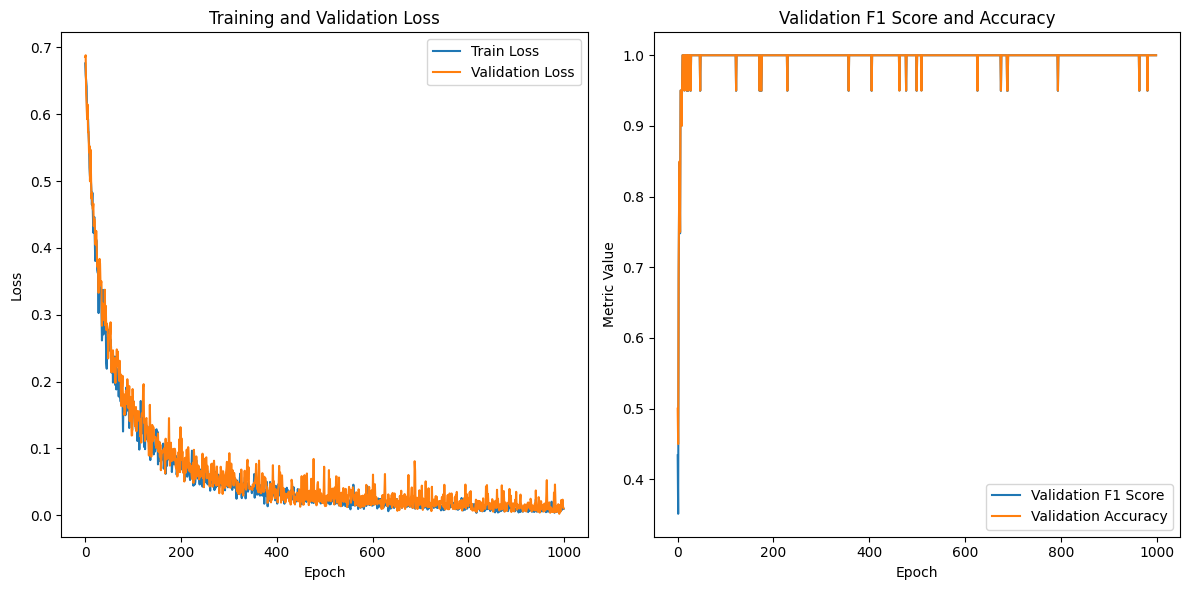

In [ ]:
for (name, df) in df_n_names:
  train_loader, val_loader, dataset = make_train_val_loaders_n_dataset(df)
  model = make_model()
  model_save_path = f'/content/drive/MyDrive/plants_classification/models/resnet50_ovr_{name}_again.pth'
  model, train_losses, val_losses, val_f1_scores, val_accuracies = train_model(model, model_save_path, train_loader, val_loader)
  plot_save_filename = f'{name}_again_clf_learning_curves.png'
  make_plot(plot_save_filename, train_losses, val_losses, val_f1_scores, val_accuracies)